# This notebook does peak hydrologic discharge calculation
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [145]:
# load libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
import seaborn as sns
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
from datetime import datetime
import textwrap
import re
import os
import glob
from tqdm import tqdm
import datetime

In [146]:
import warnings
# Suppress the specific RuntimeWarning
warnings.filterwarnings("ignore")
# Suppress all UserWarnings, including PerformanceWarnings
warnings.simplefilter('ignore', category=UserWarning)
# plot with Arial font
plt.rcParams['font.family'] = 'Arial'

In [147]:
# Load culverts watershed
file_path=r"D:\culvert repo\Results\waterhsed_delineation_dir\combined_watersheds_info.shp"
culvert = gpd.read_file(file_path)
# Show the data frame
print(culvert.shape)
# Show the data frame columns
print(culvert.columns)
# number of rows with nan
print(f'number of rows with nan value: {int(culvert.isna().any(axis=1).sum())}')

(7474, 36)
Index(['BIN', 'Ini_lon', 'Ini_lat', 'lonsnap_10', 'latsnap_10', 'Area_10',
       'Peri_10', 'LFP_len_10', 'LFP_S_10', 'Bas_S_10', 'cul_S10',
       'lonsnap_20', 'latsnap_20', 'Area_20', 'Peri_20', 'LFP_len_20',
       'LFP_S_20', 'Bas_S_20', 'cul_S20', 'lonsnap_40', 'latsnap_40',
       'Area_40', 'Peri_40', 'LFP_len_40', 'LFP_S_40', 'Bas_S_40', 'cul_S40',
       'lonsnap_80', 'latsnap_80', 'Area_80', 'Peri_80', 'LFP_len_80',
       'LFP_S_80', 'Bas_S_80', 'cul_S80', 'geometry'],
      dtype='object')
number of rows with nan value: 0


# Filter culverts to include only verified ones

In [148]:
# Remove duplicate rows based on the BIN column, keep the first instance
culvert_cleaned = culvert.drop_duplicates(subset=['BIN'], keep='first')
# Reset the index
culvert_cleaned.reset_index(drop=True, inplace=True)
# Print the shape to verify
print(culvert_cleaned.shape)

(7474, 36)


In [149]:
culvert_cleaned.columns

Index(['BIN', 'Ini_lon', 'Ini_lat', 'lonsnap_10', 'latsnap_10', 'Area_10',
       'Peri_10', 'LFP_len_10', 'LFP_S_10', 'Bas_S_10', 'cul_S10',
       'lonsnap_20', 'latsnap_20', 'Area_20', 'Peri_20', 'LFP_len_20',
       'LFP_S_20', 'Bas_S_20', 'cul_S20', 'lonsnap_40', 'latsnap_40',
       'Area_40', 'Peri_40', 'LFP_len_40', 'LFP_S_40', 'Bas_S_40', 'cul_S40',
       'lonsnap_80', 'latsnap_80', 'Area_80', 'Peri_80', 'LFP_len_80',
       'LFP_S_80', 'Bas_S_80', 'cul_S80', 'geometry'],
      dtype='object')

In [150]:
# Sanity checks (Area and length cant be negative)
conditions = {
    'Area_10': culvert_cleaned['Area_10'] <= 0,
    'Area_20': culvert_cleaned['Area_20'] <= 0,
    'Area_40': culvert_cleaned['Area_40'] <= 0,
    'Area_80': culvert_cleaned['Area_80'] <= 0,
    'LFP_len_10': culvert_cleaned['LFP_len_10'] <= 0,
    'LFP_len_20': culvert_cleaned['LFP_len_20'] <= 0,
    'LFP_len_40': culvert_cleaned['LFP_len_40'] <= 0,
    'LFP_len_80': culvert_cleaned['LFP_len_80'] <= 0,
    'Bas_S_10':culvert_cleaned['Bas_S_10'] <= 0,
    'Bas_S_20':culvert_cleaned['Bas_S_20'] <= 0,
    'Bas_S_40':culvert_cleaned['Bas_S_40'] <= 0,
    'Bas_S_80':culvert_cleaned['Bas_S_80'] <= 0,

}
# Print the number of rows to be removed and their percentages for each column
for col, condition in conditions.items():
    count = condition.sum()
    percent = (count / len(culvert_cleaned)) * 100
#    print(f'Rows with {col} <= 0: {count}, percent of rows: {percent:.2f} %')
# Combine the conditions to get the total number of rows to be removed
combined_conditions = np.logical_or.reduce(list(conditions.values()))
# Replace values based on combined conditions with NaN
for col in culvert_cleaned.columns:
    if col in conditions:
        culvert_cleaned[col] = np.where(combined_conditions, np.nan, culvert_cleaned[col])
# Create a new dataframe with rows that don't have any NaN values in the specified columns
Culvert_clea_remov = culvert_cleaned.dropna(subset=conditions.keys())
culvert=Culvert_clea_remov
# Print the total number of changed records
num_removed_combined = combined_conditions.sum()
#print(f'Total number of removed records: {num_removed_combined}, percent of rows: {(num_removed_combined / len(culvert_cleaned)) * 100:.1f} %')
#print(f'Number of rows with nan value in culvert dataframe: {int(culvert.isna().any(axis=1).sum())}')
print(f'Culvert dataframe shape is {culvert.shape}')

Culvert dataframe shape is (7136, 36)


#### Compare the drainge area with streamstats calculation

In [ ]:
#load the drain area of the streamstats
file_path=r"D:\culvert repo\Results\Streamstats results\all_merged_culverts_watersheds.shp"
streamstats_watersheds = gpd.read_file(file_path)
streamstats=streamstats_watersheds.drop_duplicates(subset=['BIN'],keep='first')
streamstats.reset_index(drop=True, inplace=True)
streamstats.head()

In [152]:
np.shape(streamstats)

(6351, 92)

In [153]:
def process_culvert_delineation(culvert, streamstats_watersheds):
    # Merge StreamStats drainage area into culvert dataframe
    culvert = culvert.merge(streamstats, on='BIN', how='left')

    # Calculate Closest_Area and diff_area where DRNAREA is available
    mask_has_drnarea = culvert['DRNAREA'].notna()
    converted_areas = culvert.loc[mask_has_drnarea, ['Area_10', 'Area_20', 'Area_40', 'Area_80']] / 2.59e6
    differences = (converted_areas.T - culvert.loc[mask_has_drnarea, 'DRNAREA'].values).abs().T

    # Assign closest area and diff_area for those with DRNAREA
    culvert.loc[mask_has_drnarea, 'Closest_Area'] = differences.idxmin(axis=1).str.extract(r'(\d+)')[0]
    culvert.loc[mask_has_drnarea, 'diff_area'] = differences.min(axis=1) / culvert.loc[mask_has_drnarea, 'DRNAREA']

    # Assign delineation accuracy
    culvert['delineation_accuracy'] = culvert['diff_area'].apply(
        lambda x: True if pd.notna(x) and x <= 0.25 else False if pd.notna(x) else None
    )

    # Create mapping dictionaries
    area_mapping = {'10': 'Area_10', '20': 'Area_20', '40': 'Area_40', '80': 'Area_80'}
    LFP_Len_mapping = {'10': 'LFP_len_10', '20': 'LFP_len_20', '40': 'LFP_len_40', '80': 'LFP_len_80'}
    LFP_slo_mapping = {'10': 'LFP_S_10', '20': 'LFP_S_20', '40': 'LFP_S_40', '80': 'LFP_S_80'}
    cul_slo_mapping = {'10': 'cul_S10', '20': 'cul_S20', '40': 'cul_S40', '80': 'cul_S80'}
    Basin_slo_mapping = {'10': 'Bas_S_10', '20': 'Bas_S_20', '40': 'Bas_S_40', '80': 'Bas_S_80'}

    # Assign values only to culverts with accurate delineation
    mask_true = culvert['delineation_accuracy'] == True
    culvert.loc[mask_true, 'Area'] = culvert.loc[mask_true].apply(
        lambda row: row[area_mapping[row['Closest_Area']]], axis=1)
    culvert.loc[mask_true, 'LFP_len'] = culvert.loc[mask_true].apply(
        lambda row: row[LFP_Len_mapping[row['Closest_Area']]], axis=1)
    culvert.loc[mask_true, 'LFP_S'] = culvert.loc[mask_true].apply(
        lambda row: row[LFP_slo_mapping[row['Closest_Area']]], axis=1)
    culvert.loc[mask_true, 'cul_S'] = culvert.loc[mask_true].apply(
        lambda row: row[cul_slo_mapping[row['Closest_Area']]], axis=1)
    culvert.loc[mask_true, 'Bas_S'] = culvert.loc[mask_true].apply(
        lambda row: row[Basin_slo_mapping[row['Closest_Area']]], axis=1)
    
    # Explicitly set NaN for culverts with inaccurate or missing delineation
    mask_false_or_none = culvert['delineation_accuracy'] != True
    culvert.loc[mask_false_or_none, ['Area', 'LFP_len', 'LFP_S', 'cul_S', 'Bas_S']] = np.nan
    
    # Step to ensure NaN values for missing DRNAREA rows
    mask_missing = ~mask_has_drnarea
    culvert.loc[mask_missing, ['Closest_Area', 'diff_area', 'delineation_accuracy',
                               'Area', 'LFP_len', 'LFP_S', 'cul_S', 'Bas_S']] = np.nan
    return culvert

culvert = process_culvert_delineation(culvert, streamstats)

# Optional: check results
print(f"Total culverts with accurate delineation: {culvert['delineation_accuracy'].sum()}")

Total culverts with accurate delineation: 3268


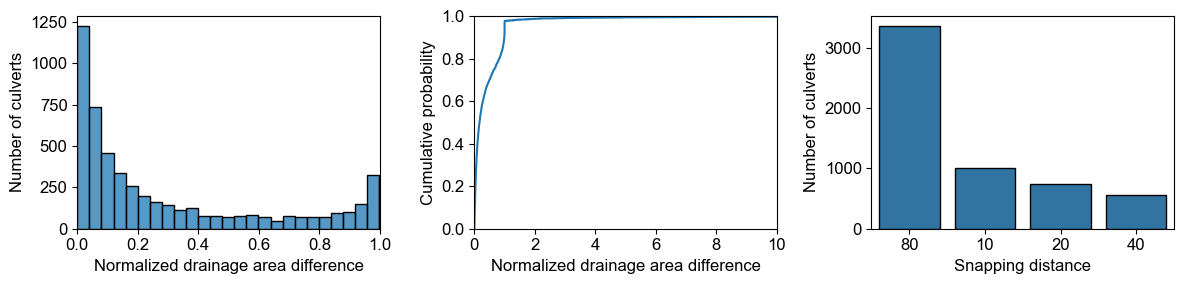

In [154]:
# set the font size
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # Two subplots in one row
# Histogram
sns.histplot(culvert.diff_area, bins=2000, edgecolor='black', linewidth=1, ax=axes[0])
axes[0].set_xlabel(r'Normalized drainage area difference')
axes[0].set_ylabel('Number of culverts')
axes[0].set_xlim(0, 1)
# CDF
sns.ecdfplot(culvert.diff_area, ax=axes[1])
axes[1].set_xlabel(r'Normalized drainage area difference')
axes[1].set_ylabel('Cumulative probability')
axes[1].set_xlim(0, 10)
# Histogram
unique_counts = culvert.Closest_Area.value_counts()
sns.barplot(x=unique_counts.index, y=unique_counts.values, edgecolor='black', ax=axes[2])
axes[2].set_ylabel('Number of culverts')
axes[2].set_xlabel('Snapping distance')
plt.tight_layout()  
plt.savefig("D:\culvert repo\Results\Figures\delineation_error_stats_all.png",dpi=300,bbox_inches='tight')
plt.show()

#### Large culvert basins might result from too big a snapping distance, so they are filtered.


In [155]:
# Step 1: Assign delineation accuracy
culvert['delineation_accuracy'] = culvert['Area'].apply(
    lambda x: True if pd.notna(x) and x <= 1e7 else False if pd.notna(x) else None
)
# Step 2: Set variables to NaN where Area > 10^7
mask_large_area = culvert['Area'] > 1e7
print(f'Number of culverts with area more than 10 square km with similar drainage to streamstats {np.sum(mask_large_area)}')
culvert

Number of culverts with area more than 10 square km with similar drainage to streamstats 394


BIN    Ini_lon    Ini_lat  lonsnap_10  latsnap_10       Area_10  \
0     C810530 -73.429865  42.334525  -73.429844   42.334566  2.673297e+01   
1     C810540 -73.413932  42.345825  -73.413873   42.345798  7.029782e+01   
2     C810550 -73.426565  42.356158  -73.426511   42.356142  5.148572e+01   
3     C810541 -73.428248  42.360891  -73.428303   42.360900  6.831760e+01   
4     C810570 -73.430782  42.370858  -73.430722   42.370833  3.762418e+01   
...       ...        ...        ...         ...         ...           ...   
7131  C520244 -79.754931  42.020207  -79.754915   42.020173  3.507870e+01   
7132  C520245 -79.732181  42.025557  -79.732223   42.025584  1.804048e+01   
7133  C520214 -79.693698  42.022424  -79.693647   42.022455  2.204947e+01   
7134  C520247 -79.697515  42.024057  -79.697524   42.024093  2.104722e+01   
7135  C520248 -79.671764  42.021457  -79.671724   42.021486  2.244306e+06   

           Peri_10   LFP_len_10  LFP_S_10   Bas_S_10  ...  Shape_Area  \
0        35.821539    11.428346     2.926   2.309196  ...   1288100.0   
1        59.702565    22.615254     8.192  10.916072  ...    831700.0   
2        43.781881    15.991400     3.700   4.434731  ...   2235300.0   
3        53.732309    16.986442     2.565   2.596205  ...  14533300.0   
4        35.821539    11.016186     6.422  10.025314  ...    704200.0   
...            ...          ...       ...        ...  ...         ...   
7131     32.035958     9.839471     6.828  11.708542  ...   1924600.0   
7132     30.033711     8.666582     5.307   3.539234  ...   3459800.0   
7133     38.042700    13.672200     2.289   2.055939  ...   2737300.0   
7134     32.035958    11.083508     2.075   1.943400  ...   5810200.0   
7135  11480.886496  3466.854215     2.428   9.796019  ...   2124900.0   

                                             geometry_y  Closest_Area  \
0     POLYGON ((-73.43297 42.3332, -73.43443 42.3332...            20   
1     MULTIPOLYGON (((-73.41396 42.34581, -73.41384 ...            20   
2     POLYGON ((-73.43657 42.34477, -73.43693 42.344...            20   
3     MULTIPOLYGON (((-73.40445 42.38099, -73.40446 ...            80   
4     POLYGON ((-73.42463 42.36595, -73.42475 42.365...            40   
...                                                 ...           ...   
7131  POLYGON ((-79.74212 41.99483, -79.74248 41.994...            80   
7132  MULTIPOLYGON (((-79.71468 42.00568, -79.71467 ...            20   
7133  POLYGON ((-79.68586 41.993, -79.6861 41.99299,...            80   
7134  POLYGON ((-79.68586 41.993, -79.6861 41.99299,...            20   
7135  POLYGON ((-79.65429 42.00356, -79.65633 42.003...            10   

      diff_area  delineation_accuracy          Area       LFP_len  LFP_S  \
0      0.066128                  True  1.380635e+06   2599.805640  3.221   
1      0.326628                  None           NaN           NaN    NaN   
2      0.090318                  True  2.428575e+06   3622.260172  6.594   
3      0.241278                 False  1.102416e+07  11796.304014  1.503   
4      0.895078                  None           NaN           NaN    NaN   
...         ...                   ...           ...           ...    ...   
7131   0.029640                  True  1.859793e+06   4644.329311  3.117   
7132   0.101787                  True  3.823861e+06   6009.566456  2.294   
7133   0.082657                  True  2.518474e+06   5634.633860  2.026   
7134   0.024240                  True  5.942228e+06   6405.483934  1.856   
7135   0.056741                  True  2.244306e+06   3466.854215  2.428   

         cul_S      Bas_S  
0     1.616351  13.681324  
1          NaN        NaN  
2     1.173715  18.400374  
3     3.664910  18.807179  
4          NaN        NaN  
...        ...        ...  
7131  2.824059  14.537201  
7132  0.000170  12.815038  
7133  0.189094  10.653041  
7134 -1.292219  11.216221  
7135 -3.439556   9.796019  

[7136 rows x 135 columns]

#### Culvert in urban areas might have subterranean drainage systems, so they are filtered.

In [156]:
file_path=r"D:\culvert repo\Results\waterhsed_delineation_dir\combined_watersheds_nlcd_proportions.xlsx"
urbanization=pd.read_excel(file_path)
urbanization=urbanization.drop_duplicates(subset=['BIN'])
urbanization[['BIN','urbanized_pro']].head()

BIN  urbanized_pro
0  C810530       0.140065
1  C810540       0.075041
2  C810550       0.030348
3  C810541       0.103532
4  C810570       0.289157

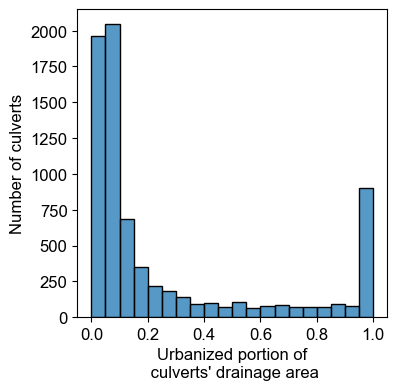

In [157]:
plt.figure(figsize=(4,4))
sns.histplot(urbanization.urbanized_pro, bins=20, edgecolor='black')
plt.xlabel("Urbanized portion of\n culverts' drainage area")
plt.ylabel('Number of culverts')
plt.savefig("D:\culvert repo\Results\Figures\drainagearea_urbanized_portion_hist.png",dpi=300,bbox_inches='tight')

In [158]:
def assign_urbanization_flag(culvert, urbanization_path):
    # Assign urbanized_pro to culvert by BIN match
    culvert = culvert.copy()
    culvert['urbanized_pro'] = culvert['BIN'].map(urbanization.set_index('BIN')['urbanized_pro'])
    # Assign not_urbanized flag
    culvert['not_urbanized'] = culvert['urbanized_pro'].apply(
        lambda x: True if pd.notna(x) and x <= 0.25 else False if pd.notna(x) else None
    )
    return culvert
culvert = assign_urbanization_flag(culvert, urbanization)
print(culvert['not_urbanized'].value_counts())

not_urbanized
True     5040
False    2096
Name: count, dtype: int64


#### Urbanized watersheds might have underground drainage inferastructures so their drainge accuracy needs to be modified.


In [159]:
mask_acc = culvert['delineation_accuracy'] == True
culvert.loc[mask_acc, 'delineation_accuracy'] = culvert.loc[mask_acc, 'not_urbanized'].apply(
    lambda x: True if pd.notna(x) and x == True else False if pd.notna(x) else None)

In [160]:
# assume that 80 m snapping distance is the most representative sanpping distance
culvert.loc[culvert['Area'].isna(), 'Area'] = culvert.loc[culvert['Area'].isna(), 'Area_80']
culvert.loc[culvert['LFP_len'].isna(), 'LFP_len'] = culvert.loc[culvert['LFP_len'].isna(), 'LFP_len_80']
culvert.loc[culvert['LFP_S'].isna(), 'LFP_S'] = culvert.loc[culvert['LFP_S'].isna(), 'LFP_S_80']
culvert.loc[culvert['Bas_S'].isna(), 'Bas_S'] = culvert.loc[culvert['Bas_S'].isna(), 'Bas_S_80']
culvert.loc[culvert['Closest_Area'].isna(), 'Closest_Area'] = 80
np.shape(culvert)

(7136, 137)

#### Time of concentration

0       0.533066
1       0.425165
2       0.937677
3       4.256448
4       4.009497
          ...   
7131    0.718069
7132    1.476400
7133    0.972387
7134    2.294305
7135    0.866531
Name: Area, Length: 7136, dtype: float64

In [161]:
# Kirpich formula
# t_c=0.000325*(l**0.77)*(s_w**-0.385) 
# t_c (hr), l (m), s_w (%)
culvert['t_c'] = (0.0195 * (culvert['LFP_len'] ** 0.77) * ((culvert['Bas_S']/100) ** -0.385))/60

culvert.head()

BIN    Ini_lon    Ini_lat  lonsnap_10  latsnap_10    Area_10  \
0  C810530 -73.429865  42.334525  -73.429844   42.334566  26.732972   
1  C810540 -73.413932  42.345825  -73.413873   42.345798  70.297816   
2  C810550 -73.426565  42.356158  -73.426511   42.356142  51.485724   
3  C810541 -73.428248  42.360891  -73.428303   42.360900  68.317596   
4  C810570 -73.430782  42.370858  -73.430722   42.370833  37.624183   

     Peri_10  LFP_len_10  LFP_S_10   Bas_S_10  ...  diff_area  \
0  35.821539   11.428346     2.926   2.309196  ...   0.066128   
1  59.702565   22.615254     8.192  10.916072  ...   0.326628   
2  43.781881   15.991400     3.700   4.434731  ...   0.090318   
3  53.732309   16.986442     2.565   2.596205  ...   0.241278   
4  35.821539   11.016186     6.422  10.025314  ...   0.895078   

   delineation_accuracy          Area       LFP_len  LFP_S     cul_S  \
0                  True  1.380635e+06   2599.805640  3.221  1.616351   
1                  None  1.101174e+06   2043.767564  6.043       NaN   
2                  True  2.428575e+06   3622.260172  6.594  1.173715   
3                 False  1.102416e+07  11796.304014  1.503  3.664910   
4                  None  1.038456e+07   9518.047804  1.829       NaN   

       Bas_S  urbanized_pro  not_urbanized       t_c  
0  13.681324       0.140065           True  0.297837  
1  16.389305       0.075041           True  0.230839  
2  18.400374       0.030348           True  0.343036  
3  18.807179       0.103532           True  0.844332  
4  18.938731       0.289157          False  0.713814  

[5 rows x 138 columns]

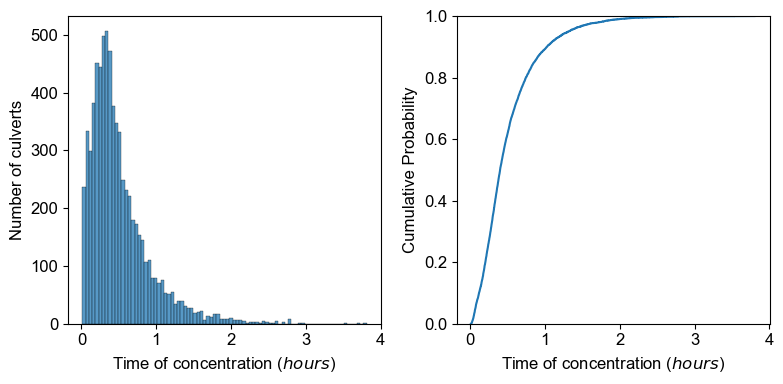

In [162]:
# Plot the time of concentration of all culverts
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# histogram
sns.histplot(culvert['t_c'], kde=False, ax=axes[0])
axes[0].set_xlabel('Time of concentration ($hours$)')
axes[0].set_ylabel('Number of culverts')
# ECDF 
sns.ecdfplot(culvert['t_c'], ax=axes[1])
axes[1].set_xlabel('Time of concentration ($hours$)')
axes[1].set_ylabel('Cumulative Probability')
plt.tight_layout()
plt.savefig("D:\culvert repo\Results\Figures\TC_pdf_cdf_ALL.png",dpi=300,bbox_inches='tight')
plt.show()

In [164]:
culvert['t_c']

0       0.297837
1       0.230839
2       0.343036
3       0.844332
4       0.713814
          ...   
7131    0.454840
7132    0.582265
7133    0.594939
7134    0.643780
7135    0.422746
Name: t_c, Length: 7136, dtype: float64

# CN calculation

In [165]:
# Find all watersheds shapefiles
# Define the root directory
root_dir = r'D:\culvert repo\Results\waterhsed_delineation_dir'
# Define the pattern to search for shapefiles
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
# Use glob to find all matching shapefiles
shapefile_paths = glob.glob(pattern, recursive=True)
# Print the number of shapefiles found
print(f"Found {len(shapefile_paths)} shapefiles.")

Found 29960 shapefiles.


In [166]:
def select_closest_area(row):
    error = str(row['Closest_Area'])
    return error

In [167]:
culvert = culvert.reset_index(drop=True)

In [168]:
#culvert['CN'].isna().sum()
culvert['Closest_Area']

0       20
1       20
2       20
3       80
4       40
        ..
7131    80
7132    20
7133    80
7134    20
7135    10
Name: Closest_Area, Length: 7136, dtype: object

In [169]:
CN_path = r"D:\culvert repo\Results\CN\CN_Map_2021_filled.tif"
# Define the root directory to search in
# Progress bar
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # Find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{row['BIN']}watershed_poly_{int(float(error))}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    from rasterio.mask import mask
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster, excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"CN"] = mean_value

number of processed rows: 100%|██████████| 7136/7136 [06:47<00:00, 17.50it/s]


In [170]:
CN_paths = {
    "dry": r"D:\culvert repo\Results\CN\CN_Map_dry_2021_filled.tif",
    "wet": r"D:\culvert repo\Results\CN\CN_Map_wet_2021_filled.tif"
}
for condition, CN_path in CN_paths.items():
    for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc=f'Processing CN_{condition}'):
        error = select_closest_area(row)
        # Construct the specific filename pattern
        specific_pattern = f"{row['BIN']}watershed_poly_{int(float(error))}m.shp"
        # Find the matching shapefile path
        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
        if matching_path is None:
            print(f"No matching shapefile found for BIN {culvert['BIN'].iloc[idx]}")
            culvert.loc[idx, f"CN_{condition}"] = np.nan
            continue
        # Read watershed shapefile
        watershed = gpd.read_file(matching_path)
        watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
        # Clip the CN raster using watershed geometry
        with rasterio.open(CN_path) as src:
            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
            out_image[out_image == src.nodata] = 0
            # Compute the mean CN value
            if np.count_nonzero(out_image) == 0:
                mean_value = np.nan
            else:
                mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
        # Assign result to culvert dataframe
        culvert.loc[idx, f"CN_{condition}"] = mean_value

Processing CN_wet: 100%|██████████| 7136/7136 [06:58<00:00, 17.05it/s]


In [171]:
culvert[['CN', 'CN_dry', 'CN_wet']]

CN     CN_dry     CN_wet
0     77.519808  60.601441  88.865546
1     75.789116  58.012850  87.919123
2     74.375262  56.567086  86.932914
3     71.417926  53.945071  84.496922
4     78.467742  64.225806  88.782258
...         ...        ...        ...
7131  78.846366  62.241030  89.608556
7132  78.789189  62.111036  89.611712
7133  81.651702  66.107531  91.088342
7134  80.786232  64.937500  90.657156
7135  81.905013  66.393140  91.160196

[7136 rows x 3 columns]

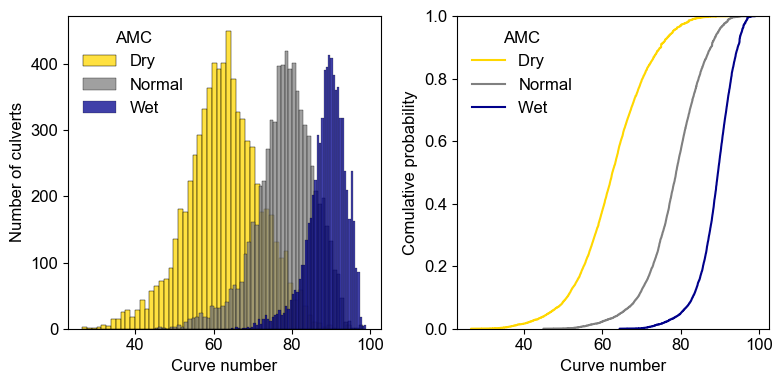

In [172]:
df = culvert[['CN', 'CN_dry', 'CN_wet']]
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Histogram
sns.histplot(df['CN_dry'], kde=False, ax=axes[0], stat='count', label='Dry', color='gold')
sns.histplot(df['CN'], kde=False, ax=axes[0], stat='count', label='Normal', color='gray')
sns.histplot(df['CN_wet'], kde=False, ax=axes[0], stat='count', label='Wet', color='darkblue')
axes[0].legend(title='AMC', frameon=False)
axes[0].set_xlabel('Curve number')
axes[0].set_ylabel('Number of culverts')
# ECDF
sns.ecdfplot(df['CN_dry'], ax=axes[1], label='Dry ', color='gold')
sns.ecdfplot(df['CN'], ax=axes[1], label='Normal', color='gray')
sns.ecdfplot(df['CN_wet'], ax=axes[1], label='Wet ', color='darkblue')
axes[1].set_xlabel('Curve number')
axes[1].set_ylabel('Comulative probability')
axes[1].legend(title='AMC', frameon=False)
# show and save
plt.tight_layout()
plt.savefig("D:\culvert repo\Results\Figures\ASM_CN_his_cdf_All.png",dpi=300,bbox_inches='tight')
plt.show()

#### GEE CN 

In [173]:
# Define the root directory
root_dir = r'D:\culvert repo\Results\waterhsed_delineation_dir'
# Define the pattern to search for shapefiles
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
# Use glob to find all matching shapefiles
shapefile_paths = glob.glob(pattern, recursive=True)
# Print the number of shapefiles found
print(f"Found {len(shapefile_paths)} shapefiles.")

Found 29960 shapefiles.


In [174]:
# normal
CN_path = r"D:\culvert repo\data\initial layers\GEE\GCN250_Average_NY_reprojected.tif"
# Define the root directory to search in
# Progress bar
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # Find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{int(float(error))}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster, excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"GEE_CN"] = mean_value

number of processed rows: 100%|██████████| 7136/7136 [06:45<00:00, 17.62it/s]


In [175]:
# Wet and dry
CN_paths = {
    "dry": r"D:\culvert repo\data\initial layers\GEE\GCN250_Dry_NY_reprojected.tif",
    "wet": r"D:\culvert repo\data\initial layers\GEE\GCN250_Wet_NY_reprojected.tif"
}
# Define the root directory to search in
# Progress bar
for condition, CN_path in CN_paths.items():
    for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
        error=select_closest_area(row)
        ###############################################################################################################################################
        # Find the path to the file 
        # Construct the specific filename pattern
        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{int(float(error))}m.shp"
        # Find the path related to the specific pattern
        matching_path = None
        for path in shapefile_paths:
            if specific_pattern in os.path.basename(path):
                matching_path = path
                break
        if matching_path is None:
            print("No matching shapefile found.")
            culvert.loc[idx, f"CN"] = np.nan
            continue
        ###############################################################################################################################################
        watershed_polygone = matching_path
        watershed = gpd.read_file(watershed_polygone)
        # Convert the watershed boundary to GeoJSON-like format
        watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
        ###############################################################################################################################################
        # Open the precipitation TIFF file and clip it using the watershed boundary
        with rasterio.open(CN_path) as src:
            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
            # Set NoData value
            out_image[out_image == src.nodata] = 0
            # Calculate the mean of the clipped raster, excluding NoData values
            if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                mean_value = np.nan
            else:
                mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
        # Update the DataFrame with the mean value for the given error
        culvert.loc[idx, f"GEE_CN_{condition}"] = mean_value

number of processed rows: 100%|██████████| 7136/7136 [06:27<00:00, 18.41it/s]


In [176]:
# https://rashms.com/blog/time-of-concentration-toc-estimation/
culvert['t_c_w'] = (0.0077 * (culvert[f'LFP_len']*3.28) / ((culvert['Area']*0.000247105)**0.1) * ((culvert['Bas_S']/100)**0.2))/60

In [177]:
# https://www.sciencedirect.com/science/article/pii/S2214581822000386#bib53
# Simas and Hawkins (1996)
culvert['t_c_SH'] = 0.6 * 53.14 * (((culvert['Area']*0.000247105)/(culvert[f'LFP_len']*3.28))**0.594) * ((culvert['Bas_S']/100)**(-0.150))* ((1000/culvert[f'CN'])-10)**0.313

In [240]:
# Calculate the time of the concentration based on different ASM states using NRCS method which is based on CN
culvert[f't_c_CN'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_CN_dry'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN_dry'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_CN_wet'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN_wet'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_GEE_CN'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_GEE_CN_dry'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN_dry'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
culvert[f't_c_GEE_CN_wet'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN_wet'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)

culvert[['CN','GEE_CN',	'CN_dry', 'GEE_CN_dry',	'CN_wet','GEE_CN_wet','t_c_CN','t_c_GEE_CN',	't_c_CN_dry','t_c_GEE_CN_dry','t_c_CN_wet','t_c_GEE_CN_wet']].head()

CN     GEE_CN     CN_dry  GEE_CN_dry     CN_wet  GEE_CN_wet  \
0  77.519808  71.750000  60.601441   52.730769  88.865546   85.826923   
1  75.789116  72.000000  58.012850   53.000000  87.919123   86.000000   
2  74.375262  70.023529  56.567086   50.917647  86.932914   84.623529   
3  71.417926  73.064220  53.945071   54.611621  84.496922   86.660550   
4  78.467742  77.333333  64.225806   60.111111  88.782258   89.333333   

     t_c_CN  t_c_GEE_CN  t_c_CN_dry  t_c_GEE_CN_dry  t_c_CN_wet  \
0  0.857872    1.011869    1.356053        1.654224    0.584265   
1  0.680355    0.757367    1.091235        1.238275    0.456780   
2  1.057055    1.192507    1.688351        1.947202    0.707135   
3  2.920351    2.790159    4.588063        4.511600    1.962409   
4  2.001242    2.070675    2.966579        3.295776    1.407035   

   t_c_GEE_CN_wet  
0        0.654803  
1        0.490440  
2        0.768104  
3        1.816879  
4        1.376661

#### Comparison of the two methods for $t_c$ calculation

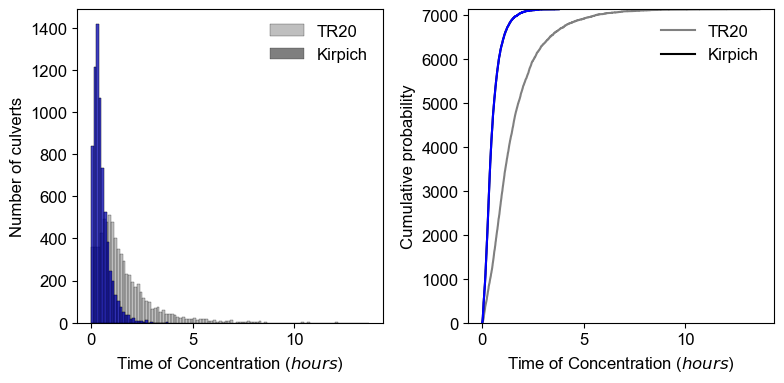

In [180]:
# Create a figure with two subplots
### add  to histplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# ECDF
sns.ecdfplot(culvert[f't_c_CN'], label='TR20',stat='count', linewidth=1.5, ax=axs[1],color='gray')
sns.ecdfplot(culvert['t_c'], label='Kirpich',stat='count', linewidth=1.5,color='black', ax=axs[1])
sns.ecdfplot(culvert['t_c'],stat='count', linewidth=1.5,color='blue', ax=axs[1])

axs[0].set_xlabel(f"Time of Concentration ($hours$)")
axs[0].set_ylabel("Number of culverts")
axs[1].legend(frameon=False)
# Histogram
sns.histplot(culvert[f't_c_CN'], kde=False, label='TR20', color='gray', ax=axs[0], alpha=0.5)
sns.histplot(culvert['t_c'], label='Kirpich', kde=False, bins=30, color='black', ax=axs[0], alpha=0.5)
sns.histplot(culvert['t_c'], kde=False, bins=30, color='blue', ax=axs[0], alpha=0.5)

axs[0].legend(frameon=False)
axs[1].set_xlabel(f"Time of Concentration ($hours$)")
axs[1].set_ylabel("Cumulative probability")
# show and save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\kirpich_NRCS_comparison_tc_methods_All.png", dpi=300, bbox_inches='tight')
plt.show()

In [185]:
culvert['t_c'].isna().sum()

np.int64(0)

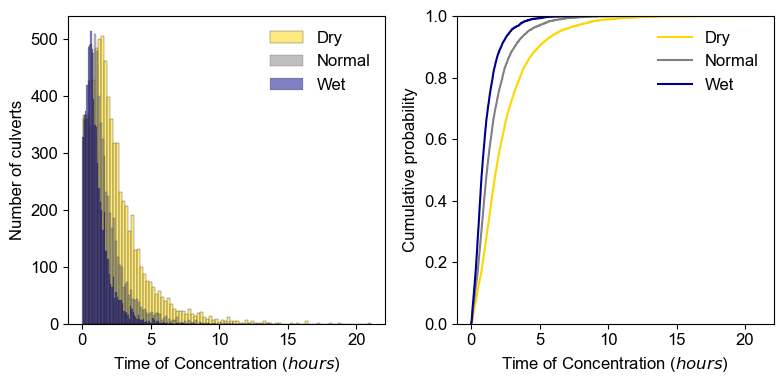

In [186]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# ECDF
sns.ecdfplot(culvert[f't_c_CN_dry'], label=f'Dry', linewidth=1.5, ax=axs[1], color='gold')
sns.ecdfplot(culvert[f't_c_CN'], label=f'Normal', linewidth=1.5, ax=axs[1],color='gray')
sns.ecdfplot(culvert[f't_c_CN_wet'], label=f'Wet', linewidth=1.5, ax=axs[1],color='darkblue')
axs[0].set_xlabel(f"Time of Concentration ($hours$)")
axs[0].set_ylabel("Number of culverts")
axs[1].legend(frameon=False)

# Histogram
sns.histplot(culvert[f't_c_CN_dry'], kde=False,stat='count', label='Dry', color='gold', ax=axs[0], alpha=0.5)
sns.histplot(culvert[f't_c_CN'], kde=False,stat='count', label='Normal', color='gray', ax=axs[0], alpha=0.5)
sns.histplot(culvert[f't_c_CN_wet'], kde=False,stat='count', label='Wet', color='darkblue', ax=axs[0], alpha=0.5)
axs[0].legend(frameon=False)
axs[1].set_xlabel(f"Time of Concentration ($hours$)")
axs[1].set_ylabel("Cumulative probability")
# show and save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\tc_NRCS_ASM_All.png", dpi=300, bbox_inches='tight')
plt.show()

In [187]:
culvert['t_c'].describe()

count    7136.000000
mean        0.509961
std         0.409705
min         0.011575
25%         0.238006
50%         0.400393
75%         0.663008
max         3.812930
Name: t_c, dtype: float64

In [188]:
# Identify all geometry columns
geom_cols = [col for col in culvert.columns if isinstance(culvert[col].dtype, gpd.array.GeometryDtype)]

# Drop the second geometry column (if it exists)
if len(geom_cols) > 1:
    culvert = culvert.drop(columns=geom_cols[1])

In [189]:
# save to .shp
output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_All.shp'
culvert.to_file(output_file)
print(f"culvert_CN_tc saved to {output_file}")
# Save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_All.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_All.shp
culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_All.xlsx


In [190]:
culvert = gpd.read_file(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_All.xlsx')

#### Calculate the CN based on projected land uses

In [261]:
for scenario in ['A1B']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    error=select_closest_area(row)
                    ###############################################################################################################################################
                    # Find the path to the file 
                    # Construct the specific filename pattern
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster, excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

A1B 2030


number of processed rows: 100%|██████████| 7136/7136 [06:40<00:00, 17.83it/s]


A1B 2040


number of processed rows: 100%|██████████| 7136/7136 [06:41<00:00, 17.76it/s]


A1B 2050


number of processed rows: 100%|██████████| 7136/7136 [06:40<00:00, 17.81it/s]


A1B 2060


number of processed rows: 100%|██████████| 7136/7136 [06:50<00:00, 17.38it/s]


A1B 2070


number of processed rows: 100%|██████████| 7136/7136 [06:43<00:00, 17.70it/s]


A1B 2080


number of processed rows: 100%|██████████| 7136/7136 [06:36<00:00, 18.02it/s]


A1B 2090


number of processed rows: 100%|██████████| 7136/7136 [06:40<00:00, 17.81it/s]


A1B 2100


number of processed rows: 100%|██████████| 7136/7136 [06:37<00:00, 17.96it/s]


In [262]:
# save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_CN_tc_All.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_CN_tc_All.xlsx


In [263]:
for scenario in ['A2']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # Find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster, excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

A2 2030


number of processed rows: 100%|██████████| 7136/7136 [06:42<00:00, 17.74it/s]


A2 2040


number of processed rows: 100%|██████████| 7136/7136 [06:40<00:00, 17.83it/s]


A2 2050


number of processed rows: 100%|██████████| 7136/7136 [06:11<00:00, 19.22it/s]


A2 2060


number of processed rows: 100%|██████████| 7136/7136 [06:32<00:00, 18.17it/s]


A2 2070


number of processed rows: 100%|██████████| 7136/7136 [06:35<00:00, 18.03it/s]


A2 2080


number of processed rows: 100%|██████████| 7136/7136 [06:32<00:00, 18.17it/s]


A2 2090


number of processed rows: 100%|██████████| 7136/7136 [06:40<00:00, 17.84it/s]


A2 2100


number of processed rows: 100%|██████████| 7136/7136 [06:33<00:00, 18.11it/s]


In [264]:
# save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_CN_tc_All.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_CN_tc_All.xlsx


In [265]:
for scenario in ['B1']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # Find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster, excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

B1 2030


number of processed rows: 100%|██████████| 7136/7136 [06:41<00:00, 17.77it/s]


B1 2040


number of processed rows: 100%|██████████| 7136/7136 [06:38<00:00, 17.92it/s]


B1 2050


number of processed rows: 100%|██████████| 7136/7136 [06:31<00:00, 18.23it/s]


B1 2060


number of processed rows: 100%|██████████| 7136/7136 [06:28<00:00, 18.38it/s]


B1 2070


number of processed rows: 100%|██████████| 7136/7136 [06:22<00:00, 18.67it/s]


B1 2080


number of processed rows: 100%|██████████| 7136/7136 [06:21<00:00, 18.72it/s]


B1 2090


number of processed rows: 100%|██████████| 7136/7136 [06:27<00:00, 18.42it/s]


B1 2100


number of processed rows: 100%|██████████| 7136/7136 [06:47<00:00, 17.53it/s]


In [266]:
# save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_CN_tc_All.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_CN_tc_All.xlsx


In [269]:
for scenario in ['B2']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # Find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster, excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

B2 2030


number of processed rows: 100%|██████████| 7136/7136 [06:59<00:00, 17.00it/s]


B2 2040


number of processed rows: 100%|██████████| 7136/7136 [06:50<00:00, 17.39it/s]


B2 2050


number of processed rows: 100%|██████████| 7136/7136 [07:07<00:00, 16.68it/s]


B2 2060


number of processed rows: 100%|██████████| 7136/7136 [06:35<00:00, 18.04it/s]


B2 2070


number of processed rows: 100%|██████████| 7136/7136 [06:24<00:00, 18.54it/s]


B2 2080


number of processed rows: 100%|██████████| 7136/7136 [06:31<00:00, 18.22it/s]


B2 2090


number of processed rows: 100%|██████████| 7136/7136 [06:45<00:00, 17.61it/s]


B2 2100


number of processed rows: 100%|██████████| 7136/7136 [06:48<00:00, 17.48it/s]


In [270]:
# save to an Excel file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_B2_CN_tc_All.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_B2_CN_tc_All.xlsx


In [65]:
# Calculate the time of the concentration based on the projected CN value
for scenario in ['A1B', 'A2', 'B1', 'B2']:
    for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]:
        for ASM in [ 'Wet']:
            culvert[f't_CN_{year}_{scenario}_{ASM}'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*\
            ((1000/culvert[f'CN_{year}_{scenario}_{ASM}'])-10+1)**0.7 )/(1140*culvert[f'Bas_S']**0.5)
# Show the results
culvert.head()

BIN    Ini_lon    Ini_lat  lonsnap_10  latsnap_10    Area_10  \
0  C810530 -73.429865  42.334525  -73.429844   42.334566  26.732972   
1  C810540 -73.413932  42.345825  -73.413873   42.345798  70.297816   
2  C810550 -73.426565  42.356158  -73.426511   42.356142  51.485724   
3  C810541 -73.428248  42.360891  -73.428303   42.360900  68.317596   
4  C810570 -73.430782  42.370858  -73.430722   42.370833  37.624183   

     Peri_10  LFP_len_10  LFP_S_10   Bas_S_10  ...  rain_1000_05m_au  \
0  35.821539   11.428346     2.926   2.309196  ...          4.795157   
1  59.702565   22.615254     8.192  10.916072  ...          4.760383   
2  43.781881   15.991400     3.700   4.434731  ...          4.798060   
3  53.732309   16.986442     2.565   2.596205  ...          4.756150   
4  35.821539   11.016186     6.422  10.025314  ...          4.774353   

   rain_1000_10m_au  rain_1000_15m_au  rain_1000_30m_au  rain_1000_60m_au  \
0          6.793049          7.992291         11.123386         14.255569   
1          6.743700          7.933267         11.073130         14.212993   
2          6.797040          7.996382         11.140902         14.284960   
3          6.737435          7.926578         11.100477         14.274292   
4          6.763173          7.956973         11.118427         14.279880   

   rain_1000_02h_au  rain_1000_03h_au  rain_1000_06h_au  rain_1000_12h_au  \
0         17.756051         20.638951         27.854729         38.201963   
1         17.685173         20.552410         27.753733         38.106773   
2         17.810942         20.685298         27.806535         37.941596   
3         17.818862         20.658074         27.588210         37.332497   
4         17.812173         20.661207         27.658907         37.547127   

   rain_1000_24h_au  
0         48.850731  
1         48.723550  
2         48.333429  
3         47.218092  
4         47.619920  

[5 rows x 553 columns]

In [84]:
# Find rows where t_c_GEE_CN_wet is NaN or non-positive
invalid_rows = culvert [
    (culvert['t_c_CN_wet'].isna()) |
    (culvert['t_c_GEE_CN_wet'].isna()) |
    (culvert['t_c_CN_wet'] <= 0) |
    (culvert['t_c_GEE_CN_wet'] <= 0)
                        ]

# Print the relevant columns and BIN to identify problematic rows
print(invalid_rows[['BIN', 't_c_CN_wet', 't_c_GEE_CN_wet', 'Area_80']])

          BIN  t_c_CN_wet  t_c_GEE_CN_wet       Area_80
386   C150007    1.295133             NaN  5.775071e+06
2513  CA00454    5.114960             NaN  1.085349e+08
5022  C450049    0.674125             NaN  4.068187e+06
5141  C620165    1.867138             NaN  2.037137e+06
5173  C620140    0.591448             NaN  9.941896e+05
...       ...         ...             ...           ...
6729      NaN         NaN             NaN           NaN
6798      NaN         NaN             NaN           NaN
6823      NaN         NaN             NaN           NaN
6835      NaN         NaN             NaN           NaN
6844      NaN         NaN             NaN           NaN

[283 rows x 4 columns]


In [82]:
# Define a mask for valid rows
valid_mask = (
    culvert['t_c_CN_wet'].notna() & (culvert['t_c_CN_wet'] > 0) &
    culvert['t_c_GEE_CN_wet'].notna() & (culvert['t_c_GEE_CN_wet'] > 0) &
    culvert['Area_80'].notna() & (culvert['Area_80'] > 0)
)

# Filter and overwrite culvert to keep only valid rows
culvert = culvert[valid_mask].reset_index(drop=True)
print(f"Remaining rows after filtering: {len(culvert)}")

Remaining rows after filtering: 7125


In [272]:
# save to .xlsx
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_CN_tc_All.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_CN_tc_All.xlsx


In [273]:
#set the plotting parameters
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 18, 'axes.titlesize': 20,
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'legend.fontsize': 16})

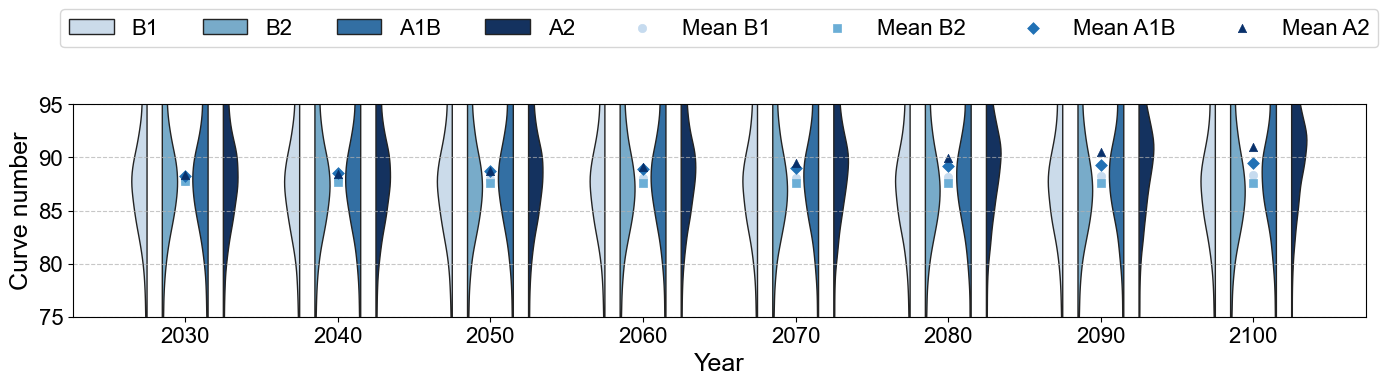

In [274]:
# Define scenarios and years
scenarios = ['B1', 'B2', 'A1B', 'A2']  # Ensuring light-to-dark order
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]

# Reshape data into long format for violin plot
data = {'Year': [], 'Scenario': [], 'CN Value': []}
mean_data = {'Year': [], 'Scenario': [], 'Mean CN': []}

for year in years:
    for scenario in scenarios:
        cn_values = culvert[f'CN_{year}_{scenario}_Wet'].dropna()  # Drop NaNs
        for value in cn_values:
            data['Year'].append(year)
            data['Scenario'].append(scenario)
            data['CN Value'].append(value)
        # Store the mean CN value for the overlay line
        mean_data['Year'].append(year)
        mean_data['Scenario'].append(scenario)
        mean_data['Mean CN'].append(cn_values.mean())

# Convert to DataFrames
df_violin = pd.DataFrame(data)
df_mean = pd.DataFrame(mean_data)

# Set up the plot
plt.figure(figsize=(15, 5))

# Define a consistent color palette for scenarios (light to dark)
palette = ['#c6dbef', '#6baed6', '#2171b5', '#08306b']  # B1 (lightest) → B2 → A1B → A2 (darkest)
markers = ['o', 's', 'D', '^']

# Violin plot for CN distributions (with correct order)
sns.violinplot(data=df_violin, x='Year', y='CN Value', hue='Scenario', order=years,
               hue_order=scenarios, split=True, palette=palette, inner=None, linewidth=1, gap=0.5)

# Overlay mean trend lines
for i, scenario in enumerate(scenarios):
    subset = df_mean[df_mean['Scenario'] == scenario]
    x_positions = np.arange(len(years))  # Align x-values with categorical axis
    plt.scatter(x_positions, subset['Mean CN'], marker=markers[i], linestyle='-', linewidth=0.5,
                label=f'Mean {scenario}', color=palette[i])

# Adjust x-axis labels to match categorical years
plt.xticks(ticks=np.arange(len(years)), labels=years)
plt.ylim(75, 95)

# Plot styling
plt.ylabel("Curve number")
plt.xlabel("Year")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5), ncol=len(scenarios) * 2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
plt.savefig(r"D:\culvert repo\Results\Figures\CN_distribution_culvert_2030_2100_All.png", dpi=300)
plt.show()


# compute $S$ and $I_a$

In [191]:
# Calculate average storage for the drainage area for normal, dry, and wet asm
# S=(2540/CN)-25.4
# S storage (cm)
culvert[f'S']=(2540/culvert[f'CN'])-25.4
# Calculation of initial abstraction (Ia=0.2*S) (cm)
culvert[f'Ia']=0.2*culvert[f'S']
# For dry and wet conditions of the current land use
for asm in['dry','wet']:
    culvert[f'S_{asm}']=(2540/culvert[f'CN_{asm}'])-25.4
    # Calculation of initial abstraction (Ia=0.2*S) Ia(cm)
    culvert[f'Ia_{asm}']=0.2*culvert[f'S_{asm}']

In [275]:
# Calculate average storage for the drainage area for normal, dry, and wet asm
# S=(2540/CN)-25.4
# S storage (cm)
culvert[f'S']=(2540/culvert[f'CN'])-25.4
# Calculation of initial abstraction (Ia=0.2*S) (cm)
culvert[f'Ia']=0.2*culvert[f'S']
# For dry and wet conditions of the current land use
for asm in['dry','wet']:
    culvert[f'S_{asm}']=(2540/culvert[f'CN_{asm}'])-25.4
    # Calculation of initial abstraction (Ia=0.2*S) Ia(cm)
    culvert[f'Ia_{asm}']=0.2*culvert[f'S_{asm}']
# for future land use projections
for scenario in ['A1B','A2','B1','B2']:
    for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
        for ASM in ['Wet']:
            culvert[f'S_{year}_{scenario}_{ASM}']=(2540/culvert[f'CN_{year}_{scenario}_{ASM}'])-25.4
            # Calculation of initial abstraction (Ia=0.2*S) (cm)
            culvert[f'Ia_{year}_{scenario}_{ASM}']=0.2*culvert[f'S_{year}_{scenario}_{ASM}']

In [192]:
# Save the DataFrame to an Excel file
output_file = r'D:\hydrological analysis\data\Peak hydrologic discharge\culvert_CN_tc_S_Ia_All_V2.xlsx'
culvert.to_excel(output_file, index=False)
print(f"culvert_CN_tc_S_Ia saved to {output_file}")

culvert_CN_tc_S_Ia saved to D:\hydrological analysis\data\Peak hydrologic discharge\culvert_CN_tc_S_Ia_All_V2.xlsx


#### Compute historical average precipitation depth for different return periods and duration for each culvert's basin 

In [193]:
# Extract percipitation data
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
bounds = ['a']
# Create an overall progress bar
total_iterations = len(return_periods) * len(durations) * len(bounds) * culvert.shape[0]
with tqdm(total=total_iterations, desc="Processing All Combinations") as pbar:
    # Iterate over return periods, durations, and bounds
    for return_period in return_periods:
        for duration in durations:
            for bound in bounds:
                print (f'extract rainfall values for return period of {return_period} (years), duration of {duration} (minutes),\
                and uncertainty bound of {bound}')
                folder = f'ne{return_period}yr{duration}{bound}_ams'
                file = f'ne{return_period}yr{duration}{bound}_ams.asc'
                asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"
                # Open the ASCII raster file
                with rasterio.open(asc_file) as src:
                    # Iterate over culverts
                    for idx, row in culvert.iterrows():
                        error = select_closest_area(row)
                        # Find the path to the shapefile
                        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{int(float(error))}m.shp"
                        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
                        if matching_path is None:
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = np.nan
                        else:
                            # Read the watershed shapefile
                            watershed = gpd.read_file(matching_path)
                            if watershed.crs != src.crs:
                                watershed = watershed.to_crs(src.crs)
                            watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                            # Clip raster using the watershed boundary
                            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                            out_image[out_image == src.nodata] = 0  # Set NoData values to zero
                            # Compute the mean rainfall depth
                            mean_value = np.nan if np.count_nonzero(out_image) == 0 else np.nanmean(np.where(out_image == 0, np.nan, out_image))
                            # Store the result in the DataFrame
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = (mean_value / 1000) * 2.54  # Convert to centimeters
                        # Update progress bar
                        pbar.update(1)

Processing All Combinations:   0%|          | 0/642240 [00:00<?, ?it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:   1%|          | 7135/642240 [06:16<15:09:05, 11.64it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:   2%|▏         | 14272/642240 [12:34<14:39:36, 11.90it/s]

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:   3%|▎         | 21407/642240 [18:51<14:50:19, 11.62it/s]

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:   4%|▍         | 28544/642240 [25:14<14:39:37, 11.63it/s] 

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:   6%|▌         | 35680/642240 [31:30<14:19:46, 11.76it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:   7%|▋         | 42816/642240 [37:46<14:13:52, 11.70it/s]

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:   8%|▊         | 49952/642240 [44:04<13:50:42, 11.88it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:   9%|▉         | 57088/642240 [50:20<13:59:13, 11.62it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  10%|█         | 64224/642240 [56:36<14:30:20, 11.07it/s] 

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  11%|█         | 71360/642240 [1:02:58<13:12:06, 12.01it/s]

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  12%|█▏        | 78495/642240 [1:09:19<13:06:52, 11.94it/s]

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  13%|█▎        | 85631/642240 [1:18:49<12:35:03, 12.29it/s]

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  14%|█▍        | 92767/642240 [1:25:00<12:35:13, 12.13it/s]

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  16%|█▌        | 99904/642240 [1:31:21<12:42:55, 11.85it/s] 

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  17%|█▋        | 107040/642240 [1:37:36<12:39:33, 11.74it/s]

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  18%|█▊        | 114176/642240 [1:43:53<12:17:30, 11.93it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  19%|█▉        | 121312/642240 [1:50:08<12:13:30, 11.84it/s]

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  20%|█▉        | 128447/642240 [1:56:28<13:37:56, 10.47it/s]

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  21%|██        | 135583/642240 [2:02:45<11:53:47, 11.83it/s]

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  22%|██▏       | 142721/642240 [2:09:03<14:01:43,  9.89it/s]

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  23%|██▎       | 149855/642240 [2:15:20<11:28:57, 11.91it/s]

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  24%|██▍       | 156992/642240 [2:21:42<11:32:54, 11.67it/s] 

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  26%|██▌       | 164128/642240 [2:27:58<11:45:45, 11.29it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  27%|██▋       | 171263/642240 [2:34:14<10:51:02, 12.06it/s]

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  28%|██▊       | 178399/642240 [2:40:30<10:37:38, 12.12it/s]

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  29%|██▉       | 185535/642240 [2:46:46<10:28:36, 12.11it/s]

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  30%|███       | 192672/642240 [2:53:01<10:12:25, 12.23it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  31%|███       | 199808/642240 [2:59:17<10:25:51, 11.78it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  32%|███▏      | 206943/642240 [3:05:40<10:11:13, 11.87it/s] 

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  33%|███▎      | 214079/642240 [3:11:58<9:59:21, 11.91it/s] 

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  34%|███▍      | 221216/642240 [3:18:21<9:52:56, 11.83it/s]  

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  36%|███▌      | 228351/642240 [3:24:44<9:33:02, 12.04it/s]  

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  37%|███▋      | 235487/642240 [3:31:00<9:41:04, 11.67it/s] 

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  38%|███▊      | 242623/642240 [3:37:23<9:24:18, 11.80it/s]  

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  39%|███▉      | 249759/642240 [3:43:40<9:14:44, 11.79it/s] 

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  40%|███▉      | 256895/642240 [3:50:01<8:49:40, 12.13it/s] 

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  41%|████      | 264031/642240 [3:56:14<8:45:07, 12.00it/s] 

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  42%|████▏     | 271167/642240 [4:02:28<8:35:28, 12.00it/s] 

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  43%|████▎     | 278303/642240 [4:08:43<8:30:10, 11.89it/s] 

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  44%|████▍     | 285439/642240 [4:14:59<8:12:36, 12.07it/s] 

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  46%|████▌     | 292575/642240 [4:21:19<8:08:29, 11.93it/s] 

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  47%|████▋     | 299712/642240 [4:27:42<7:55:22, 12.01it/s] 

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  48%|████▊     | 306847/642240 [4:33:57<7:43:32, 12.06it/s] 

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  49%|████▉     | 313984/642240 [4:40:20<7:44:12, 11.79it/s] 

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  50%|████▉     | 321119/642240 [4:46:37<7:29:23, 11.91it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  51%|█████     | 328256/642240 [4:52:55<7:10:58, 12.14it/s] 

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  52%|█████▏    | 335392/642240 [4:59:11<7:07:09, 11.97it/s]

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  53%|█████▎    | 342527/642240 [5:05:28<6:51:43, 12.13it/s]

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  54%|█████▍    | 349663/642240 [5:11:46<7:01:42, 11.56it/s]

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  56%|█████▌    | 356799/642240 [5:18:09<6:42:17, 11.83it/s] 

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  57%|█████▋    | 363936/642240 [5:24:31<6:17:21, 12.29it/s] 

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  58%|█████▊    | 371072/642240 [5:30:53<6:14:45, 12.06it/s] 

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  59%|█████▉    | 378207/642240 [5:37:09<5:59:18, 12.25it/s]

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  60%|██████    | 385344/642240 [5:43:33<6:32:46, 10.90it/s] 

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  61%|██████    | 392479/642240 [5:49:49<5:46:08, 12.03it/s]

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  62%|██████▏   | 399616/642240 [5:56:10<5:37:07, 11.99it/s] 

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  63%|██████▎   | 406751/642240 [6:02:28<5:27:26, 11.99it/s]

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  64%|██████▍   | 413888/642240 [6:08:46<5:21:21, 11.84it/s]

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  66%|██████▌   | 421023/642240 [6:15:04<5:04:13, 12.12it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  67%|██████▋   | 428160/642240 [6:21:27<4:58:46, 11.94it/s] 

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  68%|██████▊   | 435295/642240 [6:27:48<4:43:45, 12.16it/s] 

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  69%|██████▉   | 442431/642240 [6:34:05<4:42:53, 11.77it/s]

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  70%|██████▉   | 449567/642240 [6:40:21<4:28:45, 11.95it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  71%|███████   | 456703/642240 [6:46:44<4:17:14, 12.02it/s] 

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  72%|███████▏  | 463839/642240 [6:53:00<4:04:36, 12.16it/s]

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  73%|███████▎  | 470975/642240 [6:59:16<4:00:36, 11.86it/s]

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  74%|███████▍  | 478112/642240 [7:05:30<3:45:03, 12.15it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  76%|███████▌  | 485247/642240 [7:11:47<3:37:38, 12.02it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  77%|███████▋  | 492383/642240 [7:18:11<3:26:31, 12.09it/s] 

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  78%|███████▊  | 499520/642240 [7:24:33<3:16:12, 12.12it/s] 

extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  79%|███████▉  | 506656/642240 [7:30:55<3:09:32, 11.92it/s] 

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  80%|███████▉  | 513791/642240 [7:37:16<3:06:23, 11.49it/s] 

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  81%|████████  | 520927/642240 [7:43:33<2:49:34, 11.92it/s]

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  82%|████████▏ | 528064/642240 [7:49:56<2:48:27, 11.30it/s] 

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  83%|████████▎ | 535199/642240 [7:56:18<2:31:03, 11.81it/s]

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  84%|████████▍ | 542336/642240 [8:02:36<2:23:03, 11.64it/s]

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  86%|████████▌ | 549471/642240 [8:08:56<2:14:38, 11.48it/s]

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  87%|████████▋ | 556608/642240 [8:15:15<1:59:23, 11.95it/s]

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  88%|████████▊ | 563743/642240 [8:21:37<1:50:13, 11.87it/s] 

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  89%|████████▉ | 570880/642240 [8:27:58<1:39:51, 11.91it/s] 

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  90%|████████▉ | 578015/642240 [8:34:21<1:29:52, 11.91it/s] 

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  91%|█████████ | 585152/642240 [8:40:44<1:18:28, 12.12it/s] 

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  92%|█████████▏| 592288/642240 [8:47:01<1:09:35, 11.96it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  93%|█████████▎| 599424/642240 [8:53:24<1:01:25, 11.62it/s] 

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  94%|█████████▍| 606559/642240 [8:59:41<50:55, 11.68it/s]  

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  96%|█████████▌| 613695/642240 [9:05:59<40:48, 11.66it/s]  

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  97%|█████████▋| 620831/642240 [9:12:17<30:06, 11.85it/s]

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  98%|█████████▊| 627967/642240 [9:18:36<20:09, 11.80it/s]

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  99%|█████████▉| 635103/642240 [9:24:58<09:45, 12.19it/s]  

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations: 100%|██████████| 642240/642240 [9:31:20<00:00, 18.74it/s]  


In [194]:
# save to.xlsx
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_a_All_V2.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_a_All_V2.xlsx


In [195]:
# Extract percipitation data
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
bounds = ['al']
# Create an overall progress bar
total_iterations = len(return_periods) * len(durations) * len(bounds) * culvert.shape[0]
with tqdm(total=total_iterations, desc="Processing All Combinations") as pbar:
    # Iterate over return periods, durations, and bounds
    for return_period in return_periods:
        for duration in durations:
            for bound in bounds:
                print (f'extract rainfall values for return period of {return_period} (years), duration of {duration} (minutes),\
                and uncertainty bound of {bound}')
                folder = f'ne{return_period}yr{duration}{bound}_ams'
                file = f'ne{return_period}yr{duration}{bound}_ams.asc'
                asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"
                # Open the ASCII raster file
                with rasterio.open(asc_file) as src:
                    # Iterate over culverts
                    for idx, row in culvert.iterrows():
                        error = select_closest_area(row)
                        # Find the path to the shapefile
                        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{int(float(error))}m.shp"
                        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
                        if matching_path is None:
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = np.nan
                        else:
                            # Read the watershed shapefile
                            watershed = gpd.read_file(matching_path)
                            if watershed.crs != src.crs:
                                watershed = watershed.to_crs(src.crs)
                            watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                            # Clip raster using the watershed boundary
                            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                            out_image[out_image == src.nodata] = 0  # Set NoData values to zero
                            # Compute the mean rainfall depth
                            mean_value = np.nan if np.count_nonzero(out_image) == 0 else np.nanmean(np.where(out_image == 0, np.nan, out_image))
                            # Store the result in the DataFrame
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = (mean_value / 1000) * 2.54  # Convert to centimeters
                        # Update progress bar
                        pbar.update(1)

Processing All Combinations:   0%|          | 0/642240 [00:00<?, ?it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:   1%|          | 7136/642240 [06:15<14:56:33, 11.81it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:   2%|▏         | 14271/642240 [12:37<14:50:08, 11.76it/s]

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:   3%|▎         | 21408/642240 [18:54<14:49:10, 11.64it/s]

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:   4%|▍         | 28543/642240 [25:16<14:26:01, 11.81it/s] 

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:   6%|▌         | 35680/642240 [31:34<14:51:49, 11.34it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:   7%|▋         | 42815/642240 [37:52<14:43:40, 11.31it/s]

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:   8%|▊         | 49953/642240 [44:10<16:52:33,  9.75it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:   9%|▉         | 57087/642240 [50:27<13:52:51, 11.71it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  10%|█         | 64224/642240 [56:48<13:04:35, 12.28it/s] 

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  11%|█         | 71359/642240 [1:03:04<13:14:19, 11.98it/s]

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  12%|█▏        | 78496/642240 [1:09:26<13:04:48, 11.97it/s] 

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  13%|█▎        | 85631/642240 [1:15:48<13:00:48, 11.88it/s] 

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  14%|█▍        | 92767/642240 [1:22:05<12:41:07, 12.03it/s]

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  16%|█▌        | 99903/642240 [1:28:27<12:30:37, 12.04it/s] 

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  17%|█▋        | 107039/642240 [1:34:45<12:28:03, 11.92it/s]

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  18%|█▊        | 114175/642240 [1:41:03<12:09:41, 12.06it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  19%|█▉        | 121312/642240 [1:47:21<12:05:19, 11.97it/s]

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  20%|█▉        | 128447/642240 [1:53:39<12:42:16, 11.23it/s]

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  21%|██        | 135583/642240 [2:00:00<12:05:37, 11.64it/s] 

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  22%|██▏       | 142719/642240 [2:06:22<11:29:42, 12.07it/s] 

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  23%|██▎       | 149855/642240 [2:12:44<11:48:02, 11.59it/s] 

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  24%|██▍       | 156992/642240 [2:19:08<11:35:55, 11.62it/s] 

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  26%|██▌       | 164128/642240 [2:25:24<10:59:45, 12.08it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  27%|██▋       | 171264/642240 [2:31:48<10:48:12, 12.11it/s] 

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  28%|██▊       | 178399/642240 [2:38:08<10:41:26, 12.05it/s]

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  29%|██▉       | 185536/642240 [2:44:29<10:34:18, 12.00it/s]

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  30%|███       | 192672/642240 [2:50:46<10:29:40, 11.90it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  31%|███       | 199808/642240 [2:57:03<10:02:49, 12.23it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  32%|███▏      | 206943/642240 [3:03:25<10:00:23, 12.08it/s] 

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  33%|███▎      | 214079/642240 [3:09:47<9:56:02, 11.97it/s]  

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  34%|███▍      | 221215/642240 [3:16:10<11:12:07, 10.44it/s] 

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  36%|███▌      | 228351/642240 [3:22:33<9:30:03, 12.10it/s]  

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  37%|███▋      | 235487/642240 [3:28:49<9:45:18, 11.58it/s] 

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  38%|███▊      | 242623/642240 [3:35:06<9:10:04, 12.11it/s] 

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  39%|███▉      | 249759/642240 [3:41:25<9:09:51, 11.90it/s] 

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  40%|███▉      | 256895/642240 [3:47:43<9:05:42, 11.77it/s] 

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  41%|████      | 264032/642240 [3:54:01<8:53:21, 11.82it/s] 

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  42%|████▏     | 271168/642240 [4:00:18<8:33:34, 12.04it/s] 

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  43%|████▎     | 278304/642240 [4:06:41<8:39:47, 11.67it/s] 

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  44%|████▍     | 285439/642240 [4:12:58<8:19:10, 11.91it/s] 

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  46%|████▌     | 292575/642240 [4:19:20<8:13:24, 11.81it/s] 

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  47%|████▋     | 299711/642240 [4:25:48<8:07:57, 11.70it/s] 

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  48%|████▊     | 306847/642240 [4:32:05<7:49:48, 11.90it/s] 

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  49%|████▉     | 313983/642240 [4:38:28<7:47:07, 11.71it/s] 

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  50%|█████     | 321120/642240 [4:44:46<7:25:50, 12.00it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  51%|█████     | 328255/642240 [4:51:18<7:17:32, 11.96it/s] 

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  52%|█████▏    | 335392/642240 [4:57:35<7:10:00, 11.89it/s] 

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  53%|█████▎    | 342527/642240 [5:03:50<7:04:36, 11.76it/s]

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  54%|█████▍    | 349664/642240 [5:10:09<6:44:11, 12.06it/s] 

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  56%|█████▌    | 356799/642240 [5:16:23<6:53:43, 11.50it/s]

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  57%|█████▋    | 363935/642240 [5:22:44<6:23:54, 12.08it/s] 

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  58%|█████▊    | 371072/642240 [5:29:07<6:15:08, 12.05it/s] 

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  59%|█████▉    | 378208/642240 [5:35:24<6:06:48, 12.00it/s]

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  60%|██████    | 385344/642240 [5:41:45<6:05:57, 11.70it/s] 

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  61%|██████    | 392480/642240 [5:48:04<5:43:11, 12.13it/s] 

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  62%|██████▏   | 399615/642240 [5:54:27<5:43:03, 11.79it/s] 

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  63%|██████▎   | 406751/642240 [6:00:44<5:34:40, 11.73it/s]

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  64%|██████▍   | 413887/642240 [6:07:01<5:21:14, 11.85it/s]

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  66%|██████▌   | 421023/642240 [6:13:18<5:07:35, 11.99it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  67%|██████▋   | 428160/642240 [6:19:39<5:08:55, 11.55it/s] 

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  68%|██████▊   | 435297/642240 [6:26:02<5:47:41,  9.92it/s] 

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  69%|██████▉   | 442431/642240 [6:32:28<4:40:47, 11.86it/s] 

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  70%|███████   | 449568/642240 [6:38:46<4:33:29, 11.74it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  71%|███████   | 456703/642240 [6:45:11<4:16:19, 12.06it/s] 

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  72%|███████▏  | 463840/642240 [6:51:32<4:10:38, 11.86it/s] 

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  73%|███████▎  | 470975/642240 [6:57:54<4:04:41, 11.67it/s] 

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  74%|███████▍  | 478111/642240 [7:04:11<4:04:42, 11.18it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  76%|███████▌  | 485247/642240 [7:10:28<3:40:37, 11.86it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  77%|███████▋  | 492383/642240 [7:16:50<3:30:04, 11.89it/s] 

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  78%|███████▊  | 499520/642240 [7:23:07<3:16:30, 12.11it/s]

extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  79%|███████▉  | 506655/642240 [7:29:29<3:08:40, 11.98it/s] 

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  80%|████████  | 513792/642240 [7:35:47<3:07:00, 11.45it/s]

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  81%|████████  | 520927/642240 [7:42:06<2:50:56, 11.83it/s]

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  82%|████████▏ | 528064/642240 [7:48:33<2:46:26, 11.43it/s] 

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  83%|████████▎ | 535200/642240 [7:54:50<2:38:36, 11.25it/s]

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  84%|████████▍ | 542336/642240 [8:03:25<4:12:15,  6.60it/s] 

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  86%|████████▌ | 549472/642240 [8:15:04<3:49:14,  6.74it/s] 

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  87%|████████▋ | 556608/642240 [8:26:59<3:44:58,  6.34it/s] 

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  88%|████████▊ | 563744/642240 [8:38:55<3:07:03,  6.99it/s] 

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  89%|████████▉ | 570880/642240 [8:50:34<3:04:34,  6.44it/s]

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  90%|█████████ | 578016/642240 [9:02:23<2:45:28,  6.47it/s]

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  91%|█████████ | 585152/642240 [9:12:07<1:19:51, 11.92it/s]

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  92%|█████████▏| 592288/642240 [9:18:20<1:09:59, 11.89it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  93%|█████████▎| 599423/642240 [9:24:41<1:13:53,  9.66it/s] 

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  94%|█████████▍| 606559/642240 [9:30:54<51:28, 11.55it/s]  

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  96%|█████████▌| 613695/642240 [9:37:08<41:17, 11.52it/s]  

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  97%|█████████▋| 620831/642240 [9:43:23<29:07, 12.25it/s]

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  98%|█████████▊| 627967/642240 [9:49:36<19:26, 12.24it/s]

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  99%|█████████▉| 635103/642240 [9:55:50<09:37, 12.37it/s]

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations: 100%|██████████| 642240/642240 [10:01:58<00:00, 17.78it/s]


In [196]:
# save to.xlsx
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_a_al_All_v2.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_a_al_All_v2.xlsx


In [197]:
# Extract percipitation data
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
bounds = ['au']
# Create an overall progress bar
total_iterations = len(return_periods) * len(durations) * len(bounds) * culvert.shape[0]
with tqdm(total=total_iterations, desc="Processing All Combinations") as pbar:
    # Iterate over return periods, durations, and bounds
    for return_period in return_periods:
        for duration in durations:
            for bound in bounds:
                print (f'extract rainfall values for return period of {return_period} (years), duration of {duration} (minutes),\
                and uncertainty bound of {bound}')
                folder = f'ne{return_period}yr{duration}{bound}_ams'
                file = f'ne{return_period}yr{duration}{bound}_ams.asc'
                asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"
                # Open the ASCII raster file
                with rasterio.open(asc_file) as src:
                    # Iterate over culverts
                    for idx, row in culvert.iterrows():
                        error = select_closest_area(row)
                        # Find the path to the shapefile
                        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{int(float(error))}m.shp"
                        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
                        if matching_path is None:
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = np.nan
                        else:
                            # Read the watershed shapefile
                            watershed = gpd.read_file(matching_path)
                            if watershed.crs != src.crs:
                                watershed = watershed.to_crs(src.crs)
                            watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                            # Clip raster using the watershed boundary
                            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                            out_image[out_image == src.nodata] = 0  # Set NoData values to zero
                            # Compute the mean rainfall depth
                            mean_value = np.nan if np.count_nonzero(out_image) == 0 else np.nanmean(np.where(out_image == 0, np.nan, out_image))
                            # Store the result in the DataFrame
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = (mean_value / 1000) * 2.54  # Convert to centimeters
                        # Update progress bar
                        pbar.update(1)

Processing All Combinations:   0%|          | 0/642240 [00:00<?, ?it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:   1%|          | 7136/642240 [06:10<14:56:23, 11.81it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:   2%|▏         | 14272/642240 [12:23<14:25:16, 12.10it/s]

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:   3%|▎         | 21407/642240 [18:30<13:53:00, 12.42it/s]

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:   4%|▍         | 28544/642240 [24:49<16:57:34, 10.05it/s]

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:   6%|▌         | 35680/642240 [31:04<13:30:28, 12.47it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:   7%|▋         | 42815/642240 [37:38<13:38:09, 12.21it/s]

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:   8%|▊         | 49952/642240 [43:38<13:15:58, 12.40it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:   9%|▉         | 57088/642240 [49:43<13:02:41, 12.46it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  10%|▉         | 64223/642240 [55:41<12:58:08, 12.38it/s]

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  11%|█         | 71359/642240 [1:01:39<12:44:05, 12.45it/s]

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  12%|█▏        | 78495/642240 [1:07:38<12:42:51, 12.32it/s]

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  13%|█▎        | 85632/642240 [1:13:40<12:26:53, 12.42it/s] 

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  14%|█▍        | 92768/642240 [1:19:39<12:27:54, 12.24it/s]

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  16%|█▌        | 99904/642240 [1:25:37<12:11:48, 12.35it/s]

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  17%|█▋        | 107039/642240 [1:31:40<11:53:09, 12.51it/s]

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  18%|█▊        | 114175/642240 [1:37:40<11:42:48, 12.52it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  19%|█▉        | 121312/642240 [1:43:45<11:33:42, 12.52it/s] 

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  20%|██        | 128448/642240 [1:49:51<11:33:25, 12.35it/s] 

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  21%|██        | 135584/642240 [1:55:50<11:16:07, 12.49it/s]

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  22%|██▏       | 142719/642240 [2:01:54<11:09:45, 12.43it/s]

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  23%|██▎       | 149855/642240 [2:07:58<10:47:20, 12.68it/s]

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  24%|██▍       | 156992/642240 [2:13:56<10:36:36, 12.70it/s]

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  26%|██▌       | 164127/642240 [2:19:58<10:53:37, 12.19it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  27%|██▋       | 171264/642240 [2:27:03<18:53:54,  6.92it/s]

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  28%|██▊       | 178400/642240 [2:38:14<21:14:25,  6.07it/s] 

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  29%|██▉       | 185536/642240 [2:48:55<17:42:20,  7.17it/s] 

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  30%|███       | 192672/642240 [2:59:40<18:22:33,  6.80it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  31%|███       | 199808/642240 [3:10:16<16:52:20,  7.28it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  32%|███▏      | 206944/642240 [3:20:42<16:32:35,  7.31it/s]

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  33%|███▎      | 214079/642240 [3:28:36<9:48:22, 12.13it/s] 

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  34%|███▍      | 221216/642240 [3:34:40<9:21:26, 12.50it/s] 

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  36%|███▌      | 228352/642240 [3:40:44<9:24:16, 12.22it/s] 

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  37%|███▋      | 235487/642240 [3:46:51<8:55:45, 12.65it/s] 

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  38%|███▊      | 242623/642240 [3:53:00<9:34:12, 11.60it/s]  

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  39%|███▉      | 249760/642240 [3:59:08<8:55:25, 12.22it/s] 

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  40%|████      | 256896/642240 [4:08:36<16:52:05,  6.35it/s]

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  41%|████      | 264032/642240 [4:19:24<16:03:14,  6.54it/s]

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  42%|████▏     | 271168/642240 [4:30:10<15:44:10,  6.55it/s]

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  43%|████▎     | 278304/642240 [4:40:56<14:07:33,  7.16it/s]

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  44%|████▍     | 285440/642240 [4:51:42<15:29:25,  6.40it/s] 

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  46%|████▌     | 292576/642240 [5:02:20<12:23:00,  7.84it/s]

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  47%|████▋     | 299712/642240 [5:12:40<14:27:31,  6.58it/s]

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  48%|████▊     | 306848/642240 [5:23:27<13:52:18,  6.72it/s]

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  49%|████▉     | 313984/642240 [5:34:19<13:53:29,  6.56it/s]

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  50%|█████     | 321120/642240 [5:45:16<13:03:04,  6.83it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  51%|█████     | 328255/642240 [5:55:18<7:19:28, 11.91it/s]  

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  52%|█████▏    | 335391/642240 [6:01:46<7:10:22, 11.88it/s] 

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  53%|█████▎    | 342527/642240 [6:08:08<6:58:38, 11.93it/s] 

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  54%|█████▍    | 349664/642240 [6:14:32<6:48:26, 11.94it/s] 

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  56%|█████▌    | 356799/642240 [6:21:00<7:14:25, 10.95it/s]

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  57%|█████▋    | 363935/642240 [6:27:25<6:42:04, 11.54it/s]

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  58%|█████▊    | 371071/642240 [6:33:49<6:22:02, 11.83it/s]

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  59%|█████▉    | 378207/642240 [6:40:17<6:28:00, 11.34it/s] 

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  60%|█████▉    | 385343/642240 [6:46:42<6:01:24, 11.85it/s]

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  61%|██████    | 392479/642240 [6:53:11<6:03:42, 11.45it/s] 

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  62%|██████▏   | 399616/642240 [6:59:34<5:34:58, 12.07it/s]

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  63%|██████▎   | 406752/642240 [7:06:02<5:35:10, 11.71it/s] 

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  64%|██████▍   | 413888/642240 [7:12:24<5:21:20, 11.84it/s] 

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  66%|██████▌   | 421023/642240 [7:18:48<5:13:44, 11.75it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  67%|██████▋   | 428159/642240 [7:25:12<4:58:58, 11.93it/s]

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  68%|██████▊   | 435296/642240 [7:31:35<4:56:21, 11.64it/s]

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  69%|██████▉   | 442431/642240 [7:37:56<4:43:51, 11.73it/s]

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  70%|██████▉   | 449567/642240 [7:44:19<4:38:17, 11.54it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  71%|███████   | 456703/642240 [7:50:41<4:26:46, 11.59it/s]

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  72%|███████▏  | 463839/642240 [7:57:10<4:33:35, 10.87it/s] 

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  73%|███████▎  | 470975/642240 [8:03:40<4:02:28, 11.77it/s] 

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  74%|███████▍  | 478111/642240 [8:10:04<4:02:17, 11.29it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  76%|███████▌  | 485247/642240 [8:16:30<3:41:15, 11.83it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  77%|███████▋  | 492384/642240 [8:22:56<3:30:26, 11.87it/s]

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  78%|███████▊  | 499519/642240 [8:29:18<3:18:53, 11.96it/s]

extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  79%|███████▉  | 506656/642240 [8:35:42<3:23:34, 11.10it/s]

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  80%|███████▉  | 513791/642240 [8:42:05<2:57:34, 12.06it/s]

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  81%|████████  | 520927/642240 [8:48:30<2:52:15, 11.74it/s]

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  82%|████████▏ | 528064/642240 [8:54:53<2:43:40, 11.63it/s]

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  83%|████████▎ | 535199/642240 [9:01:21<2:30:56, 11.82it/s] 

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  84%|████████▍ | 542335/642240 [9:07:49<2:21:42, 11.75it/s] 

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  86%|████████▌ | 549471/642240 [9:14:18<2:13:11, 11.61it/s] 

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  87%|████████▋ | 556607/642240 [9:20:40<2:02:48, 11.62it/s]

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  88%|████████▊ | 563744/642240 [9:27:03<1:49:55, 11.90it/s]

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  89%|████████▉ | 570880/642240 [9:33:26<1:43:11, 11.53it/s]

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  90%|████████▉ | 578015/642240 [9:39:50<1:33:11, 11.49it/s]

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  91%|█████████ | 585151/642240 [9:46:15<1:21:01, 11.74it/s]

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  92%|█████████▏| 592287/642240 [9:52:40<1:10:11, 11.86it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  93%|█████████▎| 599424/642240 [9:59:02<58:53, 12.12it/s]  

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  94%|█████████▍| 606559/642240 [10:05:30<52:34, 11.31it/s]  

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  96%|█████████▌| 613696/642240 [10:11:58<40:23, 11.78it/s]  

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  97%|█████████▋| 620831/642240 [10:18:27<30:52, 11.56it/s]  

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  98%|█████████▊| 627967/642240 [10:24:51<20:56, 11.36it/s]  

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  99%|█████████▉| 635103/642240 [10:31:14<10:39, 11.16it/s]

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations: 100%|██████████| 642240/642240 [10:37:38<00:00, 16.79it/s]


In [198]:
# save to.xlsx
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_All_V2.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_All_V2.xlsx


In [199]:
culvert=pd.read_excel (r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_S_Ia_rain_All_v2.xlsx')

#### Precipitation visualization

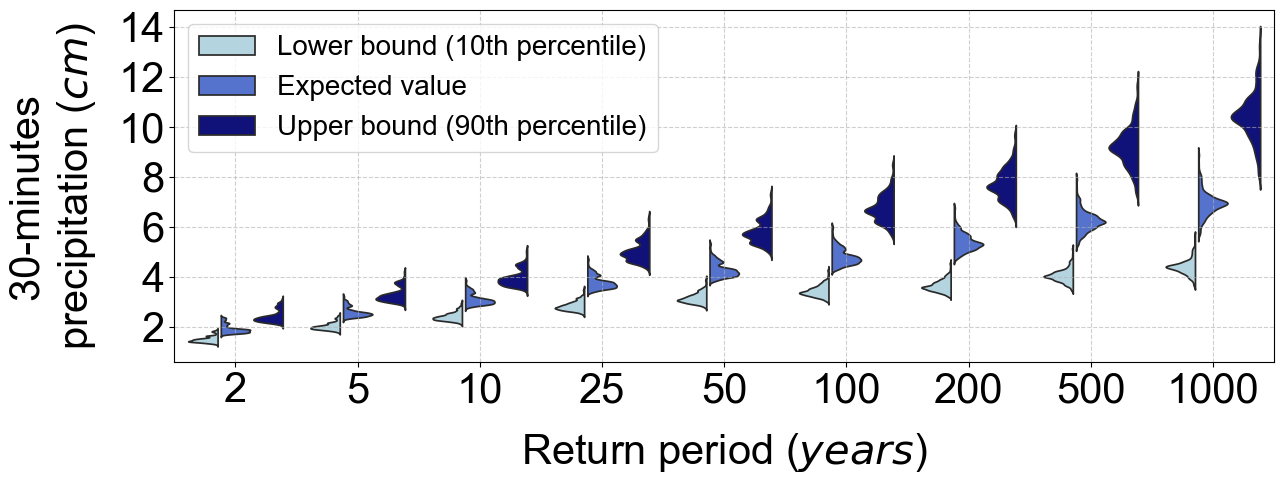

In [200]:
# Define colors for each category
custom_palette = {"hal": "lightblue", "Mean": "royalblue", "hau": "darkblue"}
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']

# Prepare long format dataframe for Seaborn
rain_data = []

# Assuming 'return_periods', 'durations', and 'bounds' are defined
for rain in return_periods:
    for duration in ['30m']:  # As you mentioned focusing on '5m' duration
        for bound in ['a', 'al', 'au']:
            column_name = f"rain_{rain}_{duration}_{bound}"

            # Determine the 'Type' for each bound
            pre = "hau" if bound == "au" else "hal" if bound == "al" else "Mean"

            # Add data for each value in the column
            for value in culvert[column_name]:
                rain_data.append({"Return Period": str(rain), "Rainfall (m)": value, "Type": pre})

# Convert to DataFrame
rain_long = pd.DataFrame(rain_data)

# Plot violin plot with custom colors
plt.figure(figsize=(13, 5))
sns.violinplot(
    x="Return Period", 
    y="Rainfall (m)", 
    hue="Type", 
    data=rain_long, 
    density_norm="width", 
    split=True,
    gap=0.1,
    dodge=True,
    inner=None, 
    palette=custom_palette, 
    hue_order=["hal", "Mean", "hau"]  # Ensuring "Mean" is in the middle
)

# Formatting
plt.xlabel(f"Return period ($years$)")
plt.ylabel(f"30-minutes cumulative \nprecipitation ($cm$)")

# Increase font sizes for labels and ticks
plt.xlabel("Return period ($years$)", fontsize=30, labelpad=15)
plt.ylabel("30-minutes  \nprecipitation ($cm$)", fontsize=30, labelpad=15)

# Increase x and y tick font sizes
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Improve legend
plt.legend(loc="upper left", labels=["Lower bound (10th percentile)", "Expected value", "Upper bound (90th percentile)"],fontsize=20)

# Add grid lines
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()

plt.savefig(r"D:\culvert repo\Results\Figures\rainfall_disturibution_culvert_30min_2_1000_All.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


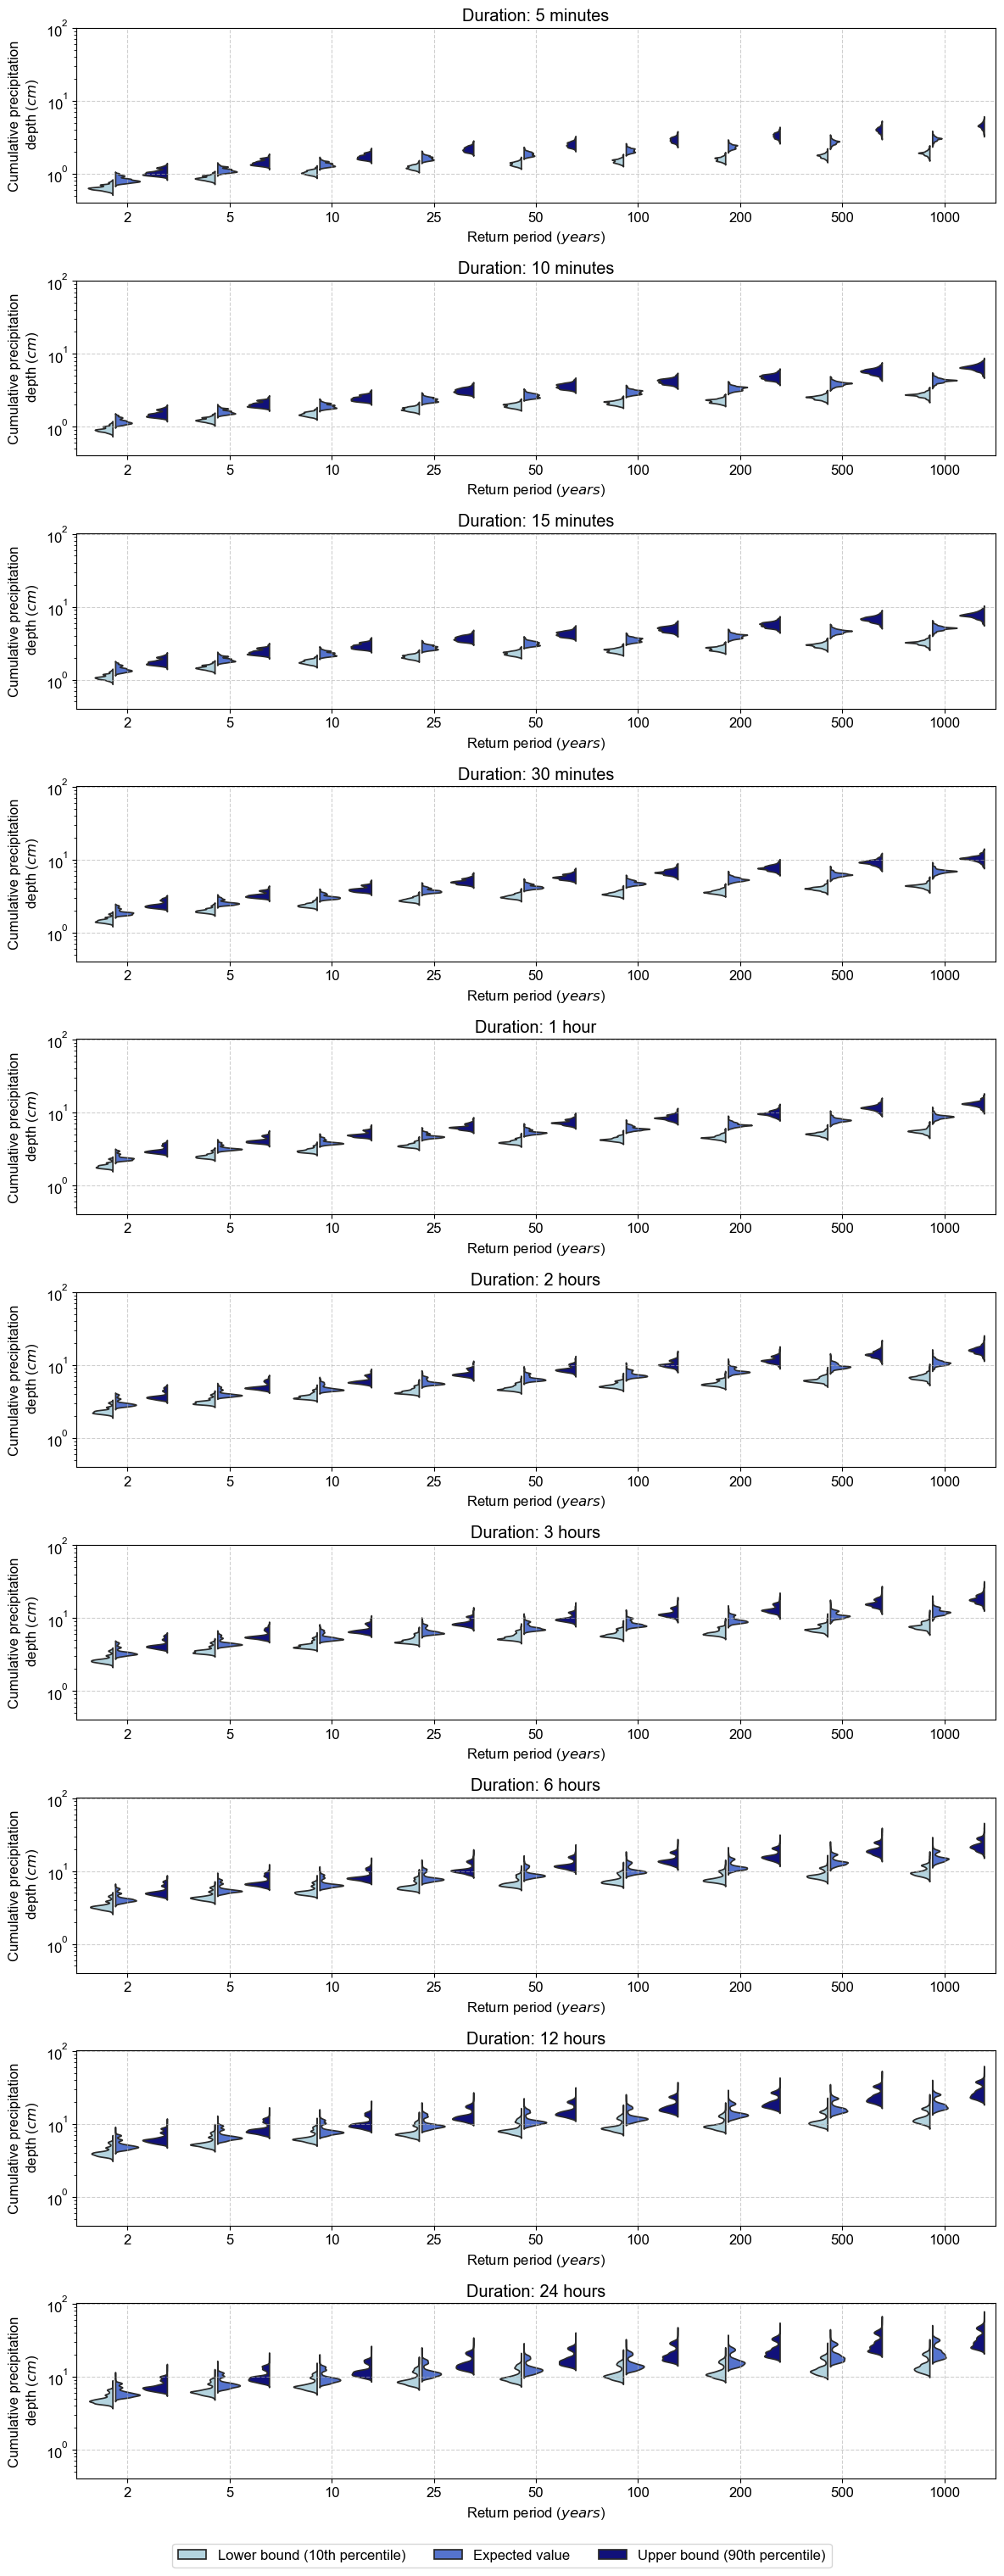

In [201]:
# Define colors for each category
custom_palette = {"hal": "lightblue", "Mean": "royalblue", "hau": "darkblue"}

# Create subplots with one row and as many columns as durations
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
duration_map = {
    '05m': '5 minutes',
    '10m': '10 minutes',
    '15m': '15 minutes',
    '30m': '30 minutes',
    '60m': '1 hour',
    '02h': '2 hours',
    '03h': '3 hours',
    '06h': '6 hours',
    '12h': '12 hours',
    '24h': '24 hours'
}
fig, axes = plt.subplots(len(durations), 1, figsize=(12, 3*len(durations)), sharey=True)

# Prepare long format dataframe for Seaborn
rain_data = []

for rain in return_periods:
    for duration in durations:
        for bound in ['a', 'al', 'au']:
            column_name = f"rain_{rain}_{duration}_{bound}"

            # Determine the 'Type' for each bound
            pre = "hau" if bound == "au" else "hal" if bound == "al" else "Mean"

            # Add data for each value in the column
            for value in culvert[column_name].dropna():
                rain_data.append({"Return Period": str(rain), "Rainfall (m)": value, "Type": pre, "Duration": duration})

# Convert to DataFrame
rain_long = pd.DataFrame(rain_data)

# Plotting each duration in a subplot
for idx, duration in enumerate(durations):
    ax = axes[idx]  # Get the subplot axis for the current duration
    
    # Filter data for the current duration
    rain_duration_data = rain_long[rain_long["Duration"] == duration]
    
    sns.violinplot(
        x="Return Period", 
        y="Rainfall (m)", 
        hue="Type", 
        data=rain_duration_data, 
        density_norm="area", 
        split=True,
        gap=0.1,
        inner=None, 
        palette=custom_palette, 
        hue_order=["hal", "Mean", "hau"],  # Ensuring "Mean" is in the middle
        ax=ax,  # Pass the current axis for plotting
        legend=False
    )
    
    # Formatting for each subplot
    ax.set_title(f"Duration: {duration_map[duration]}")
    ax.set_xlabel(f"Return period ($years$)")
    ax.set_ylabel(f"Cumulative precipitation\n depth ($cm$)")
    ax.set_yscale("log")
    ax.grid(True, linestyle="--", alpha=0.6)

# Improve legend and adjust layout
fig.legend(
    loc="lower center",
    labels=["Lower bound (10th percentile)", "Expected value", "Upper bound (90th percentile)"],
    ncol=3,
    bbox_to_anchor=(0.5, -0.015),
    frameon=True
)
plt.tight_layout()

# Save the figure
plt.savefig(r"D:\culvert repo\Results\Figures\rainfall_distribution_culvert_all_durations_2_1000_All.png", dpi=300)

# Show the plot
plt.show()


#### Sanity checks for applying the NRCS method

In [202]:
culvert.shape

(7136, 427)

In [203]:
culvert=culvert[culvert['t_c_CN_wet']>0.1]
culvert=culvert[culvert['CN_wet']>40]
culvert.shape

(6846, 427)

# Rain type 

In [204]:
# Compute the type of rainfall for each culvert 
cul_type_III_file_path=r"D:\culvert repo\data\Rainfall type III\culverts_rain_type_III.shp"
culvert_III = gpd.read_file(cul_type_III_file_path)
culvert_III_bins = set(culvert_III['BIN'])
# function to assign rain_type based on the BIN
def determine_rain_type(bin_value):
    if bin_value in culvert_III_bins:
        return "III"
    else:
        return "II"
# Apply the function to the data frame
culvert['rain_type'] = culvert['BIN'].apply(determine_rain_type)

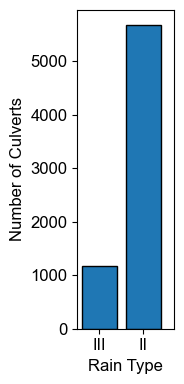

In [205]:
plt.figure(figsize=(2, 4))  # Set the figure size
# Plot the histogram
ax = culvert['rain_type'].hist(bins=2, grid=False, width=0.4, edgecolor='black')

# titles and labels
#plt.title('Histogram of Rain Types', fontsize=14)
plt.xlabel('Rain Type', fontsize=12)
plt.ylabel('Number of Culverts', fontsize=12)

rain_types = culvert['rain_type'].unique()
plt.xticks(ticks=[0.2, 0.7], labels=rain_types, ha='center')

# Show the plot
plt.tight_layout()
plt.show()

In [206]:
# time distribution for accumulated rainfall  
depths_II = [
    0.0000, 0.0010, 0.0020, 0.0030, 0.0041, 0.0051, 0.0062, 0.0072, 0.0083, 0.0094,
    0.0105, 0.0116, 0.0127, 0.0138, 0.0150, 0.0161, 0.0173, 0.0184, 0.0196, 0.0208,
    0.0220, 0.0232, 0.0244, 0.0257, 0.0269, 0.0281, 0.0294, 0.0306, 0.0319, 0.0332,
    0.0345, 0.0358, 0.0371, 0.0384, 0.0398, 0.0411, 0.0425, 0.0439, 0.0452, 0.0466,
    0.0480, 0.0494, 0.0508, 0.0523, 0.0538, 0.0553, 0.0568, 0.0583, 0.0598, 0.0614,
    0.0630, 0.0646, 0.0662, 0.0679, 0.0696, 0.0712, 0.0730, 0.0747, 0.0764, 0.0782,
    0.0800, 0.0818, 0.0836, 0.0855, 0.0874, 0.0892, 0.0912, 0.0931, 0.0950, 0.0970,
    0.0990, 0.1010, 0.1030, 0.1051, 0.1072, 0.1093, 0.1114, 0.1135, 0.1156, 0.1178,
    0.1200, 0.1222, 0.1246, 0.1270, 0.1296, 0.1322, 0.1350, 0.1379, 0.1408, 0.1438,
    0.1470, 0.1502, 0.1534, 0.1566, 0.1598, 0.1630, 0.1663, 0.1697, 0.1733, 0.1771,
    0.1810, 0.1851, 0.1895, 0.1941, 0.1989, 0.2040, 0.2094, 0.2152, 0.2214, 0.2280,
    0.2350, 0.2427, 0.2513, 0.2609, 0.2715, 0.2830, 0.3068, 0.3544, 0.4308, 0.5679,
    0.6630, 0.6820, 0.6986, 0.7130, 0.7252, 0.7350, 0.7434, 0.7514, 0.7588, 0.7656,
    0.7720, 0.7780, 0.7836, 0.7890, 0.7942, 0.7990, 0.8036, 0.8080, 0.8122, 0.8162,
    0.8200, 0.8237, 0.8273, 0.8308, 0.8342, 0.8376, 0.8409, 0.8442, 0.8474, 0.8505,
    0.8535, 0.8565, 0.8594, 0.8622, 0.8649, 0.8676, 0.8702, 0.8728, 0.8753, 0.8777,
    0.8800, 0.8823, 0.8845, 0.8868, 0.8890, 0.8912, 0.8934, 0.8955, 0.8976, 0.8997,
    0.9018, 0.9038, 0.9058, 0.9078, 0.9097, 0.9117, 0.9136, 0.9155, 0.9173, 0.9192,
    0.9210, 0.9228, 0.9245, 0.9263, 0.9280, 0.9297, 0.9313, 0.9330, 0.9346, 0.9362,
    0.9377, 0.9393, 0.9408, 0.9423, 0.9438, 0.9452, 0.9466, 0.9480, 0.9493, 0.9507,
    0.9520, 0.9533, 0.9546, 0.9559, 0.9572, 0.9584, 0.9597, 0.9610, 0.9622, 0.9635,
    0.9647, 0.9660, 0.9672, 0.9685, 0.9697, 0.9709, 0.9722, 0.9734, 0.9746, 0.9758,
    0.9770, 0.9782, 0.9794, 0.9806, 0.9818, 0.9829, 0.9841, 0.9853, 0.9864, 0.9876,
    0.9887, 0.9899, 0.9910, 0.9922, 0.9933, 0.9944, 0.9956, 0.9967, 0.9978, 0.9989,
    1.0000
]
# Provided 24-hour cumulative depths data
depths_III = np.array([
    0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110, 0.0120, 0.0130,
    0.0140, 0.0150, 0.0160, 0.0170, 0.0180, 0.0190, 0.0200, 0.0210, 0.0220, 0.0231, 0.0241, 0.0252, 0.0263, 0.0274,
    0.0285, 0.0296, 0.0308, 0.0319, 0.0331, 0.0343, 0.0355, 0.0367, 0.0379, 0.0392, 0.0404, 0.0417, 0.0430, 0.0443,
    0.0456, 0.0470, 0.0483, 0.0497, 0.0511, 0.0525, 0.0539, 0.0553, 0.0567, 0.0582, 0.0597, 0.0612, 0.0627, 0.0642,
    0.0657, 0.0673, 0.0688, 0.0704, 0.0720, 0.0736, 0.0753, 0.0770, 0.0788, 0.0806, 0.0825, 0.0844, 0.0864, 0.0884,
    0.0905, 0.0926, 0.0948, 0.0970, 0.0993, 0.1016, 0.1040, 0.1064, 0.1089, 0.1114, 0.1140, 0.1167, 0.1194, 0.1223,
    0.1253, 0.1284, 0.1317, 0.1350, 0.1385, 0.1421, 0.1458, 0.1496, 0.1535, 0.1575, 0.1617, 0.1659, 0.1703, 0.1748,
    0.1794, 0.1842, 0.1890, 0.1940, 0.1993, 0.2048, 0.2105, 0.2165, 0.2227, 0.2292, 0.2359, 0.2428, 0.2500, 0.2578,
    0.2664, 0.2760, 0.2866, 0.2980, 0.3143, 0.3394, 0.3733, 0.4166, 0.5000, 0.5840, 0.6267, 0.6606, 0.6857, 0.7020,
    0.7134, 0.7240, 0.7336, 0.7422, 0.7500, 0.7572, 0.7641, 0.7708, 0.7773, 0.7835, 0.7895, 0.7952, 0.8007, 0.8060,
    0.8110, 0.8158, 0.8206, 0.8252, 0.8297, 0.8341, 0.8383, 0.8425, 0.8465, 0.8504, 0.8543, 0.8579, 0.8615, 0.8650,
    0.8683, 0.8716, 0.8747, 0.8777, 0.8806, 0.8833, 0.8860, 0.8886, 0.8911, 0.8936, 0.8960, 0.8984, 0.9007, 0.9030,
    0.9052, 0.9074, 0.9095, 0.9116, 0.9136, 0.9156, 0.9175, 0.9194, 0.9212, 0.9230, 0.9247, 0.9264, 0.9280, 0.9296,
    0.9312, 0.9327, 0.9343, 0.9358, 0.9373, 0.9388, 0.9403, 0.9418, 0.9433, 0.9447, 0.9461, 0.9475, 0.9489, 0.9503,
    0.9517, 0.9530, 0.9544, 0.9557, 0.9570, 0.9583, 0.9596, 0.9609, 0.9621, 0.9634, 0.9646, 0.9658, 0.9670, 0.9682,
    0.9694, 0.9706, 0.9718, 0.9729, 0.9741, 0.9752, 0.9764, 0.9775, 0.9786, 0.9797, 0.9808, 0.9818, 0.9829, 0.9839,
    0.9850, 0.9860, 0.9870, 0.9880, 0.9890, 0.9900, 0.9909, 0.9919, 0.9928, 0.9938, 0.9947, 0.9956, 0.9965, 0.9974,
    0.9983, 0.9991, 1.0000
])

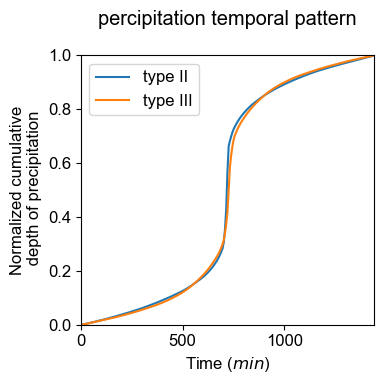

In [207]:
time = np.arange(1, len(depths_II) + 1)*6  # Create time array

plt.figure(figsize=(4, 4))
plt.plot(time, depths_II, label='type II', linestyle='-')
plt.plot(time, depths_III, label='type III', linestyle='-')
plt.xlabel(f'Time ($min$)')
plt.ylabel('Normalized cumulative\n depth of precipitation')
plt.xlim(0,24*60)
plt.ylim(0,1)
plt.title('percipitation temporal pattern\n')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\Raintype_II_III_temporal_pattern.png", dpi=300, bbox_inches='tight')
plt.show()

# Peak discharge calculation

In [208]:
def max_n_hr_rainfall(rain_type, interval_hours):
    """
    Finds the n-hour interval with the highest cumulative rainfall.
    Parameters:
    - depths_24hr (array-like): Cumulative depths for a 24-hour rainfall distribution.
    - total_hours (int): Total duration of the rainfall distribution, typically 24 hours.
    - interval_hours (int): Duration of the interval to find, typically 6 hours.
    Returns:
    - depths_6hr (np.array): Depths over the 6-hour interval with the highest rainfall.
    - start_time (float): Start time of the interval with the highest rainfall.
    """
   #############################################################     
    total_hours=24
    if rain_type=='II': 
        depths_24hr = np.array(depths_II)
    else:
        depths_24hr = np.array(depths_III)
   #############################################################
    if interval_hours<0.5:
        # Time interval for original depths_II is 6 minutes, so generate time points
        time_6min = np.arange(0, len(depths_24hr) * 6, 6)
        
        # Interpolating depths for every 5 minutes
        interp_func = interp1d(time_6min, depths_24hr, kind='linear')
        time_5min = np.arange(0, time_6min[-1] + 1, 5)
        depths_24hr = interp_func(time_5min)
    #############################################################
    time_24hr = np.linspace(0, total_hours, len(depths_24hr))
    interval_steps = int(interval_hours * len(time_24hr) / total_hours)+2
    max_depth = 0
    start_index = 0
    for i in range(len(depths_24hr) - interval_steps):
        current_depth = depths_24hr[i + interval_steps] - depths_24hr[i]
        if current_depth > max_depth:
            max_depth = current_depth
            start_index = i
    depths_6hr = depths_24hr[start_index+1:start_index + interval_steps]
    depths_nhr= (depths_6hr - depths_6hr.min()) / (depths_6hr.max() - depths_6hr.min())
    start_time = time_24hr[start_index]
    return depths_nhr
# Call the function
#depth= max_n_hr_rainfall(rain_type='II',interval_hours=0.1667)
#print("Depths in this interval:", depth)

In [209]:
def incremental_rainfall(cumulative_rainfall):
    """
    Calculate incremental rainfall from cumulative rainfall data.
    Parameters:
    - cumulative_rainfall (array-like): Array of cumulative rainfall depths.
    Returns:
    - incremental_rainfall (np.array): Array of incremental rainfall depths.
    """
    cumulative_rainfall = np.array(cumulative_rainfall)
    incremental_rain = np.diff(cumulative_rainfall, prepend=0)  # Set the first increment to the first cumulative depth
    return incremental_rain

In [210]:
normalized_intervals = {}


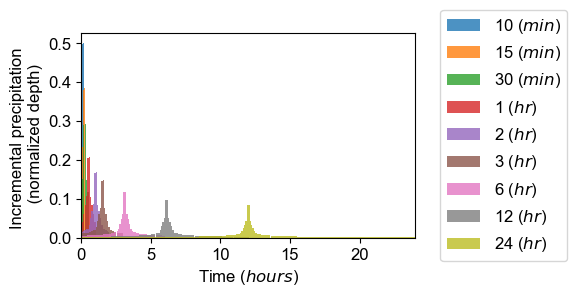

In [211]:
# Define intervals in hours
intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
# Store results
normalized_intervals = {}
# Compute and normalize rainfall for each interval
for interval in intervals:
    normalized_intervals[interval] = incremental_rainfall(
        max_n_hr_rainfall(rain_type=culvert.rain_type[0], interval_hours=interval)
    )
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))  # Increase width to accommodate legend
# Plot each interval
for interval, depths in normalized_intervals.items():
    label = f"{int(interval * 60)} ($min$)" if interval < 1 else f"{interval} ($hr$)"
    ax.bar(np.linspace(0, interval, len(depths)), depths, width=interval/len(depths), label=label,alpha=0.8)
# Set labels and limits
ax.set_xlabel(f"Time ($hours$)")
ax.set_ylabel("Incremental precipitation \n (normalized depth)")
ax.set_xlim(0, 24)
# Move legend outside, right, and vertically centered
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
# Save the figure
plt.savefig(r'D:\culvert repo\Results\Figures\normalized_temporal_incremental_rainfall_normalized_depths_typeII_ALL.png', 
            dpi=300, bbox_inches='tight')
plt.show()

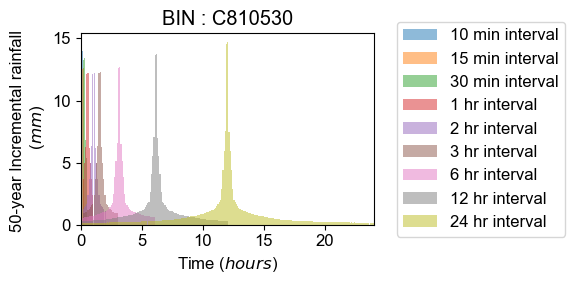

In [212]:
intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
depth = [
    culvert.rain_50_10m_a[0], culvert.rain_50_15m_a[0], culvert.rain_50_30m_a[0],
    culvert.rain_50_60m_a[0], culvert.rain_50_02h_a[0], culvert.rain_50_03h_a[0],
    culvert.rain_50_06h_a[0], culvert.rain_50_12h_a[0], culvert.rain_50_24h_a[0]
]
# Store results
normalized_intervals = {}
# Compute and normalize rainfall for each interval
for idx, interval in enumerate(intervals):
    rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type[0], interval_hours=interval) * depth[idx] * 10
    normalized_intervals[interval] = incremental_rainfall(rainfall)
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))  # Increase width to accommodate legend
# Plot each interval
for interval, depths in normalized_intervals.items():
    label = f"{int(interval * 60)} min interval" if interval < 1 else f"{interval} hr interval"
    ax.bar(np.linspace(0, interval, len(depths)), depths,width=interval/len(depths), label=label,alpha=0.5)
# Set labels and limits
ax.set_xlim(0, 24)
ax.set_xlabel(f"Time ($hours$)")
ax.set_ylabel(f"50-year Incremental rainfall \n ($mm$)")
ax.set_title(f"BIN : {culvert.BIN[0]}")
# Move legend outside, right, and vertically centered
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
# Save the figure
plt.savefig(r'D:\culvert repo\Results\Figures\temporal_incremental_rainfall_depths_culv_1_ALL.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [213]:
def calculate_excess_rainfall(rainfall_array, CN):
    # Curve number and initial abstraction calculations
    S = (25400 / CN) - 254
    I_default = 0.2 * S
    
    if len(rainfall_array)<6: 
        time_step=5 
    else: 
        time_step=6
    # Create a DataFrame with incremental depths (rainfall every 6 minutes)
    df = pd.DataFrame({
        'Time': np.arange(0, len(rainfall_array)*time_step, time_step),
        'Incremental Depths (mm)': rainfall_array
    })
    
    # Add the 'Cumulative Rainfall' column
    df['Cumulative Rainfall (mm)'] = df['Incremental Depths (mm)'].cumsum()
    
    # Calculate the 'Ia' (Initial Abstraction)
    df['Ia'] = df['Cumulative Rainfall (mm)'].apply(lambda P: min(P, I_default))
    
    # Calculate the 'Fa' (Fraction of Runoff) only when runoff occurs
    df['Fa'] = np.where(df['Cumulative Rainfall (mm)'] > df['Ia'],
                        (S * (df['Cumulative Rainfall (mm)'] - df['Ia'])) / 
                        (df['Cumulative Rainfall (mm)'] - df['Ia'] + S), 0) 
    
    # Calculate the 'Pe' (Excess Precipitation)
    df['Pe'] = np.maximum(df['Cumulative Rainfall (mm)'] - df['Ia'] - df['Fa'], 0)

    
    # Incremental Excess (difference in excess precipitation)
    df['Incremental Excess (mm)'] = df['Pe'].diff().fillna(df['Pe'])  # For the first value, just take 'Pe'
    
    return df

In [214]:
def construct_unit_hydrograph(tc, A, tr, time_step):
    """
    Constructs a unit hydrograph based on the given parameters.
    
    Parameters:
    tc (float): Time of concentration (in hours).
    A (float): Catchment area (in square kilometers).
    tr (float): Duration of excessive rainfall (in hours, default is 0.1 hour or 6 minutes).
    
    Returns:
    tuple: Time intervals (hours), discharge values (m³/s) at each interval, and the plot.
    """
    # Calculate parameters
    tp = 0.6 * tc  # Time to peak
    Tp = (tr / 2) + tp  # Time to peak of the unit hydrograph
    qp = 0.208 * A / Tp  # Peak discharge (m³/s)
    base = 2.67 * Tp  # Duration of the unit hydrograph
    
    # Calculate the slope of the second line of the triangle
    slope_second = (0 - qp) / (base - Tp)
    
    # Define the 6-minute intervals (converted to hours)
    intervals_in_hours = np.arange(0, base, time_step / 60)  # Time in hours for 6-minute intervals
    
    # Initialize a list to store discharge values at 6-minute intervals
    discharge_values = []

    # Calculate discharge for the unit hydrograph at each 6-minute interval
    for t in intervals_in_hours:
        if t <= Tp:
            discharge_values.append((qp / Tp) * t)  # Linear increase until Tp
        else:
            discharge_values.append(qp + slope_second * (t - Tp))  # Linear decrease after Tp
    
    # Plot the unit hydrograph
    time = np.linspace(0, base, 100)
    discharge = np.zeros_like(time)

    for i, t in enumerate(time):
        if t <= Tp:
            discharge[i] = (qp / Tp) * t  # Linear increase until Tp
        else:
            discharge[i] = qp + slope_second * (t - Tp)  # Linear decrease after Tp
    return intervals_in_hours, discharge_values

# Example usage with your culvert data
intervals, discharge_values = construct_unit_hydrograph(culvert.t_c_CN_wet[0], culvert.Area[0] / 10**6, 6 / 60, 6)


In [215]:
def calculate_total_discharge(df, unit_hydrograph):
    if len(df)<6:
        time_step=5
    else:
        time_step=6
    """
    Calculate the total discharge at each time step by applying the unit hydrograph
    to the incremental excess rainfall data.
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Time' and 'Incremental Excess (mm)' columns.
    unit_hydrograph (numpy.array): Array of unit hydrograph values for each time step.
    Returns:
    pandas.DataFrame: DataFrame with time steps, individual discharge values, and total discharge.
    """
    # Initialize a zero matrix for discharges, based on the number of time steps and unit hydrograph length
    discharge_matrix = np.zeros((len(df['Time']) + len(unit_hydrograph), len(df['Incremental Excess (mm)'])))
    # Loop through each Incremental Excess rainfall and calculate the discharge for each time step
    for idx, row in df.iterrows():
        # Multiply the Unit Hydrograph by the Incremental Excess value
        excess_rainfall = row['Incremental Excess (mm)']
        discharge_values = unit_hydrograph * excess_rainfall*(1/3.6)  # Multiply each Unit Hydrograph value by the Excess Rainfall
        # Find the start index where the rainfall begins (this corresponds to the current time step)
        start_idx = int(row['Time'] // time_step)  # Convert time step (in minutes) to the index (since it's a 6-minute interval)
        # Insert the discharge values starting from the corresponding time step
        discharge_matrix[start_idx:start_idx+len(unit_hydrograph), idx] = discharge_values
    # Create a DataFrame for the discharges
    discharge = pd.DataFrame(discharge_matrix, columns=[f'Discharge_{i+1}' for i in range(len(df['Incremental Excess (mm)']))])
    # Add the Time column to the DataFrame
    discharge['Time'] = np.concatenate([df['Time'], [df['Time'].iloc[-1] + time_step * (i+1) for i in range(len(unit_hydrograph))]])
    # Calculate the sum of discharges at each time step to get the total discharge
    discharge['Total Discharge'] = discharge.iloc[:, :-1].sum(axis=1)
    return discharge

In [216]:
culvert.BIN[0]

'C810530'

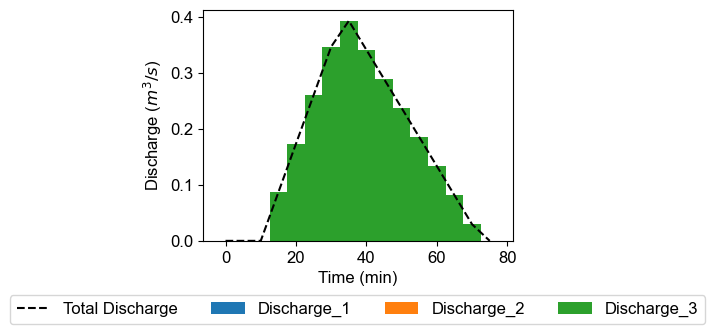

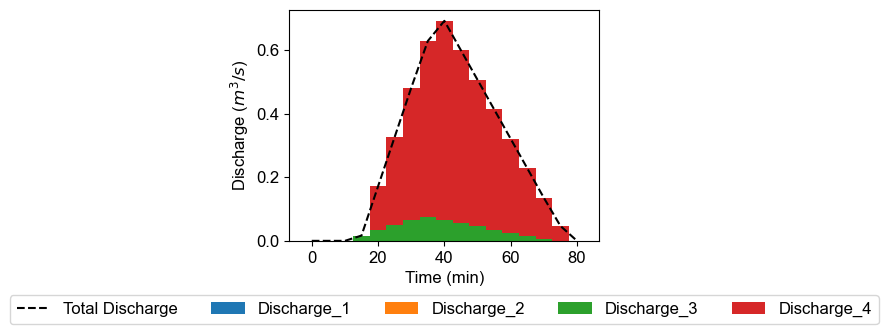

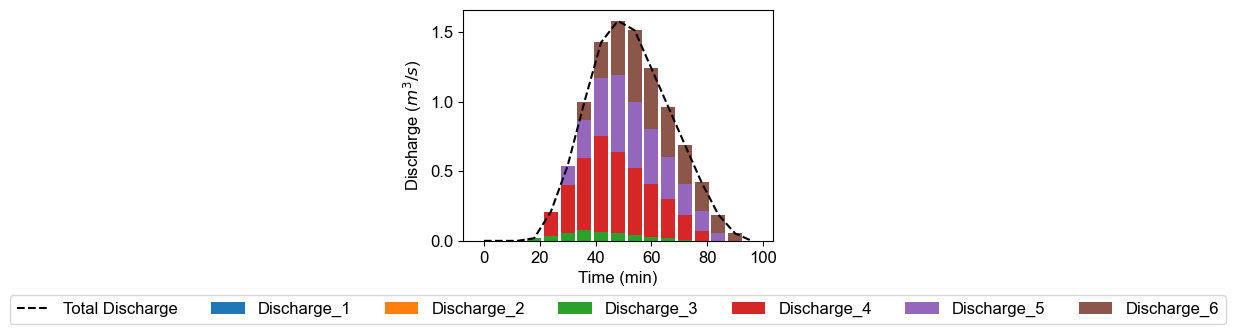

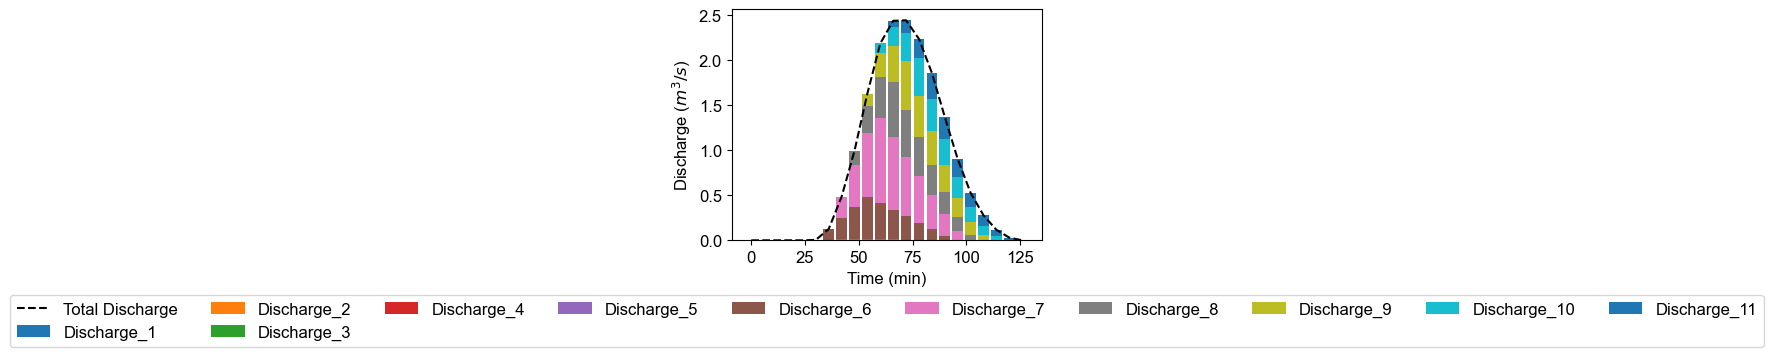

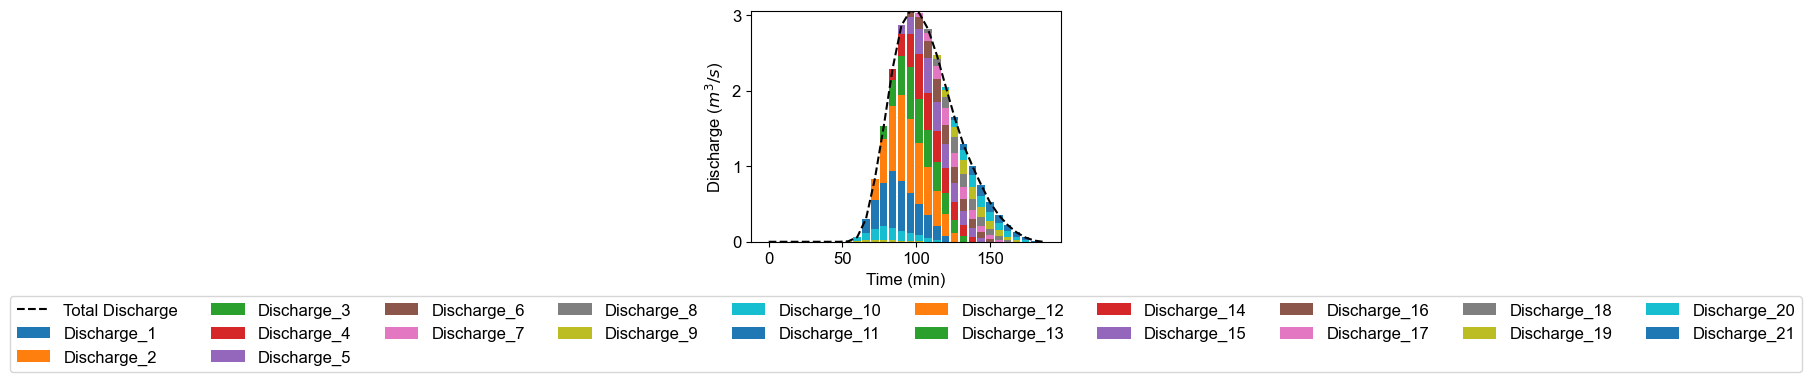

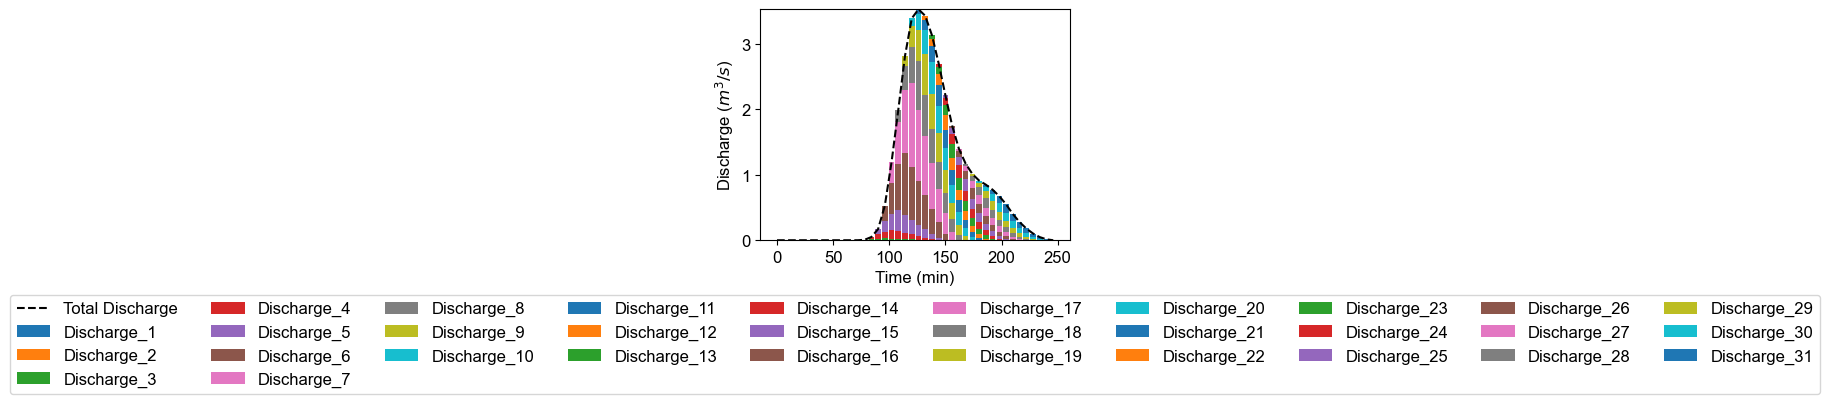

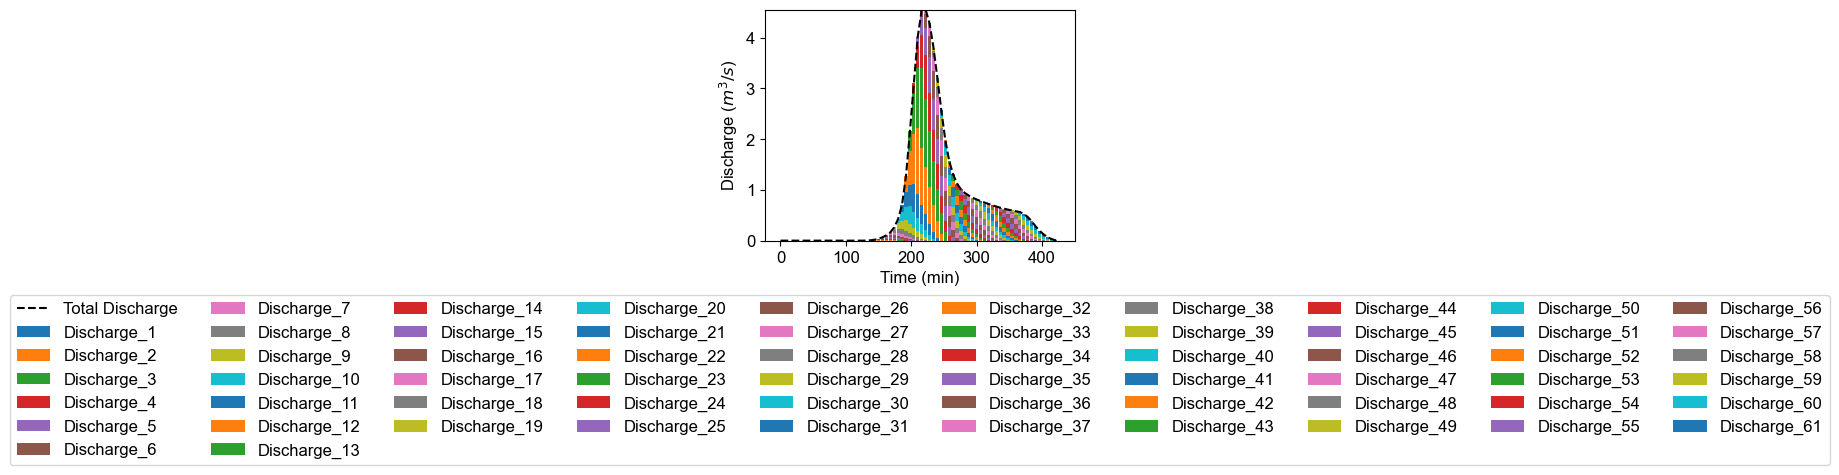

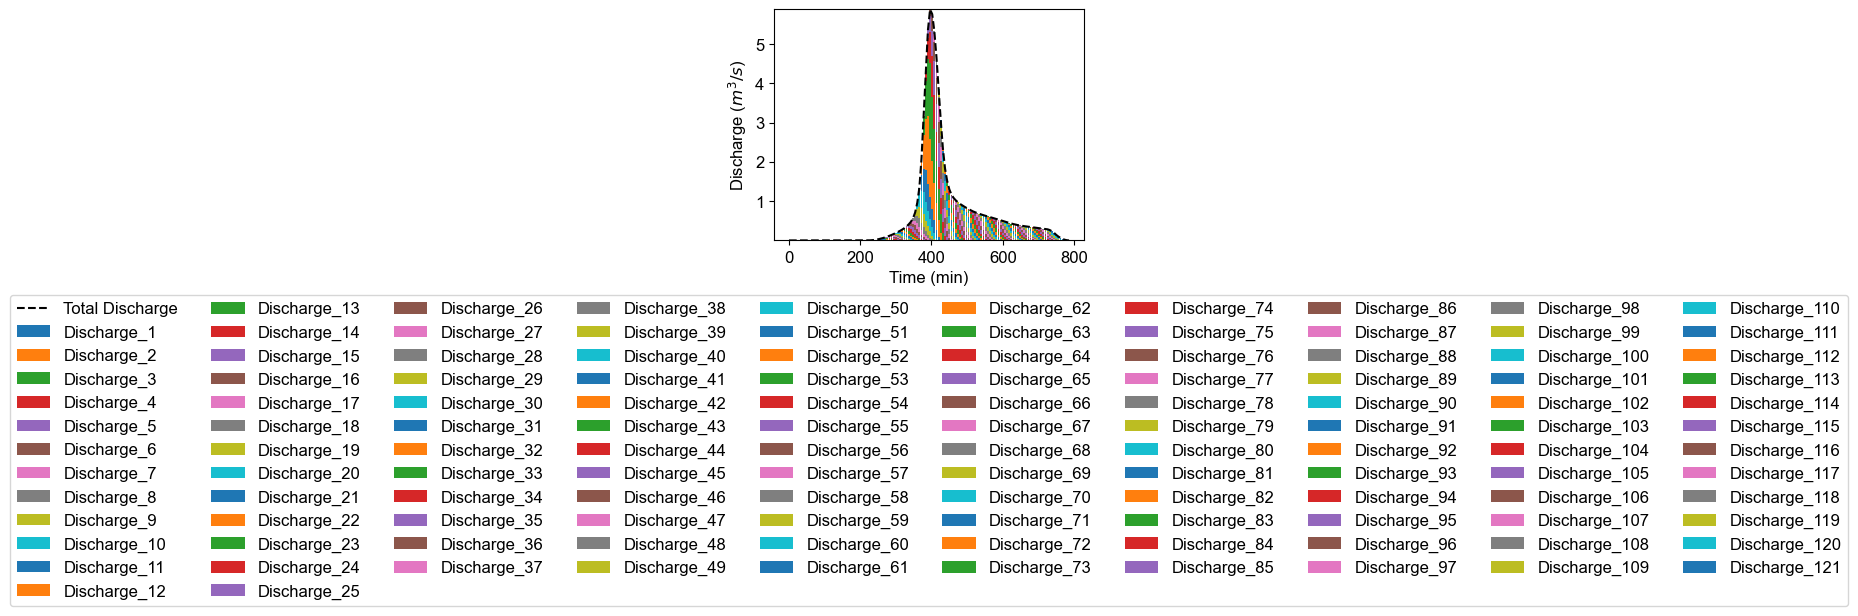

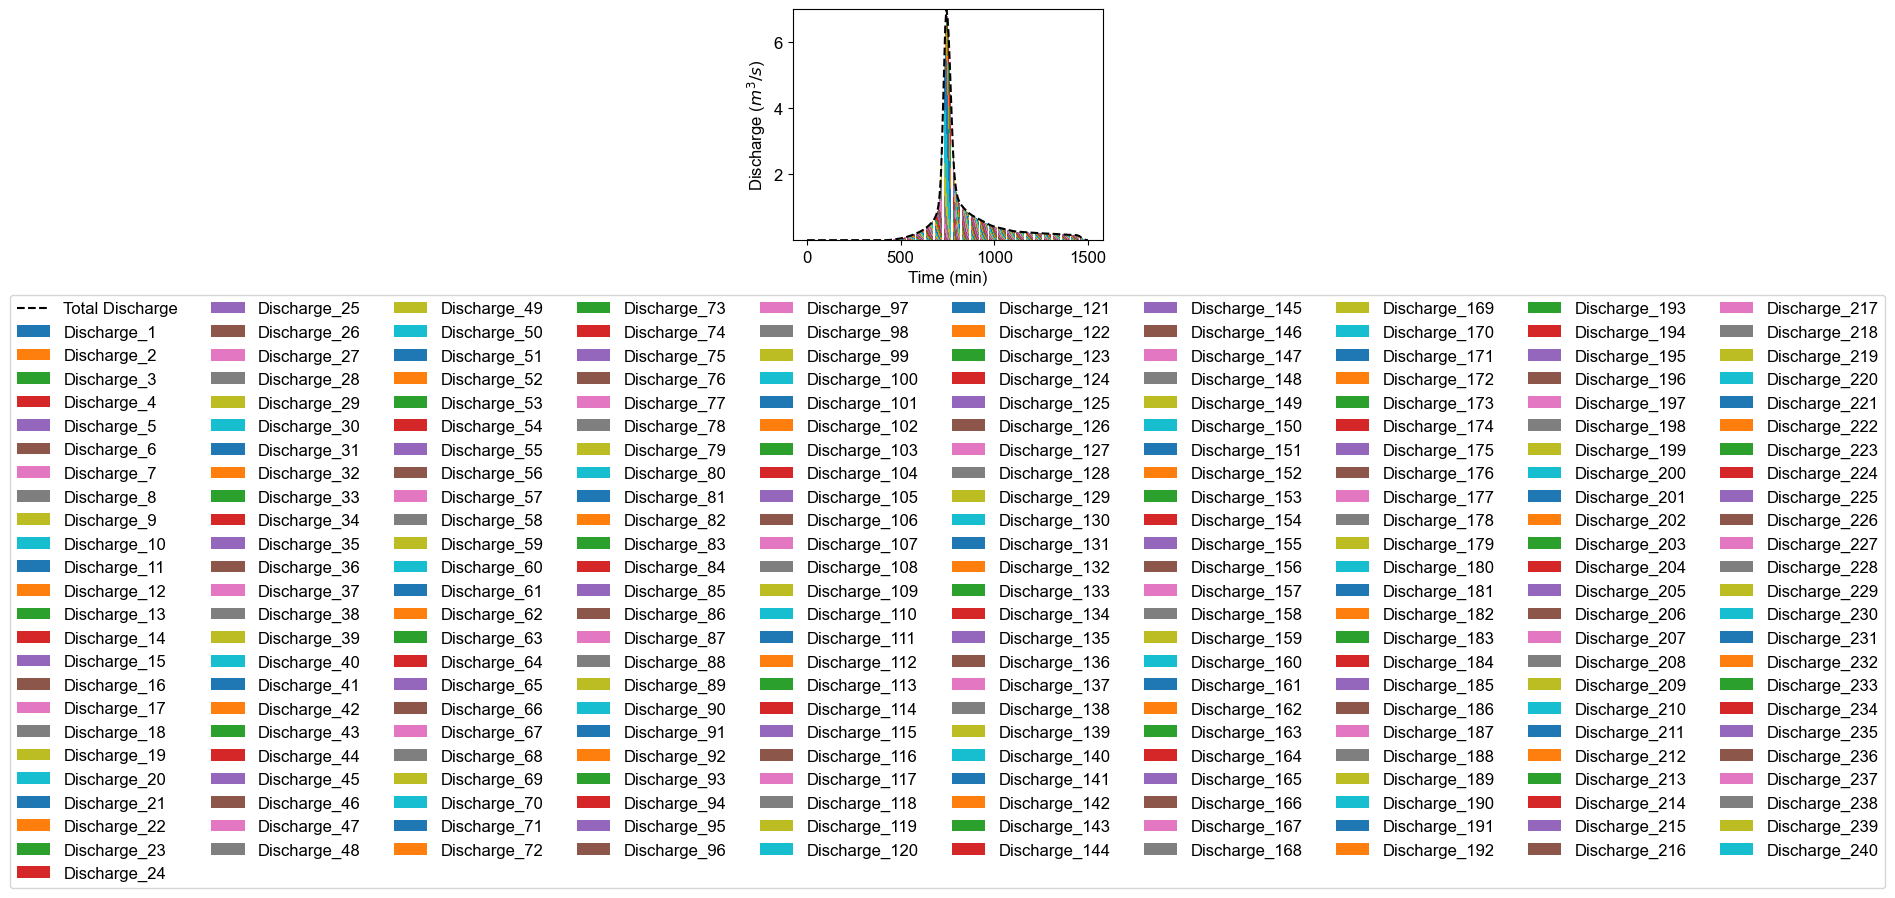

In [217]:
# List of intervals
intervals = [0.1667,0.25,0.5, 1, 2, 3, 6, 12, 24]
return_period=[2,5,10,25,50,100,200,500,1000]
max_dis=0
# Loop through each interval
for interval in intervals:
    # Example rainfall data for each interval (replace with actual data)
    incremental_depths_new = normalized_intervals[interval]
    # Calculate the excess rainfall for each interval
    result_df = calculate_excess_rainfall(incremental_depths_new,CN=culvert.CN[0])
    # Correct way to select columns from the result_df DataFrame
    data = result_df[['Time', 'Incremental Excess (mm)']]
    df = pd.DataFrame(data)
    #print(result_df)
    # Example Unit Hydrograph values (replace with your actual unit hydrograph values)
    if interval<0.5:
        time_step=5
    else:
        time_step=6
    intervals_1, discharge_values = construct_unit_hydrograph(culvert.t_c_CN_wet[0], culvert.Area[0]/10**6,time_step/60,time_step)
    unit_hydrograph = np.array(discharge_values)  # Example unit hydrograph values
    # Calculate the total discharge for this interval
    discharge = calculate_total_discharge(df, unit_hydrograph)
    #print(len(df))
    # Ensure discharge is a DataFrame and get the 'Total Discharge' column
    total_discharge = discharge['Total Discharge']
    # Find the time of maximum discharge
    max_discharge_index = total_discharge.idxmax()
    max_discharge_row = discharge.iloc[max_discharge_index]
    #print(max_discharge_row)
    # Check if the third-to-last element is non-zero
    if max_discharge_row[-3] != 0:
        max_dis = max_discharge_row[-1]
    # Plotting
    plt.figure(figsize=(4, 3))
    # Plot stacked bars for each discharge
    bottom_values = np.zeros(len(discharge))  # Start from zero for the first stack
    for col in discharge.columns[:-2]:  # Exclude Time and Total Discharge columns
        plt.bar(discharge['Time'], discharge[col], bottom=bottom_values, label=col, width=5)
        bottom_values += discharge[col]
    # Plot total discharge line
    plt.plot(discharge['Time'], discharge['Total Discharge'], color='black', linestyle='--', label='Total Discharge')
    # Add labels and title
    plt.xlabel('Time (min)')
    plt.ylabel('Discharge ($m^3/s$)')
    #plt.title(f'Stacked Contribution of Each Incremental Discharge to Total Discharge for Interval {interval} hrs')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=10)
    plt.savefig(rf'D:\culvert repo\Results\Figures\UH\{interval}.png',bbox_inches='tight',dpi=300)
    # Show the plot for the current interval
    plt.show()
#print("Max Discharge:", max_dis)

In [252]:
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize a dictionary to store the max discharge for each return period
    max_discharges = {}
    max_discharge_interval = {}
    max_dis = 0  # insures that the discharges of higher periods are increasing
    best_interval = None # To track the interval generating max discharge
    # Iterate over each return period
    for period in return_periods:
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_a'),
                getattr(culvert, f'rain_{period}_15m_a'),
                getattr(culvert, f'rain_{period}_30m_a'),
                getattr(culvert, f'rain_{period}_60m_a'),
                getattr(culvert, f'rain_{period}_02h_a'),
                getattr(culvert, f'rain_{period}_03h_a'),
                getattr(culvert, f'rain_{period}_06h_a'),
                getattr(culvert, f'rain_{period}_12h_a'),
                getattr(culvert, f'rain_{period}_24h_a')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert.CN_wet)
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                culvert.t_c_CN_wet, culvert.Area / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if max_discharge_row[-3] != 0 and max_discharge_row[-1] > max_dis:
                max_dis = max_discharge_row[-1]
                best_interval = interval
        # Store the max discharge for this return period in the dictionary
        max_discharges[f'Q_{period}'] = max_dis
        max_discharge_interval[f'Q_{period}_interval'] = best_interval
    return {**max_discharges, **max_discharge_interval}
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]

def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 6732/6732 [42:40<00:00,  2.63it/s]


In [257]:
culvert[['BIN','CN_wet','t_c_CN_wet','Q_2','Q_5','Q_10','Q_2_interval','Q_5_interval','Q_10_interval']]

BIN     CN_wet  t_c_CN_wet       Q_2        Q_5       Q_10  \
0     C810530  88.865546    0.584265  1.180954   2.098554   2.859517   
1     C810540  87.919123    0.456780  0.962545   1.714827   1.771587   
2     C810550  86.932914    0.707135  1.476743   2.773433   3.877303   
3     C810541  84.496922    1.962409  4.449262   7.983026  10.947065   
4     C810570  88.782258    1.407035  6.722794  11.201140  14.848567   
...       ...        ...         ...       ...        ...        ...   
6727  C520244  89.608556    0.875307  1.311282   2.244282   3.014911   
6728  C520245  89.611712    1.145570  2.139057   3.662667   4.941855   
6729  C520214  91.088342    1.122439  1.681981   2.794377   3.701131   
6730  C520247  90.657156    1.234369  3.543257   5.927973   7.878054   
6731  C520248  91.160196    0.791221  1.950984   3.243569   4.295320   

      Q_2_interval  Q_5_interval  Q_10_interval  
0              1.0           1.0            1.0  
1              1.0           1.0            0.5  
2              1.0           1.0            1.0  
3              3.0           3.0            3.0  
4              2.0           2.0            2.0  
...            ...           ...            ...  
6727           1.0           1.0            1.0  
6728           1.0           1.0            1.0  
6729           1.0           1.0            1.0  
6730           1.0           1.0            1.0  
6731           1.0           1.0            1.0  

[6732 rows x 9 columns]

In [ ]:
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
for rp in return_period: 
    culvert = culvert.drop([f'Q_{rp}', f'Q_{rp}_interval',f'Q_UL_{rp}',f'Q_LL_{rp}'], axis=1)

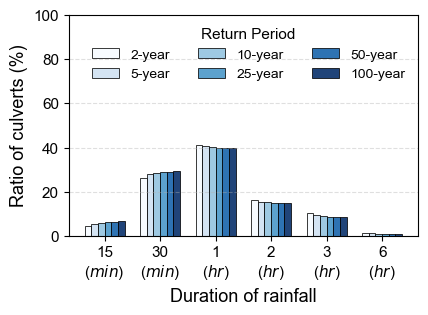

In [254]:
# Font setup (optional, publication style)
plt.rc('font', family='Arial', size=14)

# Duration values (in hours) and their display labels
duration_categories = [0.25, 0.5, 1, 2, 3, 6]
duration_labels = ['15\n($min$)','30\n($min$)', '1\n($hr$)', '2\n($hr$)','3\n($hr$)', '6\n($hr$)']
n_durations = len(duration_categories)

# Return period columns and labels
q_cols = [
    'Q_2_interval', 'Q_5_interval', 'Q_10_interval',
    'Q_25_interval', 'Q_50_interval', 'Q_100_interval'
]
legend_labels = {
    'Q_2_interval': '2-year',
    'Q_5_interval': '5-year',
    'Q_10_interval': '10-year',
    'Q_25_interval': '25-year',
    'Q_50_interval': '50-year',
    'Q_100_interval': '100-year'
}

# Use Blues colormap
cmap = cm.get_cmap('Blues', len(q_cols))
colors = [cmap(i) for i in range(len(q_cols))]

# Plot setup
bar_width = 0.12
x = np.arange(n_durations)

plt.figure(figsize=(6*0.75, 4.5*0.75))

for i, (col, color) in enumerate(zip(q_cols, colors)):
    data = culvert[col].dropna()
    total = len(data)
    counts = [np.sum(data == dur) / total * 100 for dur in duration_categories]
    offset = (i - len(q_cols)/2) * bar_width + bar_width / 2
    plt.bar(
        x + offset, counts, width=bar_width, 
        label=legend_labels[col], alpha=0.9,
        edgecolor='black', linewidth=0.6, color=color
    )

# Axis formatting
plt.xticks(ticks=x, labels=duration_labels, fontsize=11)
plt.xlabel('Duration of rainfall', fontsize=13)
plt.ylabel('Ratio of culverts (%)', fontsize=13)
plt.yticks(fontsize=11)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Legend formatting
plt.legend(title='Return Period', fontsize=10, title_fontsize=11, ncol=3, loc='upper right', frameon=False)

# Layout and export
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\Grouped_Bar_RainDuration_Percent_All.png', dpi=300, bbox_inches='tight')
plt.show()

# compare with hydraulic capacity

In [ ]:
# merge with hydraulic capacity dataset
file_path =r'D:\culvert repo\Results\Hydraulic analysis\hydraulic_analysis.xlsx'
culvert_df = pd.read_excel(file_path)
culvert_df.head()

In [268]:
culvert = culvert.drop(
    columns=['REGION', 'FUNCTIONAL CLASSIFICATION', 'COUNTY', 'YEAR BUILT',
             'DESIGN TYPE', 'Q', 'average_Q_maxhw'],
    errors='ignore'  # avoids errors if any column is missing
)


In [269]:
culvert_df = culvert_df.drop_duplicates(subset=['BIN'])
#merged_culvert = pd.merge(culvert, culvert_df[['BIN', 'Q','MAXIMUM SPAN LENGTH (FT)','Height','max_HW_D','DESIGN TYPE','C','y','cul_S105']], on='BIN', how='inner')
merged_culvert = culvert.merge(culvert_df[['BIN','REGION','FUNCTIONAL CLASSIFICATION','COUNTY','YEAR BUILT','DESIGN TYPE', 'Q','average_Q_maxhw']], on='BIN', how='inner')
# Convert 'Q' column to cubic meters per second (m³/s)
merged_culvert['Q'] = merged_culvert['Q'] * 0.0283168
merged_culvert['average_Q_maxhw'] = merged_culvert['average_Q_maxhw'] * 0.0283168
merged_culvert.shape

(6732, 456)

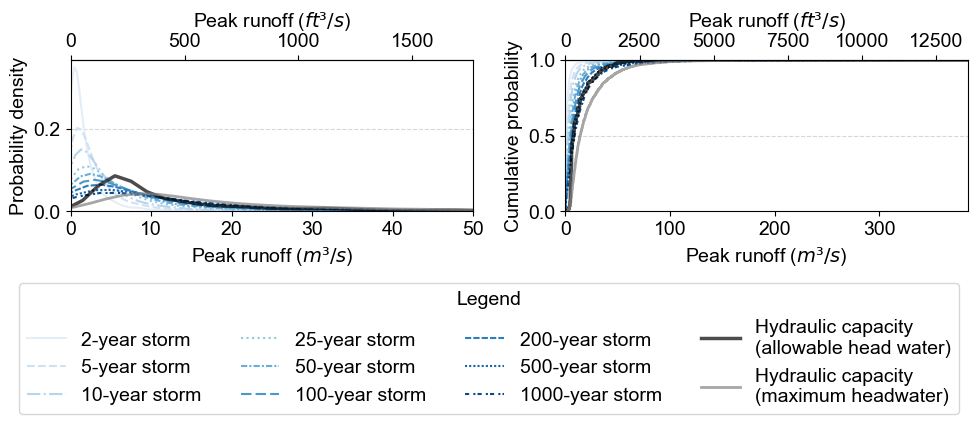

In [270]:
df_qp = merged_culvert[
    ['Q_2', 'Q_5', 'Q_10', 'Q_25', 'Q_50', 'Q_100', 'Q_200', 'Q_500', 'Q_1000', 'Q','average_Q_maxhw']
].dropna()
# labels mapping
label_mapping = {
    'Q_2': '2-year storm',
    'Q_5': '5-year storm',
    'Q_10': '10-year storm',
    'Q_25': '25-year storm',
    'Q_50': '50-year storm',
    'Q_100': '100-year storm',
    'Q_200': '200-year storm',
    'Q_500': '500-year storm',
    'Q_1000': '1000-year storm',
    'Q': 'Hydraulic capacity\n(allowable head water)',
    'average_Q_maxhw': f'Hydraulic capacity \n(maximum headwater)'
}
# Define color scheme
return_periods = ['Q_2', 'Q_5', 'Q_10', 'Q_25', 'Q_50', 'Q_100', 'Q_200', 'Q_500', 'Q_1000']
colors = sns.color_palette("Blues", n_colors=len(return_periods))  # Gradual blue shades
# Define line styles
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 3, 1)), (0, (1, 1, 1, 1)), (0, (2, 2, 1, 1))]  # Different line styles
# Ensure there are enough colors and line styles for all columns
extra_colors = sns.color_palette("Set2", n_colors=(df_qp.shape[1] - len(colors))) 
extra_linestyles = ['-' for _ in range(df_qp.shape[1] - len(linestyles))] 
colors.extend(extra_colors)
linestyles.extend(extra_linestyles)

# Create the figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
# KDE
for i, column in enumerate(df_qp.columns):
    data = df_qp[column].dropna()
    label = label_mapping[column]
    if column == 'Q':
        sns.kdeplot(data, ax=axs[0], label=label, color='black', linewidth=2.5, alpha=0.7) 
    elif column == 'average_Q_maxhw':
        sns.kdeplot(data, ax=axs[0], label=label, color='gray', linewidth=2, alpha=0.7) 
    else:
        sns.kdeplot(data, ax=axs[0], label=label, color=colors[i], linewidth=1.5, linestyle=linestyles[i])
axs[0].set_xlabel(f'Peak runoff ($m³/s$)')
axs[0].set_ylabel('Probability density')
axs[0].set_xlim(left=0, right=50)
axs[0].grid(axis='y', which='major', linestyle="--", alpha=0.5)
# Add secondary x-axis (ft³/s) to KDE
secax0 = axs[0].secondary_xaxis('top', functions=(lambda x: x * 35.3147, lambda x: x / 35.3147))
secax0.set_xlabel(f'Peak runoff ($ft³/s$)')

# ECDF plots
for i, column in enumerate(df_qp.columns):
    data = df_qp[column].dropna()
    label = label_mapping[column]
    if column == 'Q':
        sns.ecdfplot(data, ax=axs[1], label=label, color='black', linewidth=2.5, alpha=0.7) 
        qmax = data.max()
    elif column == 'average_Q_maxhw':
        sns.ecdfplot(data, ax=axs[1], label=label, color='gray', linewidth=2, alpha=0.7)
    else:
        sns.ecdfplot(data, ax=axs[1], label=label, color=colors[i], linewidth=1.5, linestyle=linestyles[i])
axs[1].set_xlabel(f'Peak runoff ($m³/s$)')
axs[1].set_ylabel('Cumulative probability')
axs[1].set_xlim(left=0, right=qmax)
axs[1].grid(axis='y', which='major', linestyle="--", alpha=0.5)
# Add secondary x-axis (ft³/s) to ECDF
secax1 = axs[1].secondary_xaxis('top', functions=(lambda x: x * 35.3147, lambda x: x / 35.3147))
secax1.set_xlabel(f'Peak runoff ($ft³/s$)')

# Adjust layout
plt.tight_layout()
# Add the legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Legend", loc="lower center", bbox_to_anchor=(0.5, -0.45), ncol=4)
# Save and show the figure
plt.savefig(r'D:\culvert repo\Results\Figures\Peak_Runoff_and_Capacity_ECDF_all.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

In [271]:
def assign_exeedance_prob(row):
    if row['Q'] < row['Q_2']:
        return 1/2
    elif row['Q'] < row['Q_5']:
        return 1/5
    elif row['Q'] < row['Q_10']:
        return 1/10
    elif row['Q'] < row['Q_25']:
        return 1/25
    elif row['Q'] < row['Q_50']:
        return 1/50
    elif row['Q'] < row['Q_100']:
        return 1/100
    elif row['Q'] < row['Q_200']:
        return 1/200
    elif row['Q'] < row['Q_500']:
        return 1/500
    elif row['Q'] < row['Q_1000']:
        return 1/1000
    else:
        return 1/2000  # If Q is not less than any of the rain periods
# Apply the function to each row
merged_culvert['exeedance_prob'] = merged_culvert.apply(assign_exeedance_prob, axis=1)

In [ ]:
merged_culvert

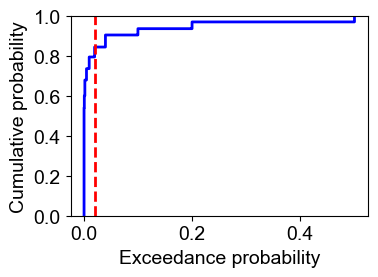

In [273]:
# Assuming 'merged_culvert' is your DataFrame and it contains the 'exceedance_prob' column
plt.figure(figsize=(4, 3))
# Plot ECDF for 'exceedance_prob'
sns.ecdfplot(merged_culvert['exeedance_prob'], color='blue', linewidth=2)
plt.axvline(x=0.02, color='red', linestyle='--', linewidth=2, label='Threshold at 0.02')
# Set labels and title
plt.xlabel('Exceedance probability')
plt.ylabel('Cumulative probability')
# Show the plot
plt.tight_layout()
plt.show()

In [274]:
# save to.xlsx file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_ALL_V2.xlsx'
merged_culvert.to_excel(excel_output_file, index=False)
print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_ALL_V2.xlsx


In [280]:
culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_ALL_V2.xlsx')

In [281]:
culvert.t_c_GEE_CN_wet.isna().sum()

np.int64(0)

# Uncertainty bands of Q 

#### Upper bound

In [ ]:
# Print rows where 't_c_GEE_CN_wet' is NaN
print(culvert[culvert['t_c_GEE_CN_wet'].isna()])

# Remove those rows from the DataFrame
culvert = culvert[~culvert['t_c_GEE_CN_wet'].isna()].reset_index(drop=True)
culvert

In [283]:
# upper bound
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize a dictionary to store the max discharge for each return period
    max_discharges = {}
    max_dis = 0  
    # Iterate over each return period
    for period in return_periods:
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_au'),
                getattr(culvert, f'rain_{period}_15m_au'),
                getattr(culvert, f'rain_{period}_30m_au'),
                getattr(culvert, f'rain_{period}_60m_au'),
                getattr(culvert, f'rain_{period}_02h_au'),
                getattr(culvert, f'rain_{period}_03h_au'),
                getattr(culvert, f'rain_{period}_06h_au'),
                getattr(culvert, f'rain_{period}_12h_au'),
                getattr(culvert, f'rain_{period}_24h_au')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=np.maximum(culvert['CN_wet'], culvert['GEE_CN_wet']))
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                np.minimum(culvert['t_c_CN_wet'], culvert['t_c_GEE_CN_wet']), culvert.Area_80 / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if max_discharge_row[-3] != 0:
                max_dis = max(max_dis, max_discharge_row[-1],culvert[f'Q_{period}'])
        # Store the max discharge for this return period in the dictionary
        max_dis= max (max_dis,culvert[f'Q_{period}'])
        max_discharges[f'Q_UL_{period}'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 6732/6732 [29:14<00:00,  3.84it/s]


#### Lower bound

In [284]:
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize a dictionary to store the max discharge for each return period
    max_discharges = {}
    max_dis = 0 
    # Iterate over each return period
    for period in return_periods:
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_al'),
                getattr(culvert, f'rain_{period}_15m_al'),
                getattr(culvert, f'rain_{period}_30m_al'),
                getattr(culvert, f'rain_{period}_60m_al'),
                getattr(culvert, f'rain_{period}_02h_al'),
                getattr(culvert, f'rain_{period}_03h_al'),
                getattr(culvert, f'rain_{period}_06h_al'),
                getattr(culvert, f'rain_{period}_12h_al'),
                getattr(culvert, f'rain_{period}_24h_al')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=np.minimum(culvert['CN_wet'], culvert['GEE_CN_wet']))
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                np.maximum(culvert['t_c_CN_wet'], culvert['t_c_GEE_CN_wet']), culvert.Area_10 / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if max_discharge_row[-3] != 0:
                max_dis = max(max_dis, max_discharge_row[-1])
        # Store the max discharge for this return period in the dictionary
        max_dis= min(max_dis,culvert[f'Q_{period}'])
        max_discharges[f'Q_LL_{period}'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 6732/6732 [29:29<00:00,  3.80it/s]


In [285]:
# save to.xlsx file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_UL_LL_All_V2.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_UL_LL_All_V2.xlsx


# AMC effect

In [105]:
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    # Iterate over each return period
    for ASM in ['nor','dry']:
        max_dis = 0
        for period in return_periods:
            # Loop through each interval
            for idx, interval in enumerate(intervals):
                # Set depth data (assuming the correct attributes are in `culvert`)
                # Use getattr to dynamically access the attribute based on the period
                depth = [
                    getattr(culvert, f'rain_{period}_10m_a'),
                    getattr(culvert, f'rain_{period}_15m_a'),
                    getattr(culvert, f'rain_{period}_30m_a'),
                    getattr(culvert, f'rain_{period}_60m_a'),
                    getattr(culvert, f'rain_{period}_02h_a'),
                    getattr(culvert, f'rain_{period}_03h_a'),
                    getattr(culvert, f'rain_{period}_06h_a'),
                    getattr(culvert, f'rain_{period}_12h_a'),
                    getattr(culvert, f'rain_{period}_24h_a')
                ]
                # Compute and normalize rainfall for each interval
                rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
                normalized_intervals[interval]= incremental_rainfall(rainfall)
                # Calculate excess rainfall for each interval
                result_df = calculate_excess_rainfall(normalized_intervals[interval], culvert['CN'] if ASM == 'nor' else culvert[f'CN_{ASM}'])
                # Extract relevant data for discharge calculation
                df = result_df[['Time', 'Incremental Excess (mm)']]
                # Determine time step based on interval
                time_step = 5 if interval < 0.5 else 6
                # Generate unit hydrograph
                intervals_1, discharge_values = construct_unit_hydrograph(
                    culvert['t_c_CN'] if ASM == 'nor' else culvert[f't_c_CN_{ASM}']  , culvert.Area / 10**6, time_step / 60, time_step
                )
                unit_hydrograph = np.array(discharge_values)
                # Calculate total discharge for this interval
                discharge = calculate_total_discharge(df, unit_hydrograph)
                # Get the total discharge column
                total_discharge = discharge['Total Discharge']
                # Find the maximum discharge value for the current interval
                max_discharge_index = total_discharge.idxmax()
                max_discharge_row = discharge.iloc[max_discharge_index]
                # Check if the third-to-last element is non-zero and update max discharge if needed
                if max_discharge_row[-3] != 0:
                    max_dis = max(max_dis, max_discharge_row[-1])
            # Store the max discharge for this return period in the dictionary
            max_discharges[f'Q_{period}_{ASM}'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 6732/6732 [1:02:33<00:00,  1.79it/s]


In [106]:
culvert[['Q_50_dry','Q_50_nor','Q_50']].describe()

Q_50_dry     Q_50_nor         Q_50
count  6732.000000  6732.000000  6462.000000
mean      1.304874     3.711088     7.427556
std       2.685525     6.181169    11.475378
min       0.000000     0.000311     0.002629
25%       0.154733     0.700996     1.722422
50%       0.532903     1.913238     4.281344
75%       1.385040     4.300250     8.834174
max      65.648605   103.980653   227.666765

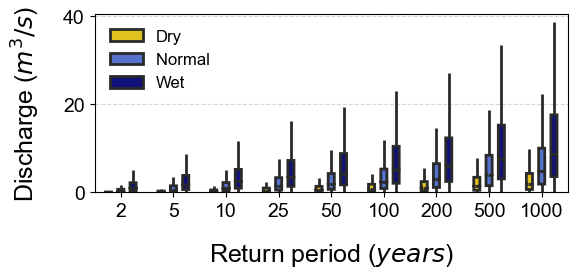

In [107]:
# Define colors for each category
custom_palette = {"Q Normal": "royalblue", "Q Dry": "gold", "Q Wet": "darkblue"}
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
# Prepare long-format dataframe
q_data = []
for q in return_periods:
    for scenario, label in zip(["_nor", "_dry", ""], ["Q Normal", "Q Dry", "Q Wet"]):
        column_name = f"Q_{q}{scenario}"
        for value in culvert[column_name]:  # Assuming 'culvert' is the DataFrame
            q_data.append({"Return Period": str(q), "Discharge (cms)": value, "Type": label})
# Convert to DataFrame
q_long = pd.DataFrame(q_data)
# Set up the figure
plt.figure(figsize=(6, 3))
# Create the box plot for the return periods
sns.boxplot(
    x="Return Period", 
    y="Discharge (cms)", 
    hue="Type", 
    data=q_long, 
    palette=custom_palette, 
    hue_order=["Q Dry", "Q Normal", "Q Wet"],  # Ensure the order matches the custom_palette
    dodge=True,
    width=0.7,
    linewidth=2,
    showfliers=False,
    notch=True, 
    showcaps=False,
    gap=0.5,
    log_scale=False,
)
plt.xlabel("Return period ($years$)", fontsize=18, labelpad=15)
plt.ylabel("Discharge ($m^3/s$)", fontsize=18, labelpad=15)
plt.ylim(0,)
plt.tick_params(axis='both', labelsize=14)
# legends
handles, labels = plt.gca().get_legend_handles_labels()
# Filter out the "Median capacity of culverts" label from the legend
filtered_labels = [label for label in labels if label != "Median capacity of culverts"]
# Map the relevant labels to the new labels
label_map = {
    "Q Dry": "Dry",
    "Q Normal": "Normal ",
    "Q Wet": "Wet"
}
# Replace labels with the correct ones for "Q Dry", "Q Normal", and "Q Wet"
new_labels = [label_map.get(label, label) for label in filtered_labels]
# Update the legend
plt.legend(handles, new_labels, loc="upper left", fontsize=12,frameon=False)
plt.grid(axis='y', which='major', linestyle="--", alpha=0.5)
# layout
plt.tight_layout()
# Save and show 
plt.savefig(r"D:\culvert repo\Results\Figures\hydro_q_box_plots_2_1000_All.png", dpi=300, bbox_inches='tight')
plt.show()

In [108]:
# save to.xlsx file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_wet_dry_All.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_wet_dry_All.xlsx


In [109]:
culvert = pd.read_excel(r"D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_wet_dry_All.xlsx")

# Future landuse effect on discharge 

In [110]:
# drop the rows with nan values for CN
# Define scenarios and years
scenarios = ['A1B', 'A2', 'B1', 'B2']
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]

# List of columns to check for NaNs
target_columns = [f'CN_{year}_{scenario}_Wet' for scenario in scenarios for year in years]

# Drop rows with NaNs in any of those columns
culvert = culvert.dropna(subset=target_columns)

In [111]:
scenarios = ['A1B', 'A2', 'B1', 'B2']
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    # Iterate over each return period
    for scenario in scenarios:
        for ASM in ['Wet']:
            for year in years:
                max_dis = 0  
                for period in return_periods:
                    # Loop through each interval
                    for idx, interval in enumerate(intervals):
                        # Set depth data (assuming the correct attributes are in `culvert`)
                        # Use getattr to dynamically access the attribute based on the period
                        depth = [
                            getattr(culvert, f'rain_{period}_10m_a'),
                            getattr(culvert, f'rain_{period}_15m_a'),
                            getattr(culvert, f'rain_{period}_30m_a'),
                            getattr(culvert, f'rain_{period}_60m_a'),
                            getattr(culvert, f'rain_{period}_02h_a'),
                            getattr(culvert, f'rain_{period}_03h_a'),
                            getattr(culvert, f'rain_{period}_06h_a'),
                            getattr(culvert, f'rain_{period}_12h_a'),
                            getattr(culvert, f'rain_{period}_24h_a')
                        ]
                        # Compute and normalize rainfall for each interval
                        rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
                        normalized_intervals[interval]= incremental_rainfall(rainfall)
                        # Calculate excess rainfall for each interval
                        result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert[f'CN_{year}_{scenario}_{ASM}'])
                        # Extract relevant data for discharge calculation
                        df = result_df[['Time', 'Incremental Excess (mm)']]
                        # Determine time step based on interval
                        time_step = 5 if interval < 0.5 else 6
                        # Generate unit hydrograph
                        intervals_1, discharge_values = construct_unit_hydrograph(
                            culvert[f't_CN_{year}_{scenario}_{ASM}'], culvert.Area / 10**6, time_step / 60, time_step
                        )
                        unit_hydrograph = np.array(discharge_values)
                        # Calculate total discharge for this interval
                        discharge = calculate_total_discharge(df, unit_hydrograph)
                        # Get the total discharge column
                        total_discharge = discharge['Total Discharge']
                        # Find the maximum discharge value for the current interval
                        max_discharge_index = total_discharge.idxmax()
                        max_discharge_row = discharge.iloc[max_discharge_index]
                        # Check if the third-to-last element is non-zero and update max discharge if needed
                        if max_discharge_row[-3] != 0:
                            max_dis = max(max_dis, max_discharge_row[-1])
                    # Store the max discharge for this return period in the dictionary
                    max_discharges[f'Q_{period}_{year}_{scenario}_{ASM}'] = max_dis
    return max_discharges
# Define return periods and intervals 
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000] 
def apply_max_discharge(row): 
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row 
    return calculate_max_discharge_for_row(row, return_periods) 
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing 
max_discharge_df = pd.DataFrame([ 
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing") 
]) 
# Convert the dictionary results to separate columns and concatenate them to the original data 
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1) 
culvert= culvert_Q

Rows processing: 100%|██████████| 6731/6731 [14:55:29<00:00,  7.98s/it]  


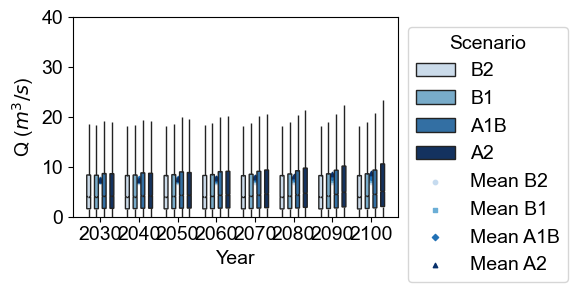

In [112]:
# Define scenarios and years
scenarios = ['B2', 'B1', 'A1B', 'A2']
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]

# Reshape data into long format for box plot
data = {'Year': [], 'Scenario': [], 'Q Value': []}
mean_data = {'Year': [], 'Scenario': [], 'Mean Q': []}

for year in years:
    for scenario in scenarios:
        q_values = culvert[f'Q_50_{year}_{scenario}_Wet'].dropna()  # Drop NaNs
        for value in q_values:
            data['Year'].append(year)
            data['Scenario'].append(scenario)
            data['Q Value'].append(value)
        # Store mean Q value for overlay line
        mean_data['Year'].append(year)
        mean_data['Scenario'].append(scenario)
        mean_data['Mean Q'].append(q_values.mean())

# Convert to DataFrames
df_box = pd.DataFrame(data)
df_mean = pd.DataFrame(mean_data)

# Set Year as categorical
df_box['Year'] = pd.Categorical(df_box['Year'], categories=years, ordered=True)
df_mean['Year'] = pd.Categorical(df_mean['Year'], categories=years, ordered=True)

# Set up the plot
plt.figure(figsize=(6, 3))

# Define a consistent color palette and markers for scenarios
palette = ['#08306b', '#2171b5', '#6baed6', '#c6dbef'][::-1]  
markers = ['o', 's', 'D', '^']

# Box plot for Q distributions
sns.boxplot(data=df_box, x='Year', y='Q Value', hue='Scenario', palette=palette, showfliers=False, 
            notch=True, showcaps=False, gap=0.5)

# Overlay mean trend lines, manually adjusting x-axis values
for i, scenario in enumerate(scenarios):
    subset = df_mean[df_mean['Scenario'] == scenario]
    x_positions = np.arange(len(years))  # Align x-values with categorical axis
    plt.scatter(x_positions, subset['Mean Q'], marker=markers[i], s=10, label=f'Mean {scenario}', color=palette[i])

# Adjust x-axis labels to match categorical years
plt.xticks(ticks=np.arange(len(years)), labels=years)

# Set y-axis to log scale, or adjust as needed
#plt.yscale('log')
plt.ylim(0,40)
# Plot styling
plt.ylabel(f"Q ($m^3/s$)")
plt.xlabel("Year")
plt.legend(title="Scenario", loc="upper left", bbox_to_anchor=(1, 1), ncol=1)

# Save and display the plot
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\Q50_distribution_culvert_2030_2100_All.png", dpi=300,bbox_inches='tight')
plt.show()


In [113]:
# save to .xlsx file
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_All.xlsx'
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_All.xlsx


In [118]:
culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_All.xlsx')

#### Correlation analysis of depth of rainfall in different durations with the same frequency

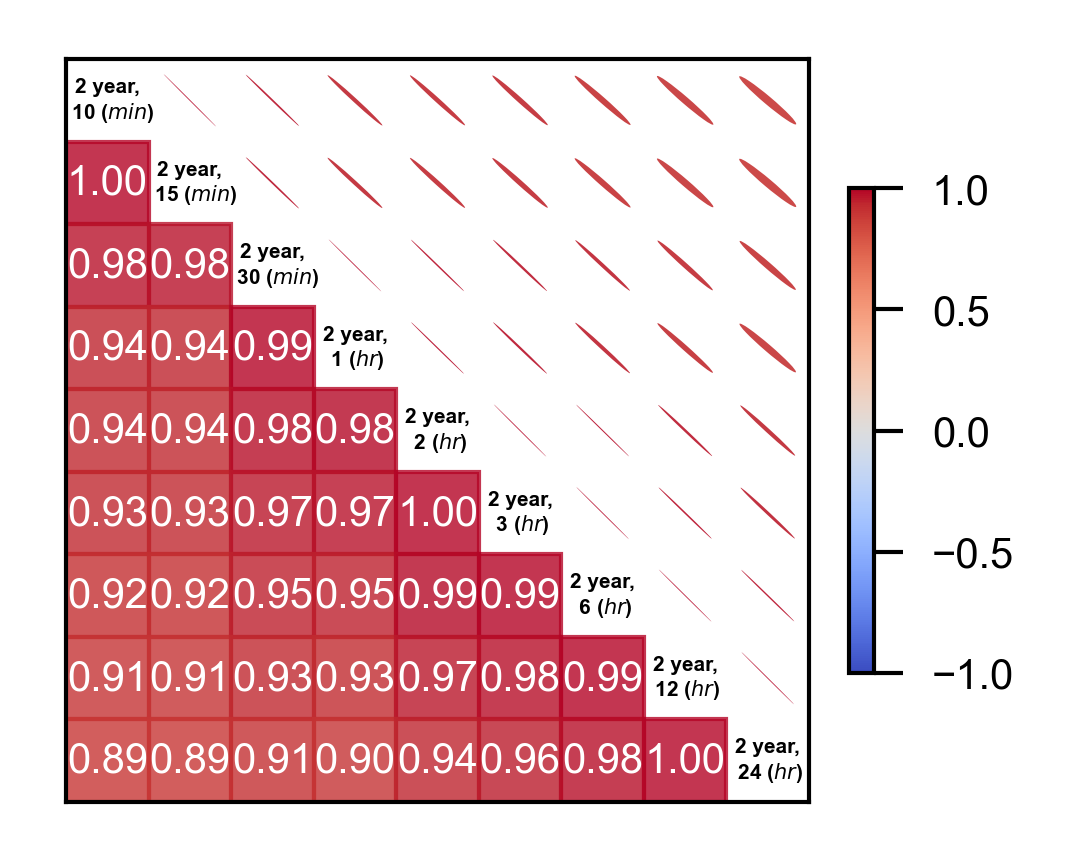

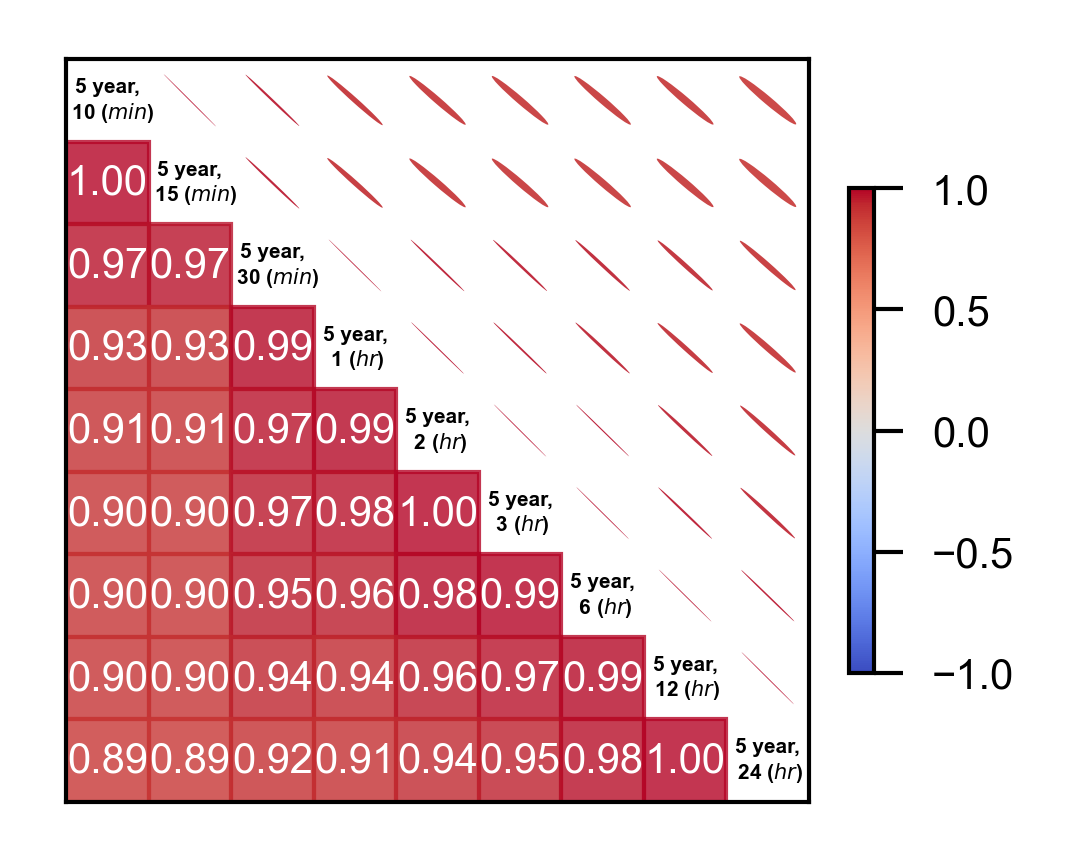

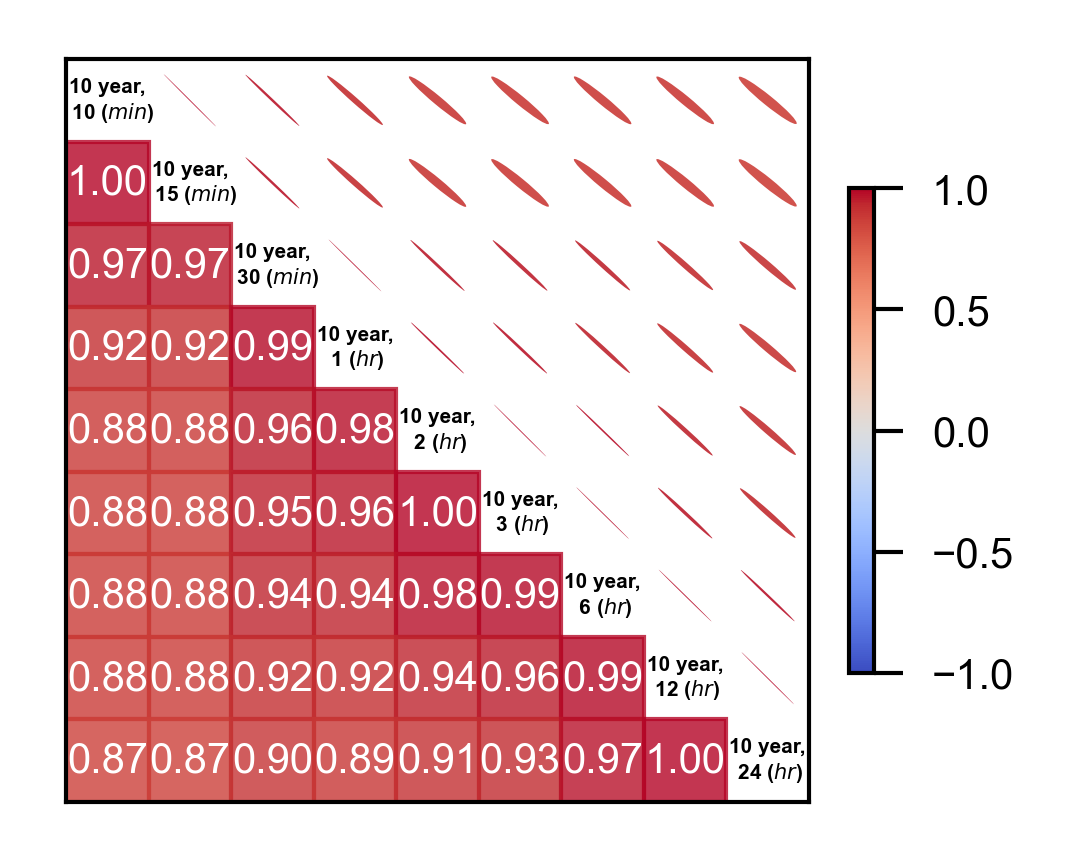

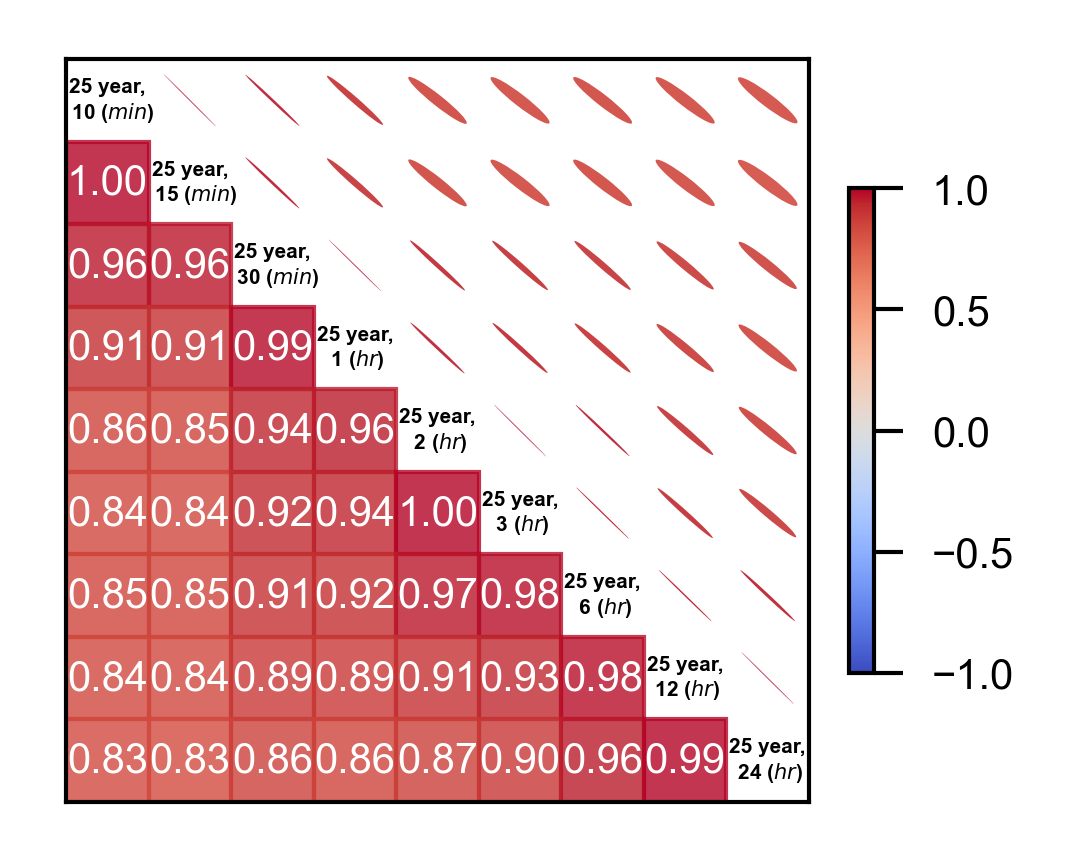

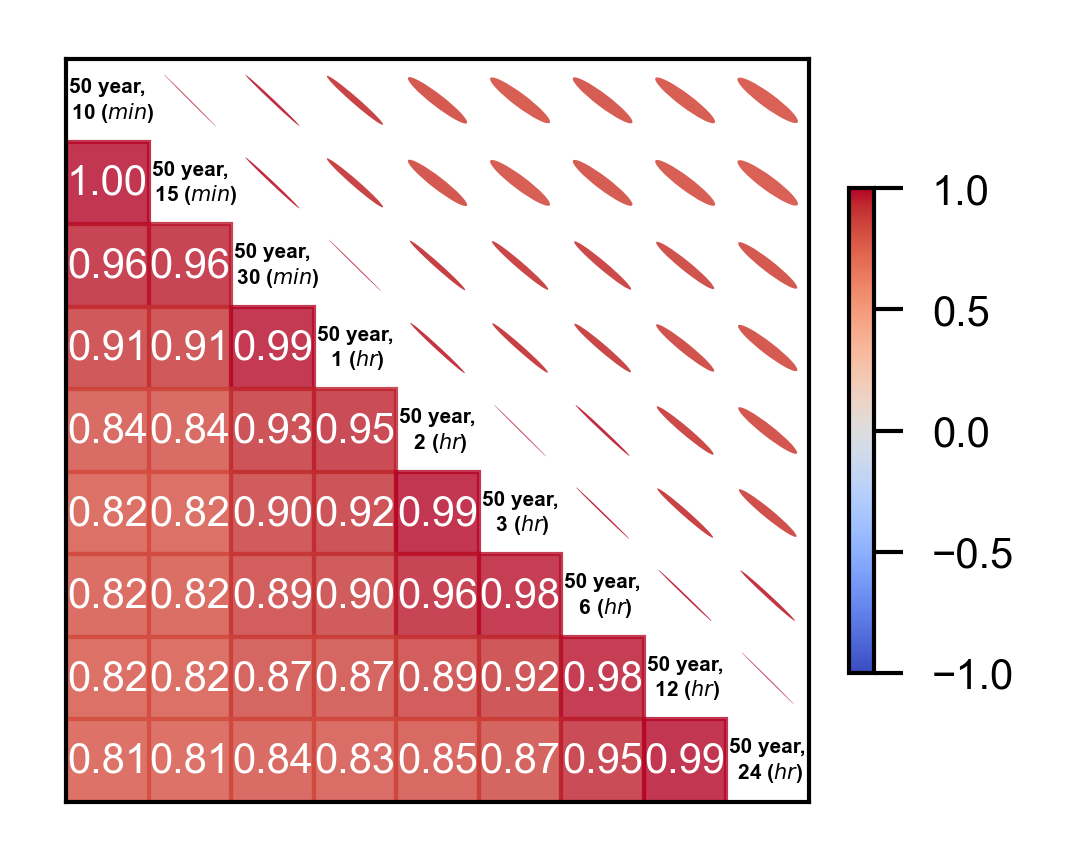

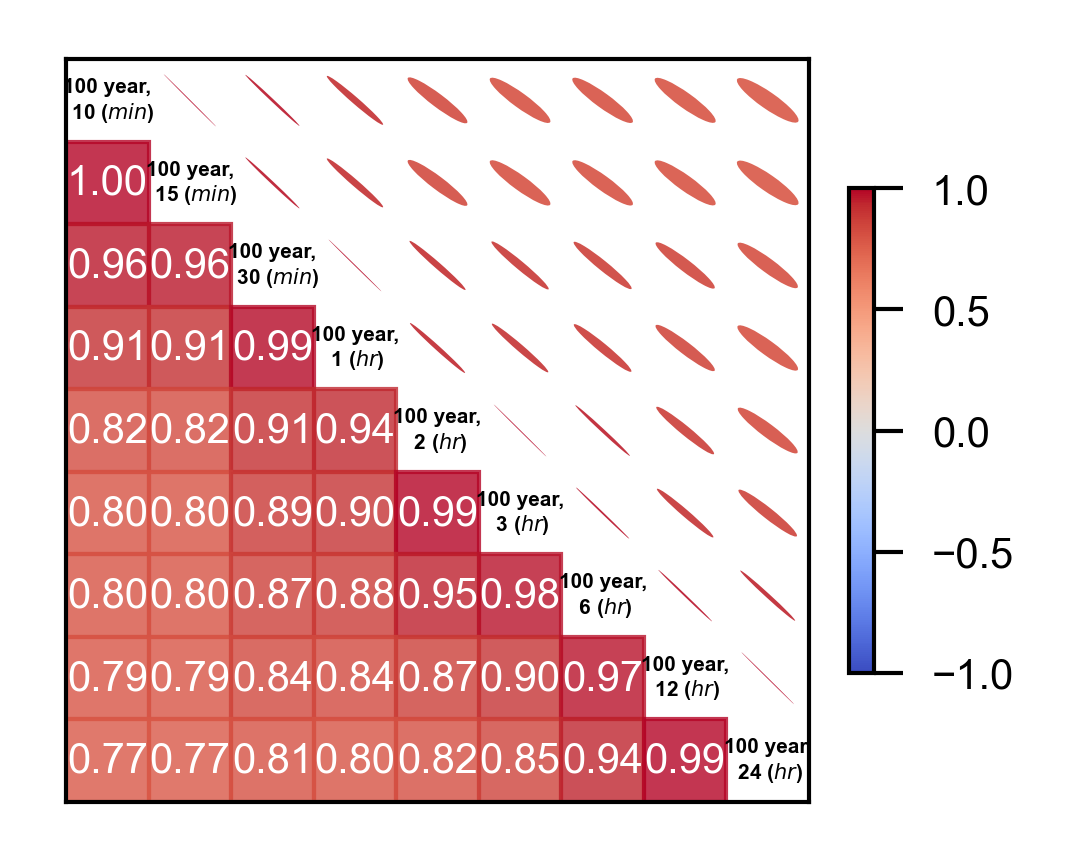

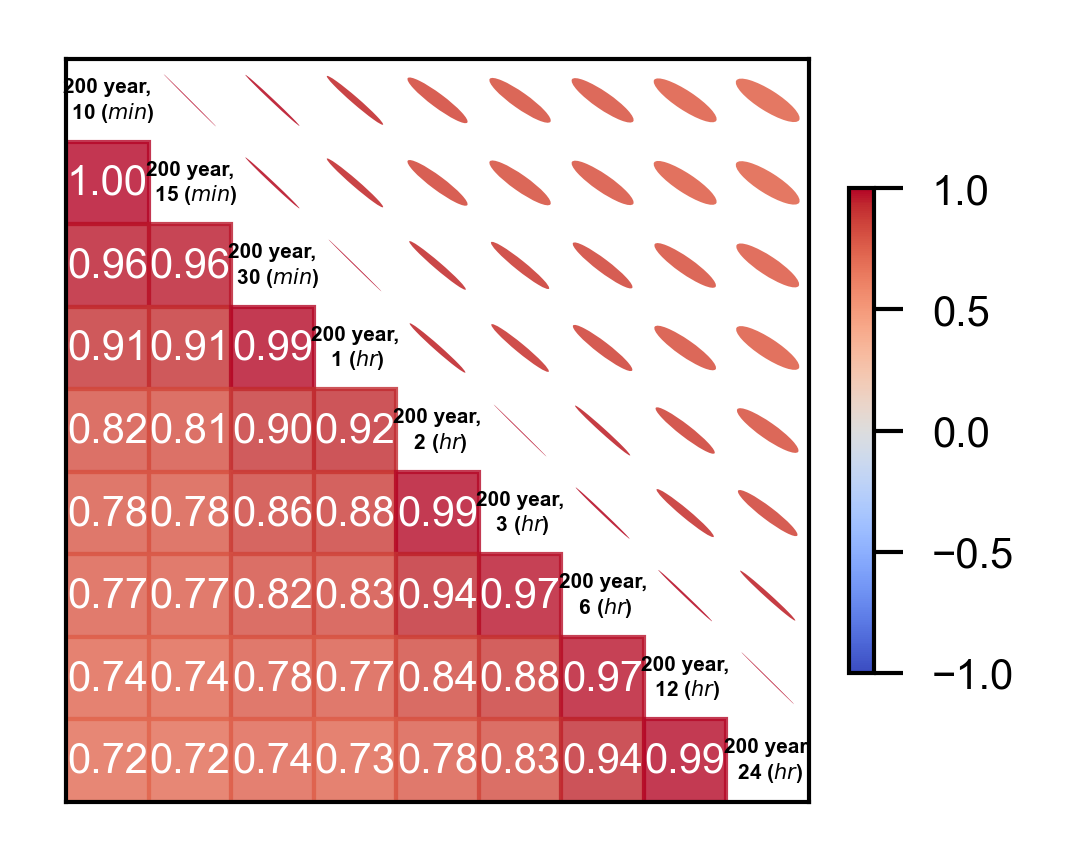

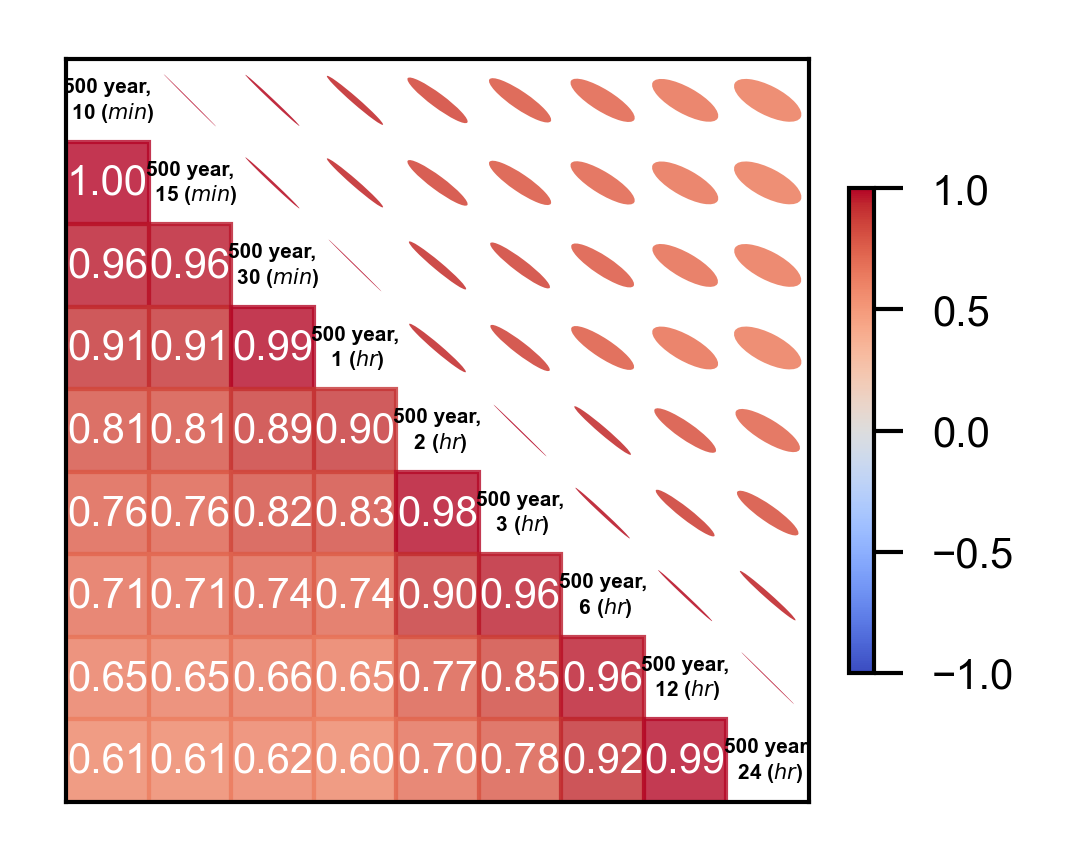

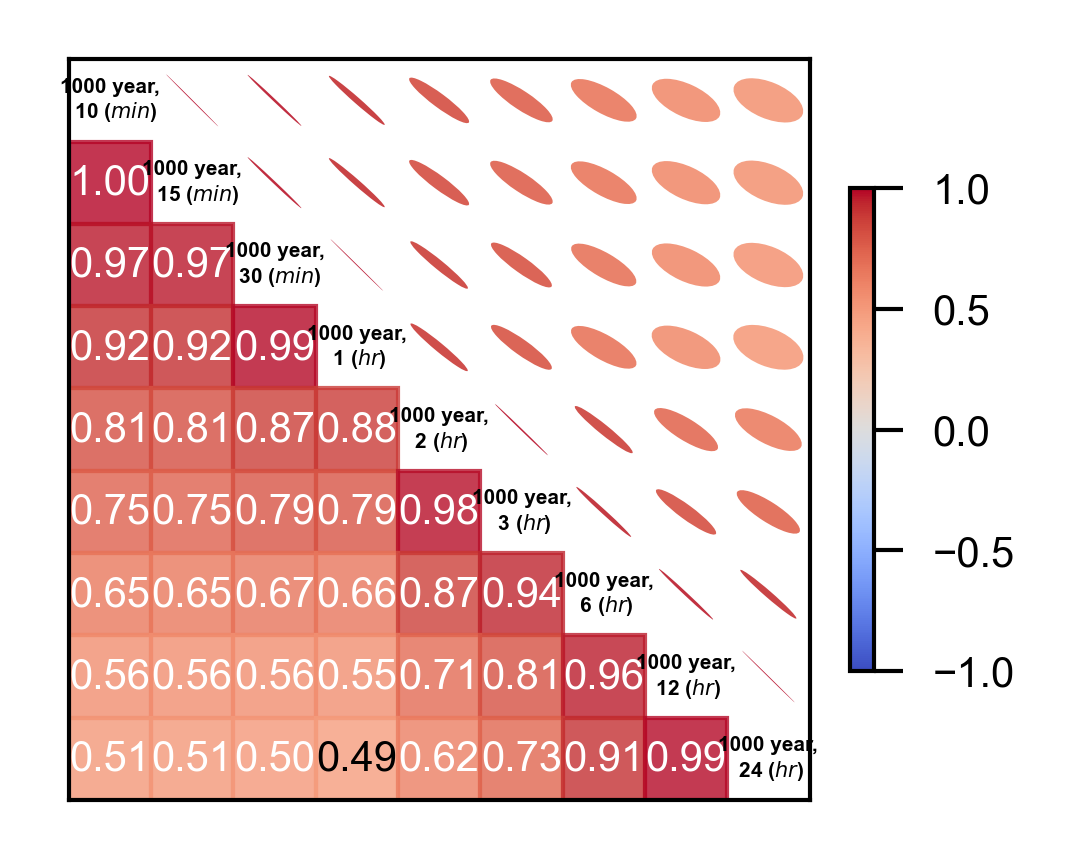

In [119]:
# Function to draw an ellipse based on correlation
def draw_ellipse(ax, x, y, correlation, cmap, norm):
    color = cmap(norm(correlation))  # Get color from colormap
    angle = 45 * correlation  # Rotate based on correlation
    min_height = 0.01  # Minimum height for visibility
    height = max(min_height, 0.9 * (1 - abs(correlation)))  # Ensure a minimum ellipse height
    width = 0.9  # Keep width constant
    ellipse = Ellipse((x, y), width=width, height=height, angle=angle, 
                      facecolor=color, edgecolor='none', linewidth=0.5, alpha=0.9)
    ax.add_patch(ellipse)
# Function to plot the custom correlation matrix
def custom_corrplot(data,rp, save_path=None):
    corr = data.corr()  # Compute correlation matrix
    # Define a mapping of original column names to desired labels
    label_mapping = {
        f'rain_{rp}_10m_a': f'{rp} year,\n  10 ($min$)',
        f'rain_{rp}_15m_a': f'{rp} year,\n  15 ($min$)',
        f'rain_{rp}_30m_a': f'{rp} year,\n  30 ($min$)',
        f'rain_{rp}_60m_a': f'{rp} year,\n 1 ($hr$)',
        f'rain_{rp}_02h_a': f'{rp} year,\n 2 ($hr$)',
        f'rain_{rp}_03h_a': f'{rp} year,\n 3 ($hr$)',
        f'rain_{rp}_06h_a': f'{rp} year,\n 6 ($hr$)',
        f'rain_{rp}_12h_a': f'{rp} year,\n 12 ($hr$)',
        f'rain_{rp}_24h_a': f'{rp} year,\n 24 ($hr$)'
    }
    # Update the correlation matrix labels
    corr = corr.rename(columns=label_mapping, index=label_mapping)
    labels = corr.columns.tolist()  # Updated variable names with new labels
    # Set figure size to be square (3x3 inches)
    fig, ax = plt.subplots(figsize=(2, 2), dpi=600)  # Set figure size and resolution
    ax.set_xlim(-0.5, len(labels) - 0.5)
    ax.set_ylim(-0.5, len(labels) - 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    # Define colormap
    cmap = cm.get_cmap("coolwarm")
    norm = Normalize(vmin=-1, vmax=1)
    # Plot elements
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                # Diagonal: Show variable names
                ax.text(j, i, labels[i], ha='center', va='center', fontsize=2.5,fontweight='bold' )
            elif i > j:
                # Lower triangle: Heatmap with correlation coefficients
                color = cmap(norm(corr.iloc[i, j]))
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=color, alpha=0.8, linewidth=0.5))  # Reduced border width
                ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', fontsize=5,
                        color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')
            else:
                # Upper triangle: Colored Ellipse representation
                draw_ellipse(ax, j, i, corr.iloc[i, j], cmap, norm)
    # Create heatmap color legend with the same height as the plot
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.05)
    cbar.ax.tick_params(labelsize=5, width=0.5)
    cbar.outline.set_linewidth(0.5)
    # Reduce plot border width
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Set the plot border width to 0.5
    # Set aspect ratio of plot to be equal (square)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()  # Ensure layout fits well
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, format='tiff', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
for rp in return_periods:
    # Select only the rainfall columns of interest
    rain_subset = culvert[[f'rain_{rp}_10m_a', f'rain_{rp}_15m_a', f'rain_{rp}_30m_a',f'rain_{rp}_60m_a',
                           f'rain_{rp}_02h_a',f'rain_{rp}_03h_a',f'rain_{rp}_06h_a',f'rain_{rp}_12h_a',f'rain_{rp}_24h_a']]
    # Generate and save the correlation plot
    custom_corrplot(rain_subset,rp=rp, save_path=rf"D:\culvert repo\Results\Figures\correlation_plots_rainfall_durations\{rp}_year_rain_correlation_plot.png")

### Linear regression model to estimate 5 min, 15min, and 30 min rainfall from 60 min rainfall

In [121]:
# Define all relevant columns for regression analysis
all_rain_columns = []
for rp in ['2', '5', '10', '25', '50', '100', '200', '500', '1000']:
    all_rain_columns.extend([
        f'rain_{rp}_10m_a',
        f'rain_{rp}_15m_a',
        f'rain_{rp}_30m_a',
        f'rain_{rp}_60m_a'
    ])

# Subset to just these columns and find rows with any NaN
nan_rows = culvert[all_rain_columns].loc[culvert[all_rain_columns].isna().any(axis=1)]

# Print the NaN rows and how many there are
print(f"Number of rows with NaNs: {len(nan_rows)}")
print(nan_rows)

Number of rows with NaNs: 1
      rain_2_10m_a  rain_2_15m_a  rain_2_30m_a  rain_2_60m_a  rain_5_10m_a  \
6731           NaN           NaN           NaN           NaN           NaN   

      rain_5_15m_a  rain_5_30m_a  rain_5_60m_a  rain_10_10m_a  rain_10_15m_a  \
6731           NaN           NaN           NaN            NaN            NaN   

      ...  rain_200_30m_a  rain_200_60m_a  rain_500_10m_a  rain_500_15m_a  \
6731  ...             NaN             NaN             NaN             NaN   

      rain_500_30m_a  rain_500_60m_a  rain_1000_10m_a  rain_1000_15m_a  \
6731             NaN             NaN              NaN              NaN   

      rain_1000_30m_a  rain_1000_60m_a  
6731              NaN              NaN  

[1 rows x 36 columns]


In [122]:
# Define all relevant columns
rain_columns_to_check = []
for rp in ['2', '5', '10', '25', '50', '100', '200', '500', '1000']:
    rain_columns_to_check.extend([
        f'rain_{rp}_10m_a',
        f'rain_{rp}_15m_a',
        f'rain_{rp}_30m_a',
        f'rain_{rp}_60m_a'
    ])

# Drop rows with NaNs in any of those columns
culvert = culvert.dropna(subset=rain_columns_to_check).reset_index(drop=True)

print(f"Remaining rows after NaN removal: {len(culvert)}")

Remaining rows after NaN removal: 6731


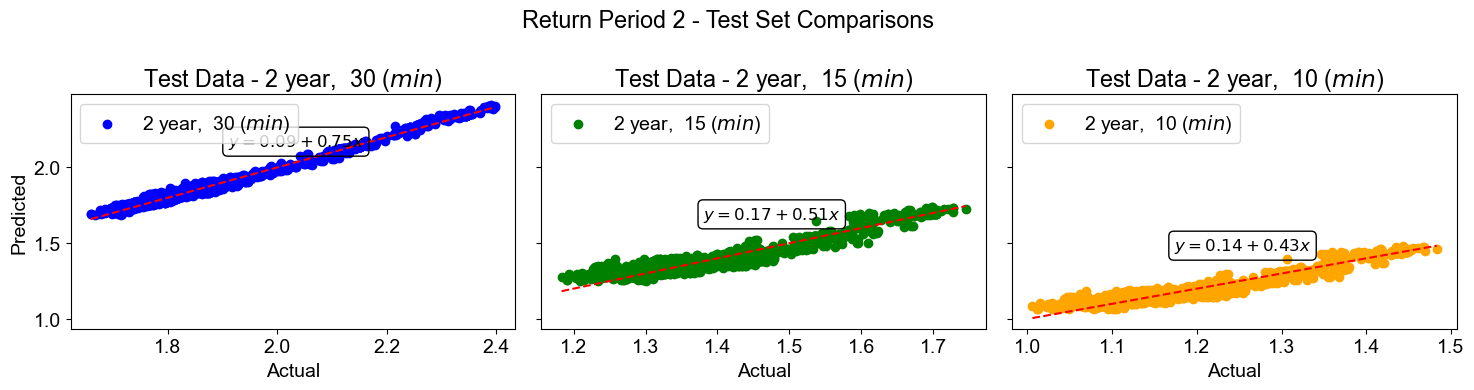

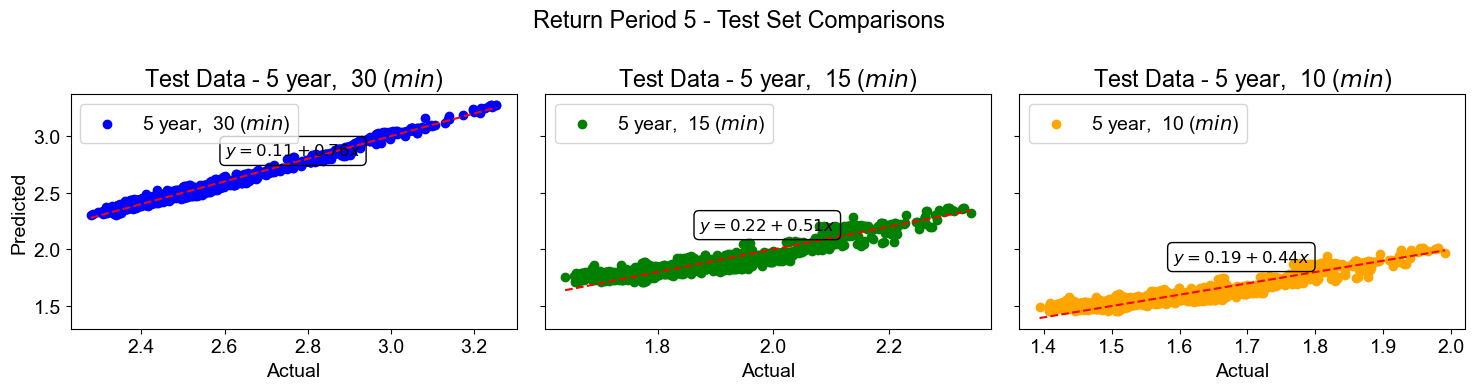

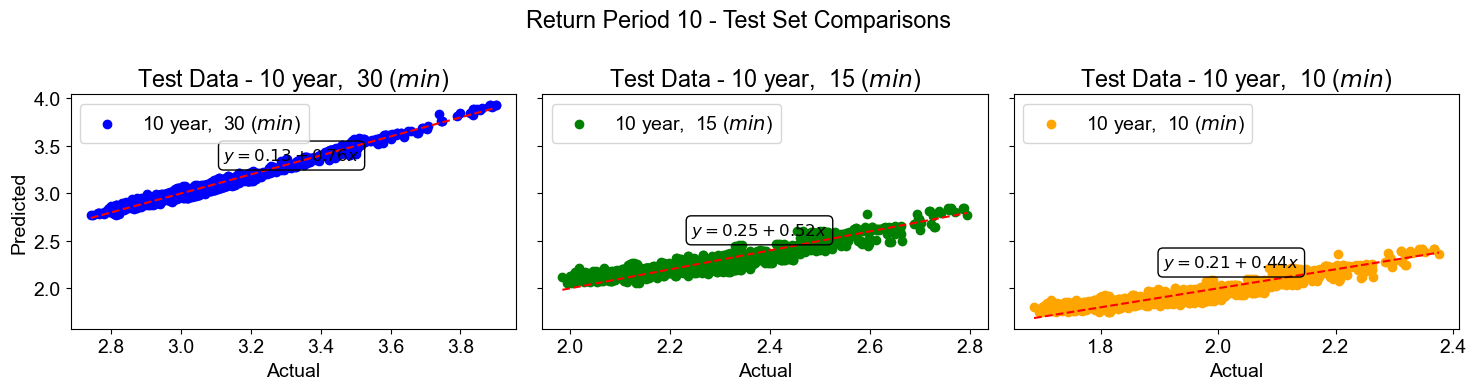

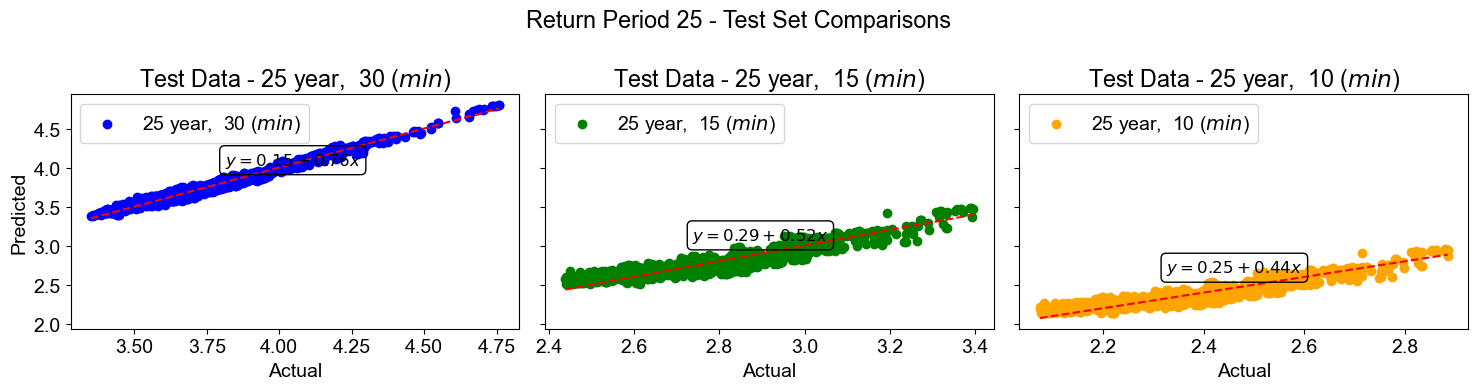

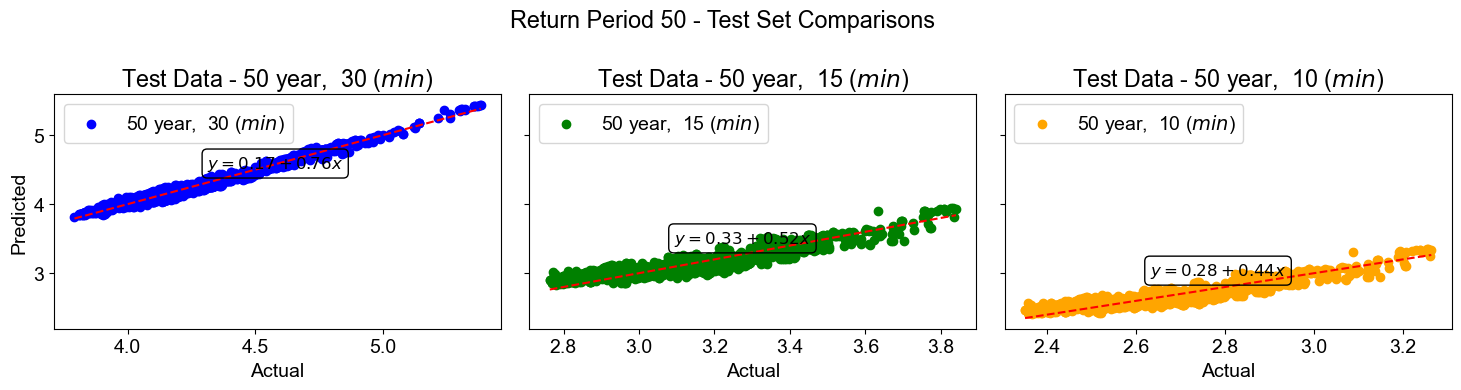

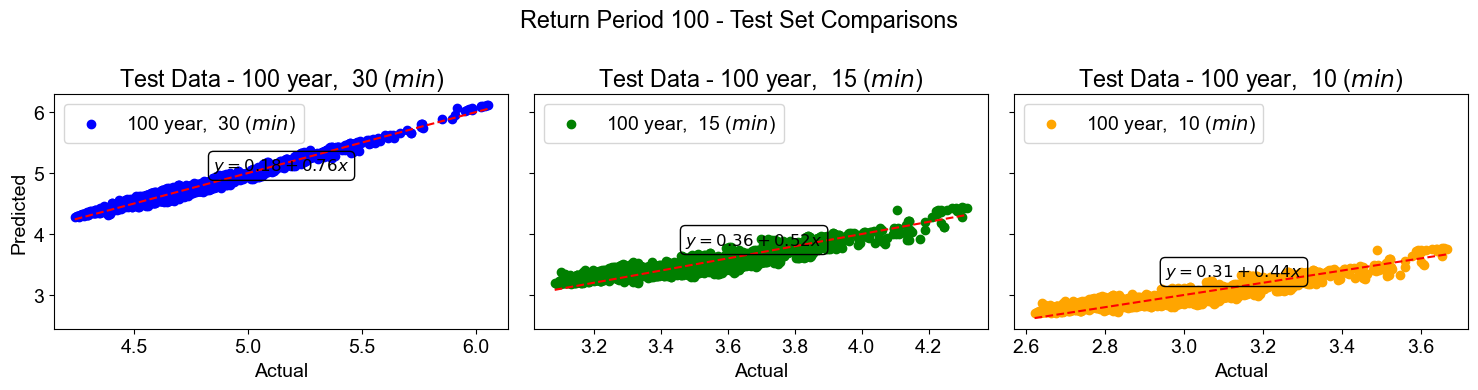

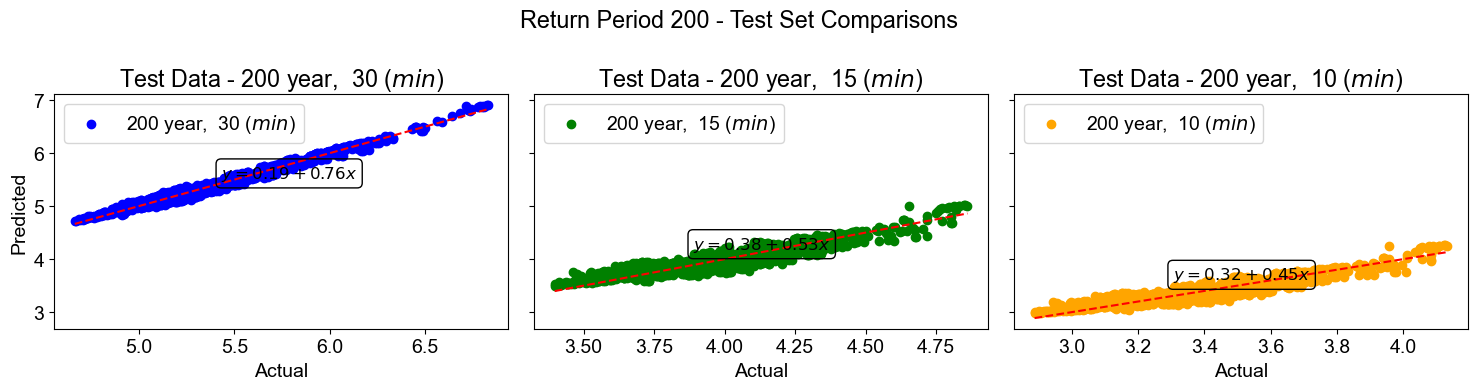

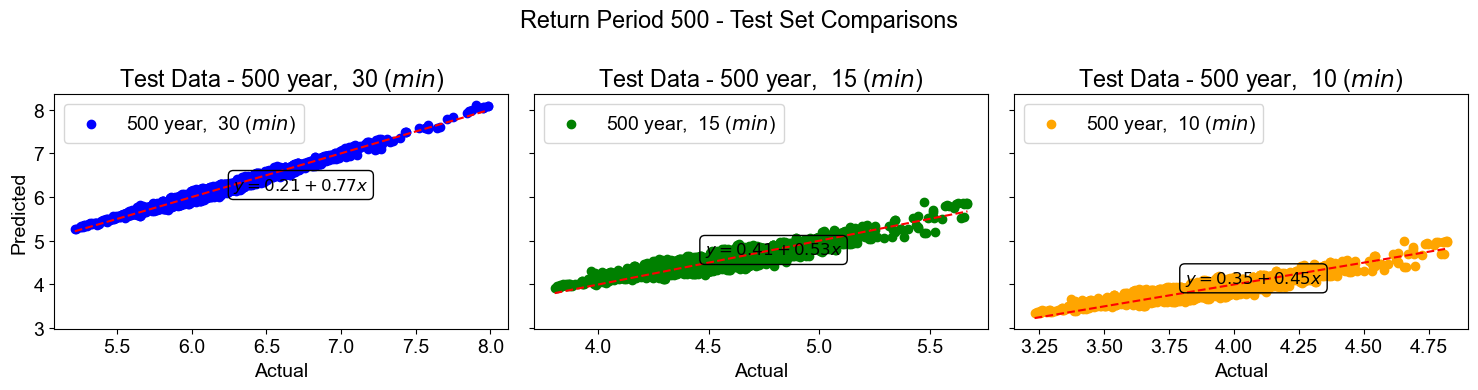

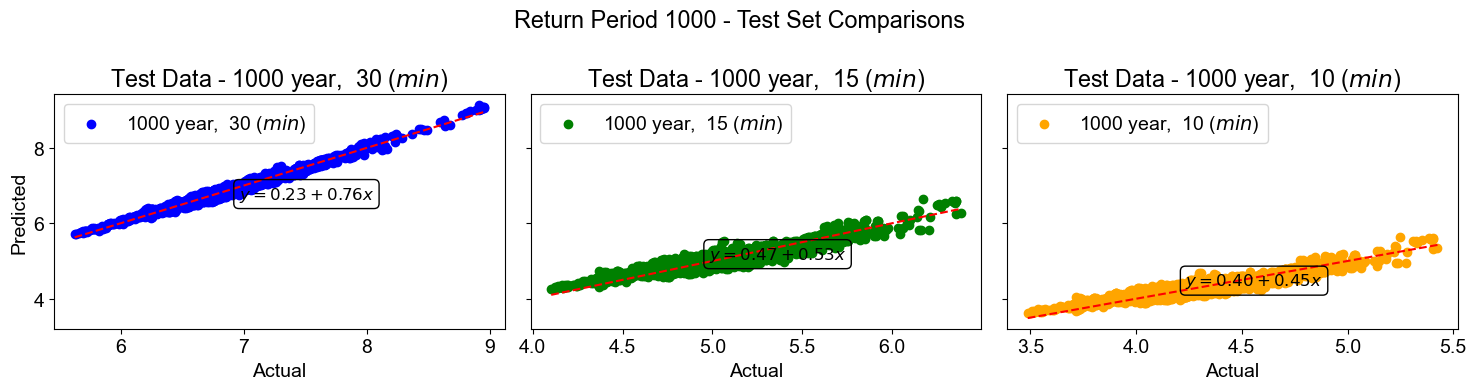

Return Period Target Duration  β₀ (intercept)  β₁ (slope)        R²  \
0              2             30m        0.086743    0.754205  0.986756   
1              2             15m        0.170301    0.509557  0.894520   
2              2             10m        0.144506    0.433188  0.894707   
3              5             30m        0.109449    0.756961  0.982822   
4              5             15m        0.218367    0.514082  0.867971   
5              5             10m        0.185524    0.436996  0.868194   
6             10             30m        0.126020    0.758473  0.980741   
7             10             15m        0.251945    0.516982  0.854654   
8             10             10m        0.214177    0.439428  0.854711   
9             25             30m        0.148006    0.759796  0.978769   
10            25             15m        0.294612    0.519991  0.843151   
11            25             10m        0.253827    0.441223  0.843832   
12            50             30m        0.166397    0.760149  0.978066   
13            50             15m        0.332790    0.520298  0.838185   
14            50             10m        0.282784    0.442271  0.838305   
15           100             30m        0.181081    0.761190  0.977391   
16           100             15m        0.362143    0.522382  0.834578   
17           100             10m        0.307662    0.444051  0.834602   
18           200             30m        0.189458    0.763331  0.977078   
19           200             15m        0.379227    0.526612  0.833784   
20           200             10m        0.322092    0.447659  0.833847   
21           500             30m        0.207052    0.765044  0.977797   
22           500             15m        0.413888    0.530117  0.839508   
23           500             10m        0.351945    0.450581  0.839527   
24          1000             30m        0.233006    0.764856  0.979131   
25          1000             15m        0.465791    0.529740  0.848268   
26          1000             10m        0.395968    0.450273  0.848300   

         MSE  
0   0.000391  
1   0.001576  
2   0.001136  
3   0.000691  
4   0.002779  
5   0.002004  
6   0.000999  
7   0.004013  
8   0.002898  
9   0.001527  
10  0.006098  
11  0.004373  
12  0.001988  
13  0.007966  
14  0.005749  
15  0.002540  
16  0.010162  
17  0.007341  
18  0.003211  
19  0.012845  
20  0.009278  
21  0.004380  
22  0.017522  
23  0.012657  
24  0.005607  
25  0.022422  
26  0.016197

In [123]:
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
coes_list = []
for rp in return_periods:
    label_mapping = {
        f'rain_{rp}_10m_a': f'{rp} year,  10 ($min$)',
        f'rain_{rp}_15m_a': f'{rp} year,  15 ($min$)',
        f'rain_{rp}_30m_a': f'{rp} year,  30 ($min$)',
        f'rain_{rp}_60m_a': f'{rp} year, 1 ($hr$)',
        f'rain_{rp}_02h_a': f'{rp} year, 2 ($hr$)',
        f'rain_{rp}_03h_a': f'{rp} year, 3 ($hr$)',
        f'rain_{rp}_06h_a': f'{rp} year, 6 ($hr$)',
        f'rain_{rp}_12h_a': f'{rp} year, 12 ($hr$)',
        f'rain_{rp}_24h_a': f'{rp} year, 24 ($hr$)'
    }
    dependent_variables = [f'rain_{rp}_30m_a', f'rain_{rp}_15m_a', f'rain_{rp}_10m_a']
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for i, dep_var in enumerate(dependent_variables):
        y = culvert[[dep_var]].values
        X = culvert[[f'rain_{rp}_60m_a']].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        beta_0 = model.intercept_[0]
        beta_1 = model.coef_[0][0]
        # Collect coefficients
        coes_list.append({
            "Return Period": rp,
            "Target Duration": dep_var.split('_')[2],  # 05m, 15m, 30m
            "β₀ (intercept)": beta_0,
            "β₁ (slope)": beta_1,
            "R²": r2_score(y_test, y_test_pred),
            "MSE": mean_squared_error(y_test, y_test_pred)
        })
        # Plotting
        formula = rf"$y = {beta_0:.2f} + {beta_1:.2f} x$"
        ax = axes[i]
        ax.scatter(y_test, y_test_pred, color=['blue', 'green', 'orange'][i], label=f'{label_mapping[dep_var]}')
        ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        x_pos = max(y_test) * 0.9
        y_pos = min(y_test_pred) * 1.1
        ax.text(x_pos, y_pos+0.25, formula, color='black', fontsize=12, ha='right', va='bottom',
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
        ax.set_title(f'Test Data - {label_mapping[dep_var]}')
        ax.set_xlabel('Actual')
        if i == 0:
            ax.set_ylabel('Predicted')
        ax.legend(loc='upper left')
    plt.suptitle(f"Return Period {rp} - Test Set Comparisons")
    plt.tight_layout()
    plt.show()

# Convert to DataFrame
coes = pd.DataFrame(coes_list)
coes

#### Assign the nearest station's projected rainfall to each culvert

In [124]:
station = pd.read_excel(r"D:\culvert repo\data\Future Rainfall\rainfall_station_characteristics.xlsx")
station

Station ID Country State                Station Name  Lat (°N)  \
0         060806      US    CT  BRIDGEPORT SIKORSKY MEM AP     41.16   
1         061762      US    CT                     DANBURY     41.40   
2         062658      US    CT               FALLS VILLAGE     41.95   
3         063207      US    CT                      GROTON     41.35   
4         065445      US    CT                NORFOLK 2 SW     41.97   
..           ...     ...   ...                         ...       ...   
152  CA007025745      CA    QC                    ORMSTOWN     45.12   
153  CA007026040      CA    QC                 PHILIPSBURG     45.03   
154  CA007026836      CA    QC                 ST ANICET 1     45.12   
155  CA007027040      CA    QC                STE CLOTILDE     45.17   
156  CA007028680      CA    QC                 VALLEYFIELD     45.23   

     Lon (°E)  Elev (ft)  2-yr_2010-2039_rcp45_1  2-yr_2010-2039_rcp45_2  \
0      -73.13          5                1.485028                1.841016   
1      -73.42        405                1.734625                2.149316   
2      -73.37        550                1.229862                1.523894   
3      -72.04         40                1.451256                1.798357   
4      -73.22       1340                1.423794                1.764132   
..        ...        ...                     ...                     ...   
152    -74.05        150                0.927940                1.149900   
153    -73.08        173                0.831654                1.030147   
154    -74.28        154                0.922897                1.143953   
155    -73.68        170                1.081902                1.340897   
156    -74.10        150                0.948717                1.175455   

     2-yr_2010-2039_rcp45_3  ...  100-yr_2070-2099_rcp45_12  \
0                  2.087603  ...                   8.882938   
1                  2.436447  ...                   9.724692   
2                  1.727483  ...                   6.741469   
3                  2.038706  ...                   8.619218   
4                  1.999778  ...                   7.791655   
..                      ...  ...                        ...   
152                1.303598  ...                   4.897259   
153                1.167550  ...                   4.401337   
154                1.297056  ...                   4.885579   
155                1.520261  ...                   5.336541   
156                1.332441  ...                   5.023991   

     100-yr_2070-2099_rcp45_18  100-yr_2070-2099_rcp45_24  \
0                    10.070550                  11.008271   
1                    11.025448                  12.052554   
2                     7.643596                   8.355967   
3                     9.771479                  10.681280   
4                     8.834506                   9.658016   
..                         ...                        ...   
152                   5.551132                   6.067351   
153                   4.990359                   5.455488   
154                   5.539393                   6.055684   
155                   6.049725                   6.612822   
156                   5.695946                   6.226533   

     100-yr_2070-2099_rcp85_1  100-yr_2070-2099_rcp85_2  \
0                    4.417691                  5.474386   
1                    4.802863                  5.952129   
2                    3.333051                  4.131050   
3                    4.273381                  5.295847   
4                    3.855777                  4.779285   
..                        ...                       ...   
152                  2.420079                  2.998204   
153                  2.202959                  2.730185   
154                  2.407771                  2.984462   
155                  2.657947                  3.293507   
156                  2.479024                  3.072197   

     100-yr_2070-2099_rcp85_3

In [125]:
# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # Distance in kilometers
# Function to find the nearest station for a single culvert row
def find_nearest_station(row):
    distances = haversine(row['Ini_lat'], row['Ini_lon'], station['Lat (°N)'], station['Lon (°E)'])
    nearest_index = np.argmin(distances)
    return station.loc[nearest_index, 'Station ID']
# Apply to each row
culvert['Nearest_Station_ID'] = culvert.apply(find_nearest_station, axis=1)

In [126]:
culvert = culvert.drop(columns=['Nearest_Station_ID'], errors='ignore')

In [127]:
# Generate all rainfall column names
rainfall_cols = []
for rp in ['2-yr','5-yr','10-yr','25-yr','50-yr','100-yr']:
    for time in ['2010-2039','2040-2069','2070-2099']:
        for scenario in ['rcp45','rcp85']:
            for duration in [1,2,3,6,12,18,24]:
                rainfall_cols.append(f"{rp}_{time}_{scenario}_{duration}")
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c
# Match each culvert to the nearest station and copy rainfall data
def match_station_and_rainfall(row):
    distances = haversine(row['Ini_lat'], row['Ini_lon'], station['Lat (°N)'], station['Lon (°E)'])
    nearest_idx = np.argmin(distances)
    nearest_station = station.iloc[nearest_idx]
    result = {'Nearest_Station_ID': nearest_station['Station ID']}
    for col in rainfall_cols:
        if col in station.columns:
            result[col] = nearest_station[col]* 2.54
    return pd.Series(result)
# Apply the matching
culvert = culvert.join(culvert.apply(match_station_and_rainfall, axis=1))

In [128]:
#### calculate the 5, 15, and 30-minute rainfall from 1 hr
# Map durations (in hours) to their short-duration labels in Coes
duration_mapping = {
    '0.5': '30m',
    '0.25': '15m',
    '0.17': '10m'
}
# Loop over all RP/Time/Scenario combinations
for rp in ['2-yr','5-yr','10-yr','25-yr','50-yr','100-yr']:
    for time in ['2010-2039','2040-2069','2070-2099']:
        for scenario in ['rcp45','rcp85']:
            # Get the 1-hour column
            one_hr_col = f"{rp}_{time}_{scenario}_1"
            # Skip if that column doesn't exist
            if one_hr_col not in culvert.columns:
                continue
            one_hr_vals = culvert[one_hr_col]
            # Predict 5min, 15min, 30min from 1-hr rainfall using coes
            for new_dur, coes_dur in duration_mapping.items():
                # Match coes row
                row = coes[(coes["Return Period"] == rp.split('-')[0]) & (coes["Target Duration"] == coes_dur)]
                if row.empty:
                    continue
                beta_0 = row["β₀ (intercept)"].values[0]
                beta_1 = row["β₁ (slope)"].values[0]
                # Predict and assign
                pred_col = f"{rp}_{time}_{scenario}_{new_dur}"
                culvert[pred_col] = beta_0 + beta_1 * one_hr_vals

In [129]:
# Define the output file path for Excel
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_All.xlsx'
# Save the DataFrame to an Excel file
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_All.xlsx


In [130]:
culvert=pd.read_excel(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_All.xlsx')

In [131]:
# future Q 
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    for time in ['2010-2039','2040-2069','2070-2099']:
            for scenario in ['rcp45','rcp85']:
                max_dis = 0
                for period in return_periods:
                    rp=str(period)+'-yr'
                 # Loop through each interval
                    for idx, interval in enumerate(intervals):
                        # Set depth data (assuming the correct attributes are in `culvert`)
                        # Use getattr to dynamically access the attribute based on the period
                        depth = [
                            getattr(culvert, f"{rp}_{time}_{scenario}_0.17"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_0.25"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_0.5"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_1"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_2"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_3"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_6"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_12"),
                            getattr(culvert, f"{rp}_{time}_{scenario}_24")
                        ]
                        # Compute and normalize rainfall for each interval
                        rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
                        normalized_intervals[interval]= incremental_rainfall(rainfall)
                        # Calculate excess rainfall for each interval
                        result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert.CN_wet)
                        # Extract relevant data for discharge calculation
                        df = result_df[['Time', 'Incremental Excess (mm)']]
                        # Determine time step based on interval
                        time_step = 5 if interval < 0.5 else 6
                        # Generate unit hydrograph
                        intervals_1, discharge_values = construct_unit_hydrograph(
                            culvert.t_c_CN_wet, culvert.Area / 10**6, time_step / 60, time_step
                        )
                        unit_hydrograph = np.array(discharge_values)
                        # Calculate total discharge for this interval
                        discharge = calculate_total_discharge(df, unit_hydrograph)
                        # Get the total discharge column
                        total_discharge = discharge['Total Discharge']
                        # Find the maximum discharge value for the current interval
                        max_discharge_index = total_discharge.idxmax()
                        max_discharge_row = discharge.iloc[max_discharge_index]
                        # Check if the third-to-last element is non-zero and update max discharge if needed
                        if max_discharge_row[-3] != 0:
                            max_dis = max(max_dis, max_discharge_row[-1])
                    # Store the max discharge for this return period in the dictionary
                    max_discharges[f'Q_{period}_{time}_{scenario}'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 6731/6731 [1:56:25<00:00,  1.04s/it]  


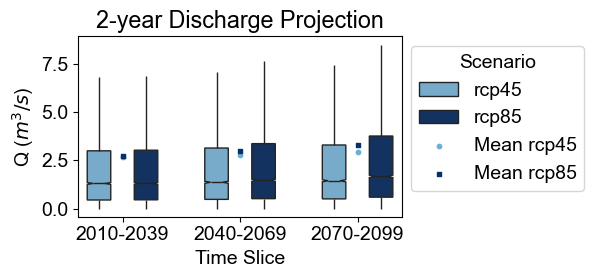

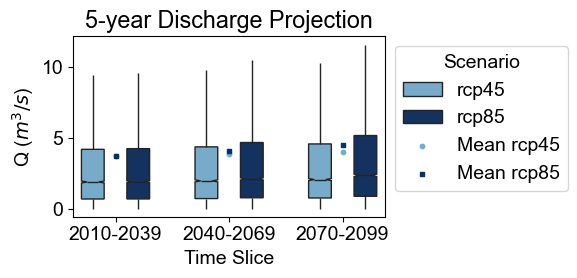

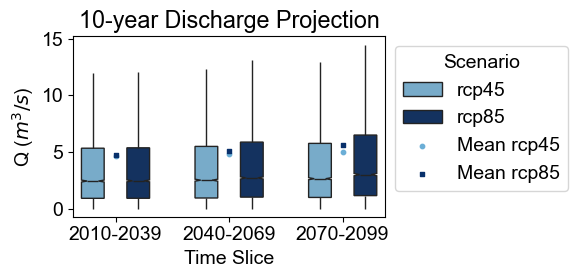

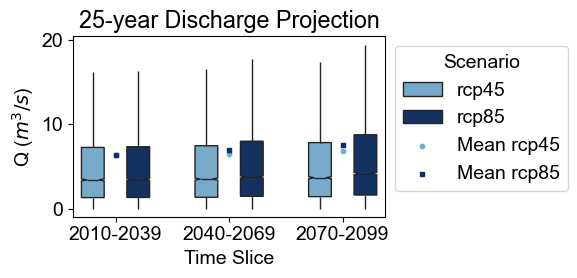

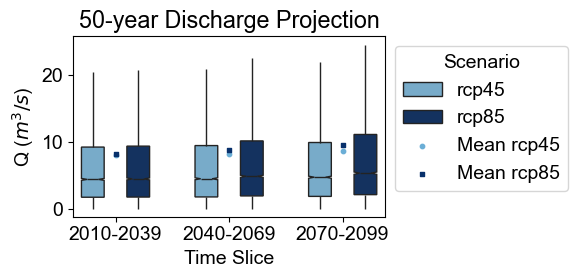

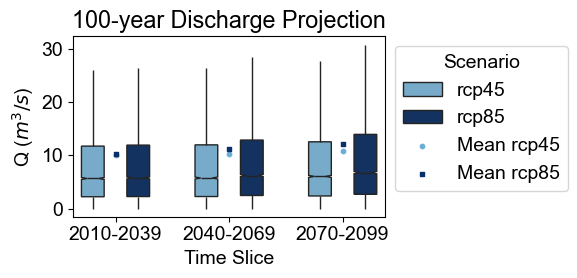

In [132]:
# Define parameters
return_periods = ['2','5','10','25','50','100']
time_slices = ['2010-2039','2040-2069','2070-2099']
scenarios = ['rcp45','rcp85']
# Set consistent color palette and markers for scenarios
palette = {'rcp45': '#6baed6', 'rcp85': '#08306b'}
markers = {'rcp45': 'o', 'rcp85': 's'}
# Plot each return period in its own plot
for rp in return_periods:
    # Prepare long-form data
    data = {'Time': [], 'Scenario': [], 'Q Value': []}
    mean_data = {'Time': [], 'Scenario': [], 'Mean Q': []}

    for time in time_slices:
        for scenario in scenarios:
            col = f'Q_{rp}_{time}_{scenario}'
            if col not in culvert_Q.columns:
                continue
            q_values = culvert_Q[col].dropna()
            for val in q_values:
                data['Time'].append(time)
                data['Scenario'].append(scenario)
                data['Q Value'].append(val)
            mean_data['Time'].append(time)
            mean_data['Scenario'].append(scenario)
            mean_data['Mean Q'].append(q_values.mean())
    # Create DataFrames
    df_box = pd.DataFrame(data)
    df_mean = pd.DataFrame(mean_data)
    # Set Time as categorical for ordering
    df_box['Time'] = pd.Categorical(df_box['Time'], categories=time_slices, ordered=True)
    df_mean['Time'] = pd.Categorical(df_mean['Time'], categories=time_slices, ordered=True)
    # Setup plot
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df_box, x='Time', y='Q Value', hue='Scenario',
                palette=[palette[s] for s in scenarios], showfliers=False,
                notch=True, showcaps=False, gap=0.5)
    # Add mean points
    for scenario in scenarios:
        subset = df_mean[df_mean['Scenario'] == scenario]
        subset = subset.sort_values("Time")  # Ensure correct order
        x_ticks = subset['Time'].cat.codes  # Convert categorical 'Time' to numeric positions
        plt.scatter(x_ticks, subset['Mean Q'], marker=markers[scenario], s=10,
                    label=f'Mean {scenario}', color=palette[scenario])
    # Axis styling
    plt.xticks(ticks=np.arange(len(time_slices)), labels=time_slices)
    plt.ylabel("Q ($m^3/s$)")
    plt.xlabel("Time Slice")
    plt.title(f"{rp}-year Discharge Projection")
    plt.legend(title="Scenario", loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    # Save and show
    plt.savefig(fr"D:\culvert repo\Results\Figures\Q_{rp}_distribution_2010_2099_All.png", dpi=300,bbox_inches='tight')
    plt.show()

In [133]:
# Define the output file path for Excel
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rainandQ_All.xlsx'
# Save the DataFrame to an Excel file
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rainandQ_All.xlsx


# Joint effect of projected rianfall and land use

In [134]:
scenarios = ['A2', 'B2']
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    # Iterate over each return period
    for scenario in scenarios:
            for year in years:
                for ASM in ['Wet']:
                    #
                    if scenario=='A2':
                        scen='rcp85'
                    else:
                        scen='rcp45'
                    #
                    if year <2040:
                        time='2010-2039'
                    elif year <2070:
                        time='2040-2069'
                    else :
                        time='2070-2099' 
                    #    
                    max_dis = 0   
                    for period in return_periods:
                        rp=str(period)+'-yr'
                    # Loop through each interval
                        for idx, interval in enumerate(intervals):
                            # Set depth data (assuming the correct attributes are in `culvert`)
                            # Use getattr to dynamically access the attribute based on the period
                            depth = [
                                getattr(culvert, f"{rp}_{time}_{scen}_0.17"),
                                getattr(culvert, f"{rp}_{time}_{scen}_0.25"),
                                getattr(culvert, f"{rp}_{time}_{scen}_0.5"),
                                getattr(culvert, f"{rp}_{time}_{scen}_1"),
                                getattr(culvert, f"{rp}_{time}_{scen}_2"),
                                getattr(culvert, f"{rp}_{time}_{scen}_3"),
                                getattr(culvert, f"{rp}_{time}_{scen}_6"),
                                getattr(culvert, f"{rp}_{time}_{scen}_12"),
                                getattr(culvert, f"{rp}_{time}_{scen}_24")
                            ]
                            # Compute and normalize rainfall for each interval
                            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
                            normalized_intervals[interval]= incremental_rainfall(rainfall)
                            # Calculate excess rainfall for each interval
                            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert[f'CN_{year}_{scenario}_{ASM}'])
                            # Extract relevant data for discharge calculation
                            df = result_df[['Time', 'Incremental Excess (mm)']]
                            # Determine time step based on interval
                            time_step = 5 if interval < 0.5 else 6
                            # Generate unit hydrograph
                            intervals_1, discharge_values = construct_unit_hydrograph(
                                culvert[f't_CN_{year}_{scenario}_{ASM}'], culvert.Area / 10**6, time_step / 60, time_step
                            )
                            unit_hydrograph = np.array(discharge_values)
                            # Calculate total discharge for this interval
                            discharge = calculate_total_discharge(df, unit_hydrograph)
                            # Get the total discharge column
                            total_discharge = discharge['Total Discharge']
                            # Find the maximum discharge value for the current interval
                            max_discharge_index = total_discharge.idxmax()
                            max_discharge_row = discharge.iloc[max_discharge_index]
                            # Check if the third-to-last element is non-zero and update max discharge if needed
                            if max_discharge_row[-3] != 0:
                                max_dis = max(max_dis, max_discharge_row[-1])
                        # Store the max discharge for this return period in the dictionary
                        max_discharges[f'Q_{period}_{year}_{scenario}_{ASM}_fr'] = max_dis
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100]
def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)
culvert=culvert_Q

Rows processing: 100%|██████████| 6731/6731 [5:07:26<00:00,  2.74s/it]  


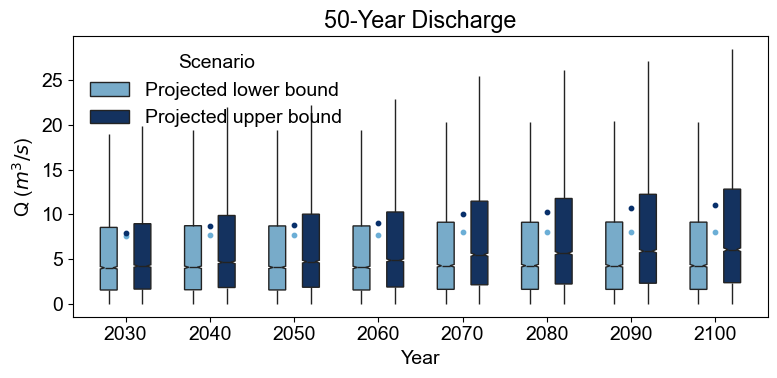

In [135]:
# Settings
rp = '50'  # Choose one return period to plot
scenarios = ['A2', 'B2']
rcp_mapping = {'A2': 'rcp85', 'B2': 'rcp45'}
colors = {'rcp45': '#6baed6', 'rcp85': '#08306b'}
markers = {'rcp45': 'o', 'rcp85': 'o'}
hue_order = ['rcp45', 'rcp85']
legend_labels = {'rcp45': 'Projected lower bound', 'rcp85': 'Projected upper bound'}
years = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
ASM = 'Wet'

# Initialize data containers
data = {'Year': [], 'Scenario': [], 'Q Value': []}
mean_data = {'Year': [], 'Scenario': [], 'Mean Q': []}

# Extract and organize data
for scenario in scenarios:
    rcp = rcp_mapping[scenario]
    for year in years:
        col_name = f'Q_{rp}_{year}_{scenario}_{ASM}_fr'
        if col_name not in culvert.columns:
            continue
        q_vals = culvert[col_name].dropna().values.tolist()
        data['Year'].extend([str(year)] * len(q_vals))
        data['Scenario'].extend([rcp] * len(q_vals))
        data['Q Value'].extend(q_vals)
        mean_data['Year'].append(str(year))
        mean_data['Scenario'].append(rcp)
        mean_data['Mean Q'].append(np.mean(q_vals))

# Convert to DataFrames
df_box = pd.DataFrame(data)
df_mean = pd.DataFrame(mean_data)

# Create the plot
plt.figure(figsize=(8, 4))
ax = sns.boxplot(
    data=df_box,
    x='Year',
    y='Q Value',
    hue='Scenario',
    hue_order=hue_order,
    palette=colors,
    showfliers=False,
    notch=True,
    showcaps=False,
    gap=0.5
)

# Overlay mean values as scatter points
for rcp in hue_order:
    subset = df_mean[df_mean['Scenario'] == rcp].sort_values('Year')
    x_pos = np.arange(len(subset))
    plt.scatter(
        x_pos,
        subset['Mean Q'],
        marker=markers[rcp],
        s=10,
        color=colors[rcp],
        zorder=3
    )

# Final formatting
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=[legend_labels[rcp] for rcp in hue_order],
    title="Scenario",
    loc="upper left",
    frameon=False
)

plt.ylabel("Q ($m^3/s$)")
plt.xlabel("Year")
plt.title(f"{rp}-Year Discharge")
plt.tight_layout()
plt.savefig(fr"D:\culvert repo\Results\Figures\Q_{rp}_by_year_{ASM}_All.png", dpi=300, bbox_inches='tight')
plt.show()

In [136]:
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q_All.xlsx'
# Save the DataFrame to an Excel file
culvert.to_excel(excel_output_file, index=False)
print(f"df saved to {excel_output_file}")

df saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q_All.xlsx


In [137]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-07-29 23:29:11.687818


In [138]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,geopandas,sklearn,matplotlib,seaborn,os,rasterio,tqdm,scipy

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
pandas    : 2.2.2
geopandas : 1.0.1
sklearn   : 1.5.1
matplotlib: 3.8.4
seaborn   : 0.13.2
os        : unknown
rasterio  : 1.4.3
tqdm      : 4.66.5
scipy     : 1.13.1

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

